# Environment Setup

## Package Installation

In [93]:
# %pip install pandas matplotlib numpy seaborn scikit-learn xgboost patsy statsmodels
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install seaborn
# %pip install pmdarima
# %pip install tqdm
# %pip install lightgbm


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 25.2 MB/s eta 0:00:00


## Imports and GPU Configuration

In [2]:
# Cell 1 - Environment Setup and Imports
import warnings
import os
warnings.filterwarnings('ignore')

# Essential libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import platform
from scipy import stats

# Time series specific
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# ML/DL libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting settings - using a more reliable approach
plt.style.use('default')  # Reset to default style
sns.set_style("whitegrid")  # Apply seaborn styling
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

def print_gpu_info():
    """
    Print detailed information about GPU configuration
    """
    print("System Information:")
    print(f"Python version: {sys.version}")
    print(f"Platform: {platform.platform()}")
    print(f"PyTorch version: {torch.__version__}")
    
    print("\nGPU Information:")
    if torch.cuda.is_available():
        print(f"GPU Available: Yes")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        print(f"Current GPU: {torch.cuda.current_device()}")
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
        
        # Test GPU with a simple operation
        print("\nTesting GPU...")
        x = torch.randn(1000, 1000).cuda()
        y = torch.matmul(x, x.t())
        print("GPU test successful!")
    else:
        print("No GPU available. Using CPU.")

print_gpu_info()

Using device: cuda
System Information:
Python version: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
PyTorch version: 2.5.1+cu121

GPU Information:
GPU Available: Yes
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 4070 Ti
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB

Testing GPU...
GPU test successful!


# Data Loading and Preprocessing

- Data Import
- Initial Data Quality Checks
- Missing Values Analysis
- DateTime Index Setup

In [3]:
# Cell 2 - Data Loading and Basic Checks
def load_data(filepath):
    """
    Load and preprocess the time series data
    Parameters:
    filepath (str): Path to the CSV file
    Returns:
    pd.DataFrame: Preprocessed DataFrame with DateTime index
    """
    # Read the CSV file
    df = pd.read_csv(filepath)

    # Try to detect the datetime format automatically
    try:
        df['DateTime'] = pd.to_datetime(df['DateTime'], format='mixed')
    except ValueError as e:
        print(f"Warning: {e}")
        print("Attempting alternative datetime parsing...")
        try:
            df['DateTime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
        except Exception as e:
            print(f"Error in datetime parsing: {e}")
            raise

    # Set DateTime as index
    df.set_index('DateTime', inplace=True)

    # Sort index to ensure chronological order
    df.sort_index(inplace=True)

    # Display basic information
    print("\nDataset Info:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())
    print("\nLast few rows:")
    print(df.tail())
    print("\nBasic statistics:")
    print(df.describe())

    return df

# Load the data
try:
    df = load_data('ts2024.csv')
except Exception as e:
    print(f"Error loading data: {e}")
    raise


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2015-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    17544 non-null  object 
 1   Hour    17544 non-null  int64  
 2   X       16800 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 548.2+ KB
None

First few rows:
                           Date  Hour       X
DateTime                                     
2015-01-01 00:00:00  2015-01-01     0  0.0146
2015-01-01 01:00:00  2015-01-01     1  0.0148
2015-01-01 02:00:00  2015-01-01     2  0.0101
2015-01-01 03:00:00  2015-01-01     3  0.0060
2015-01-01 04:00:00  2015-01-01     4  0.0055

Last few rows:
                           Date  Hour   X
DateTime                                 
2016-12-31 19:00:00  2016-12-31    19 NaN
2016-12-31 20:00:00  2016-12-31    20 NaN
2016-12-31 21:00:00  2016-12-31    21 NaN
2016-12-31 22:00:00  20

In [4]:
# Cell 3 - Data Quality Analysis and Cleaning
def analyze_data_quality(df):
    """
    Perform comprehensive data quality analysis
    """
    print("=== Data Quality Analysis ===")

    # Basic dataset properties
    print("\n1. Dataset Properties:")
    print(f"Time range: {df.index.min()} to {df.index.max()}")
    print(f"Total number of records: {len(df)}")
    print(f"Sampling frequency: {df.index.freq if df.index.freq else 'Inferred hourly'}")

    # Check for duplicates
    duplicates = df.index.duplicated(keep=False)
    if duplicates.any():
        n_duplicates = duplicates.sum()
        print(f"\nWarning: Found {n_duplicates} duplicate timestamps!")
        print("\nExample of duplicates:")
        print(df[duplicates].sort_index().head())

    # Check for time series continuity
    expected_periods = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_periods = set(expected_periods) - set(df.index)

    print("\n2. Time Series Continuity:")
    print(f"Number of missing timestamps: {len(missing_periods)}")
    if missing_periods:
        print("Sample of missing timestamps:")
        print(sorted(list(missing_periods))[:5])

    # Value distribution analysis
    print("\n3. Value Distribution (X):")
    print(df['X'].describe())

    # Outlier detection
    Q1 = df['X'].quantile(0.25)
    Q3 = df['X'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['X'] < (Q1 - 1.5 * IQR)) | (df['X'] > (Q3 + 1.5 * IQR))]

    print("\n4. Outlier Analysis:")
    print(f"Number of potential outliers: {len(outliers)}")
    if len(outliers) > 0:
        print("Sample of outliers:")
        print(outliers.head())

    # Missing data patterns
    print("\n5. Missing Data Patterns:")
    missing_by_month = df['X'].isna().groupby(df.index.month).sum()
    print("Missing values by month:")
    print(missing_by_month)

    return missing_periods, outliers, duplicates

def clean_data(df, duplicates):
    """
    Clean the data by:
    1. Handling duplicates by taking their mean
    2. Filling ONLY the two specific missing timestamps in historical data
    3. Keeping the last 744 values as missing for forecasting
    """
    print("=== Data Cleaning ===")
    
    df_cleaned = df.copy()
    
    # Step 1: Handle duplicates by taking the mean of X values for same timestamps
    if duplicates.any():
        print("\nHandling duplicates by taking the mean value for each timestamp...")
        df_cleaned = df_cleaned.groupby(level=0).agg({
            'Date': 'first',  # Keep first date string
            'Hour': 'first',  # Keep first hour
            'X': 'mean'      # Take mean of X values
        })
        print(f"After handling duplicates: {len(df_cleaned)} rows")
    
    # Step 2: Handle ONLY the two specific missing timestamps
    specific_missing = pd.to_datetime(['2015-03-29 02:00:00', '2016-03-27 02:00:00'])
    
    for timestamp in specific_missing:
        if timestamp in df_cleaned.index:
            continue
            
        # Get the same hour from the day before and after
        prev_day = df_cleaned.loc[timestamp - pd.Timedelta(days=1):timestamp - pd.Timedelta(days=1), 'X'].iloc[0]
        next_day = df_cleaned.loc[timestamp + pd.Timedelta(days=1):timestamp + pd.Timedelta(days=1), 'X'].iloc[0]
        
        # Create new row with interpolated value
        df_cleaned.loc[timestamp] = {
            'Date': timestamp.date(),
            'Hour': timestamp.hour,
            'X': (prev_day + next_day) / 2
        }
    
    # Sort index to ensure chronological order
    df_cleaned.sort_index(inplace=True)
    
    # Verify the cleaning worked correctly
    print("\nVerification after cleaning:")
    n_missing = df_cleaned['X'].isna().sum()
    print(f"Total missing values (should be 744): {n_missing}")
    
    if n_missing != 744:
        raise ValueError(f"ERROR: Expected 744 missing values, but found {n_missing}")
        
    return df_cleaned

# Analyze and clean data
missing_periods, outliers, duplicates = analyze_data_quality(df)

=== Data Quality Analysis ===

1. Dataset Properties:
Time range: 2015-01-01 00:00:00 to 2016-12-31 23:00:00
Total number of records: 17544
Sampling frequency: Inferred hourly


Example of duplicates:
                           Date  Hour       X
DateTime                                     
2015-10-25 02:00:00  2015-10-25     2  0.0060
2015-10-25 02:00:00  2015-10-25     2  0.0053
2016-10-30 02:00:00  2016-10-30     2  0.0072
2016-10-30 02:00:00  2016-10-30     2  0.0062

2. Time Series Continuity:
Number of missing timestamps: 2
Sample of missing timestamps:
[Timestamp('2015-03-29 02:00:00'), Timestamp('2016-03-27 02:00:00')]

3. Value Distribution (X):
count    16800.000000
mean         0.046320
std          0.048945
min          0.000000
25%          0.018200
50%          0.036800
75%          0.053800
max          0.450000
Name: X, dtype: float64

4. Outlier Analysis:
Number of potential outliers: 1010
Sample of outliers:
                           Date  Hour       X
DateTime     

In [5]:
df = clean_data(df, duplicates)

=== Data Cleaning ===

Handling duplicates by taking the mean value for each timestamp...
After handling duplicates: 17542 rows

Verification after cleaning:
Total missing values (should be 744): 744


In [6]:
# Cell 4 - Data Preprocessing and Feature Engineering
def preprocess_data(df):
    """
    Preprocess the time series data and engineer features
    """
    print("=== Data Preprocessing and Feature Engineering ===")

    # Create a copy to avoid modifying original data
    df_processed = df.copy()

    # Add time-based features
    df_processed['hour'] = df_processed.index.hour
    df_processed['day_of_week'] = df_processed.index.dayofweek
    df_processed['month'] = df_processed.index.month
    df_processed['is_weekend'] = df_processed.index.dayofweek.isin([5, 6]).astype(int)

    # Calculate rolling statistics (excluding the missing period)
    non_missing = df_processed[df_processed['X'].notna()]
    df_processed['rolling_mean_24h'] = non_missing['X'].rolling(window=24, min_periods=1).mean()
    df_processed['rolling_std_24h'] = non_missing['X'].rolling(window=24, min_periods=1).std()

    # Print summary of changes
    print("\nAdded features:")
    for col in df_processed.columns:
        print(f"- {col}")

    print("\nProcessing Summary:")
    print(f"Original shape: {df.shape}")
    print(f"Processed shape: {df_processed.shape}")

    return df_processed

# Preprocess the data
df_processed = preprocess_data(df)

=== Data Preprocessing and Feature Engineering ===

Added features:
- Date
- Hour
- X
- hour
- day_of_week
- month
- is_weekend
- rolling_mean_24h
- rolling_std_24h

Processing Summary:
Original shape: (17544, 3)
Processed shape: (17544, 9)


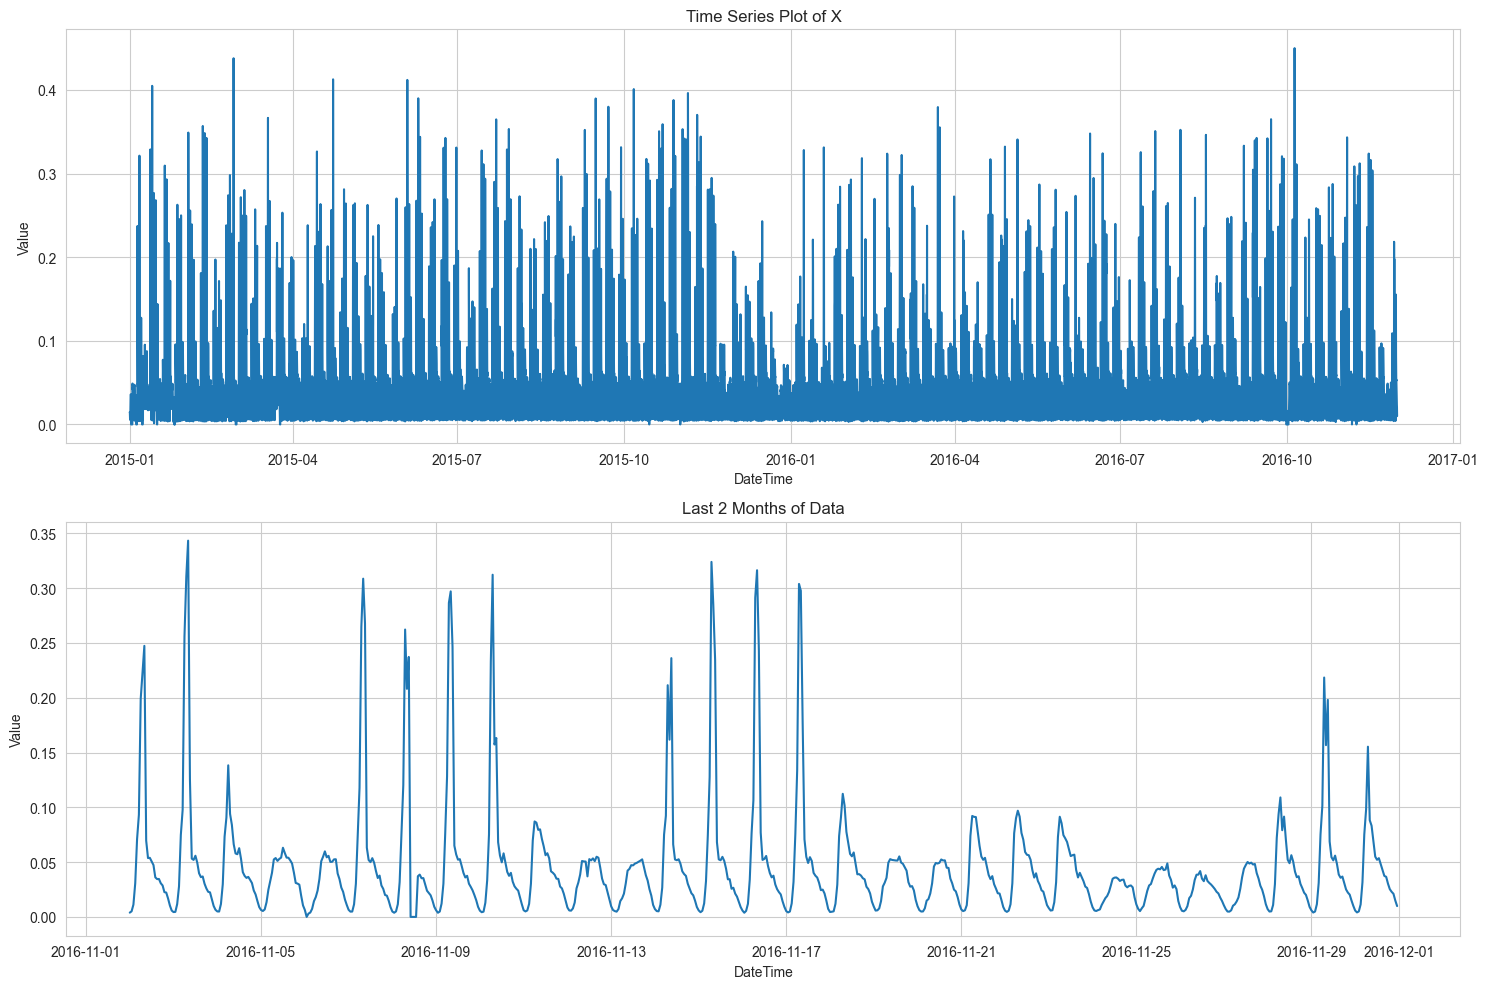

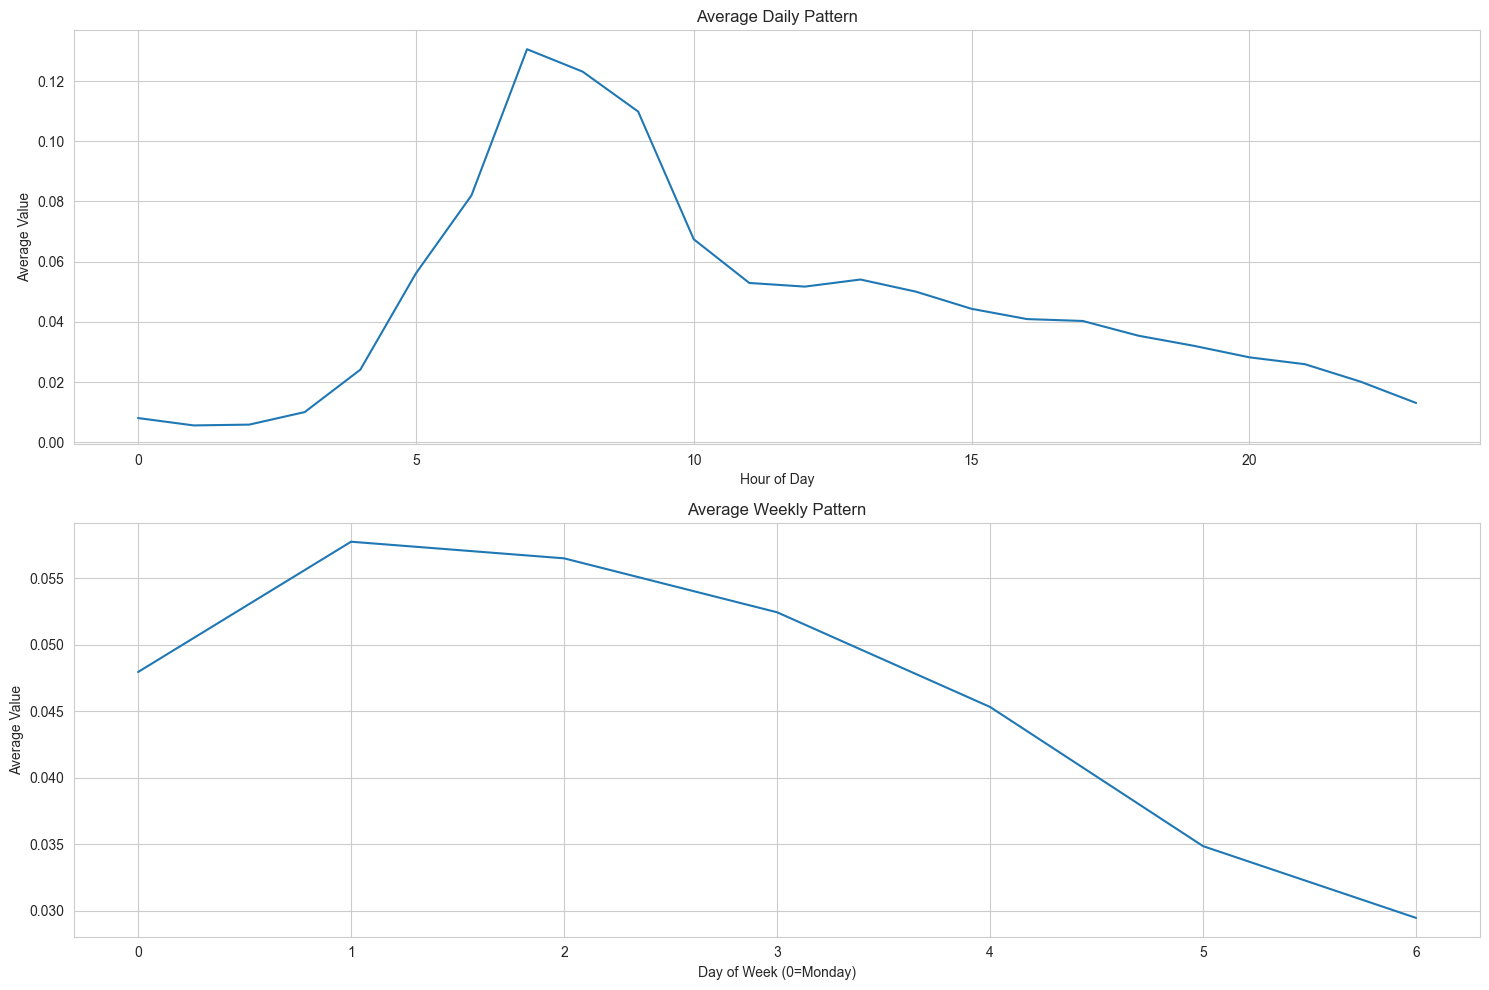

In [7]:
# Cell 5 - Initial Visualizations
def plot_time_series(df):
    """
    Create initial visualizations of the time series data
    """
    # Plot the entire time series
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df['X'])
    plt.title('Time Series Plot of X')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.grid(True)

    # Plot the last 2 months of data
    last_2_months = df.last('60D')
    plt.subplot(2, 1, 2)
    plt.plot(last_2_months.index, last_2_months['X'])
    plt.title('Last 2 Months of Data')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_patterns(df):
    """
    Plot daily and weekly patterns
    """
    plt.figure(figsize=(15, 10))

    # Daily pattern
    plt.subplot(2, 1, 1)
    daily_pattern = df.groupby(df.index.hour)['X'].mean()
    plt.plot(daily_pattern.index, daily_pattern.values)
    plt.title('Average Daily Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Value')
    plt.grid(True)

    # Weekly pattern
    plt.subplot(2, 1, 2)
    weekly_pattern = df.groupby(df.index.dayofweek)['X'].mean()
    plt.plot(weekly_pattern.index, weekly_pattern.values)
    plt.title('Average Weekly Pattern')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Average Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Create visualizations
plot_time_series(df)
plot_patterns(df)

=== Stationarity Analysis ===
ADF Statistic: -15.709489956924452
p-value: 1.3650064331681149e-28
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


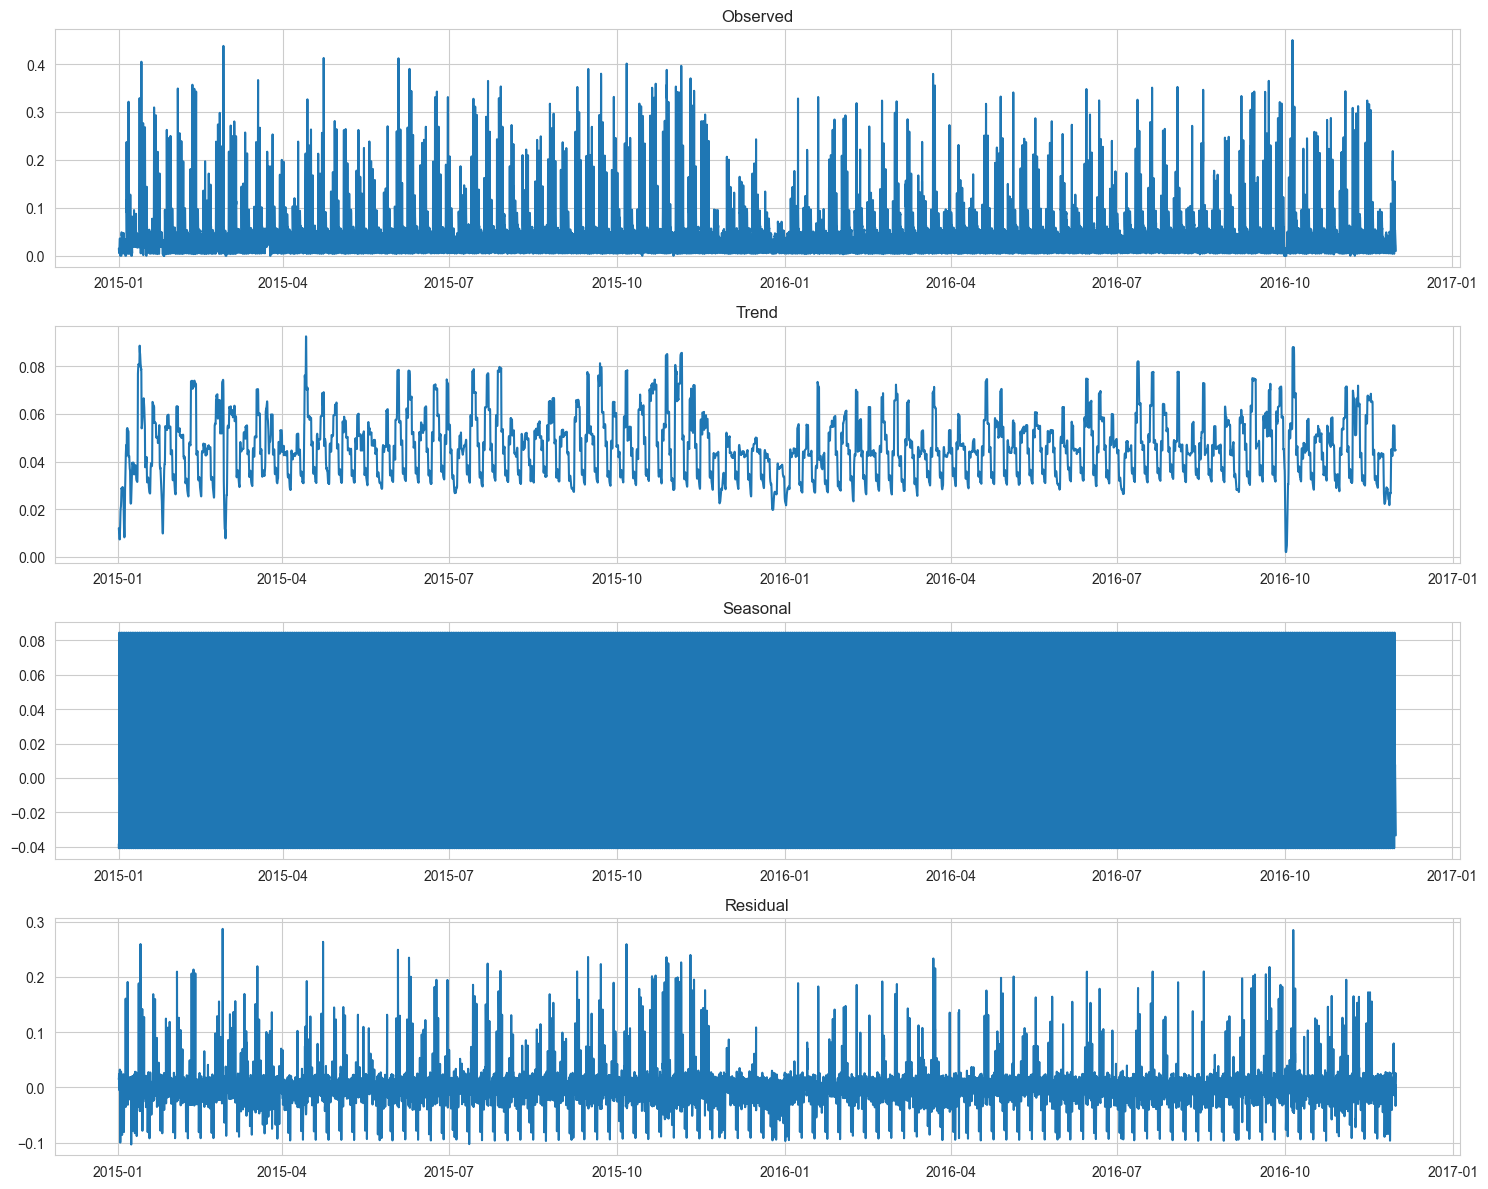

In [8]:
# Cell 6 - Statistical Analysis
def analyze_stationarity(series):
    """
    Perform stationarity analysis and seasonal decomposition
    """
    # Stationarity test
    print("=== Stationarity Analysis ===")
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # Seasonal decomposition
    decomposition = seasonal_decompose(series.dropna(), period=24)  # 24 hours for daily seasonality

    # Plot decomposition
    plt.figure(figsize=(15, 12))
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed')
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonal')
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residual')
    plt.tight_layout()
    plt.show()

    return decomposition

# Perform statistical analysis
decomposition = analyze_stationarity(df['X'])

=== Advanced Time Series Analysis ===

Analyzing multiple seasonality patterns...


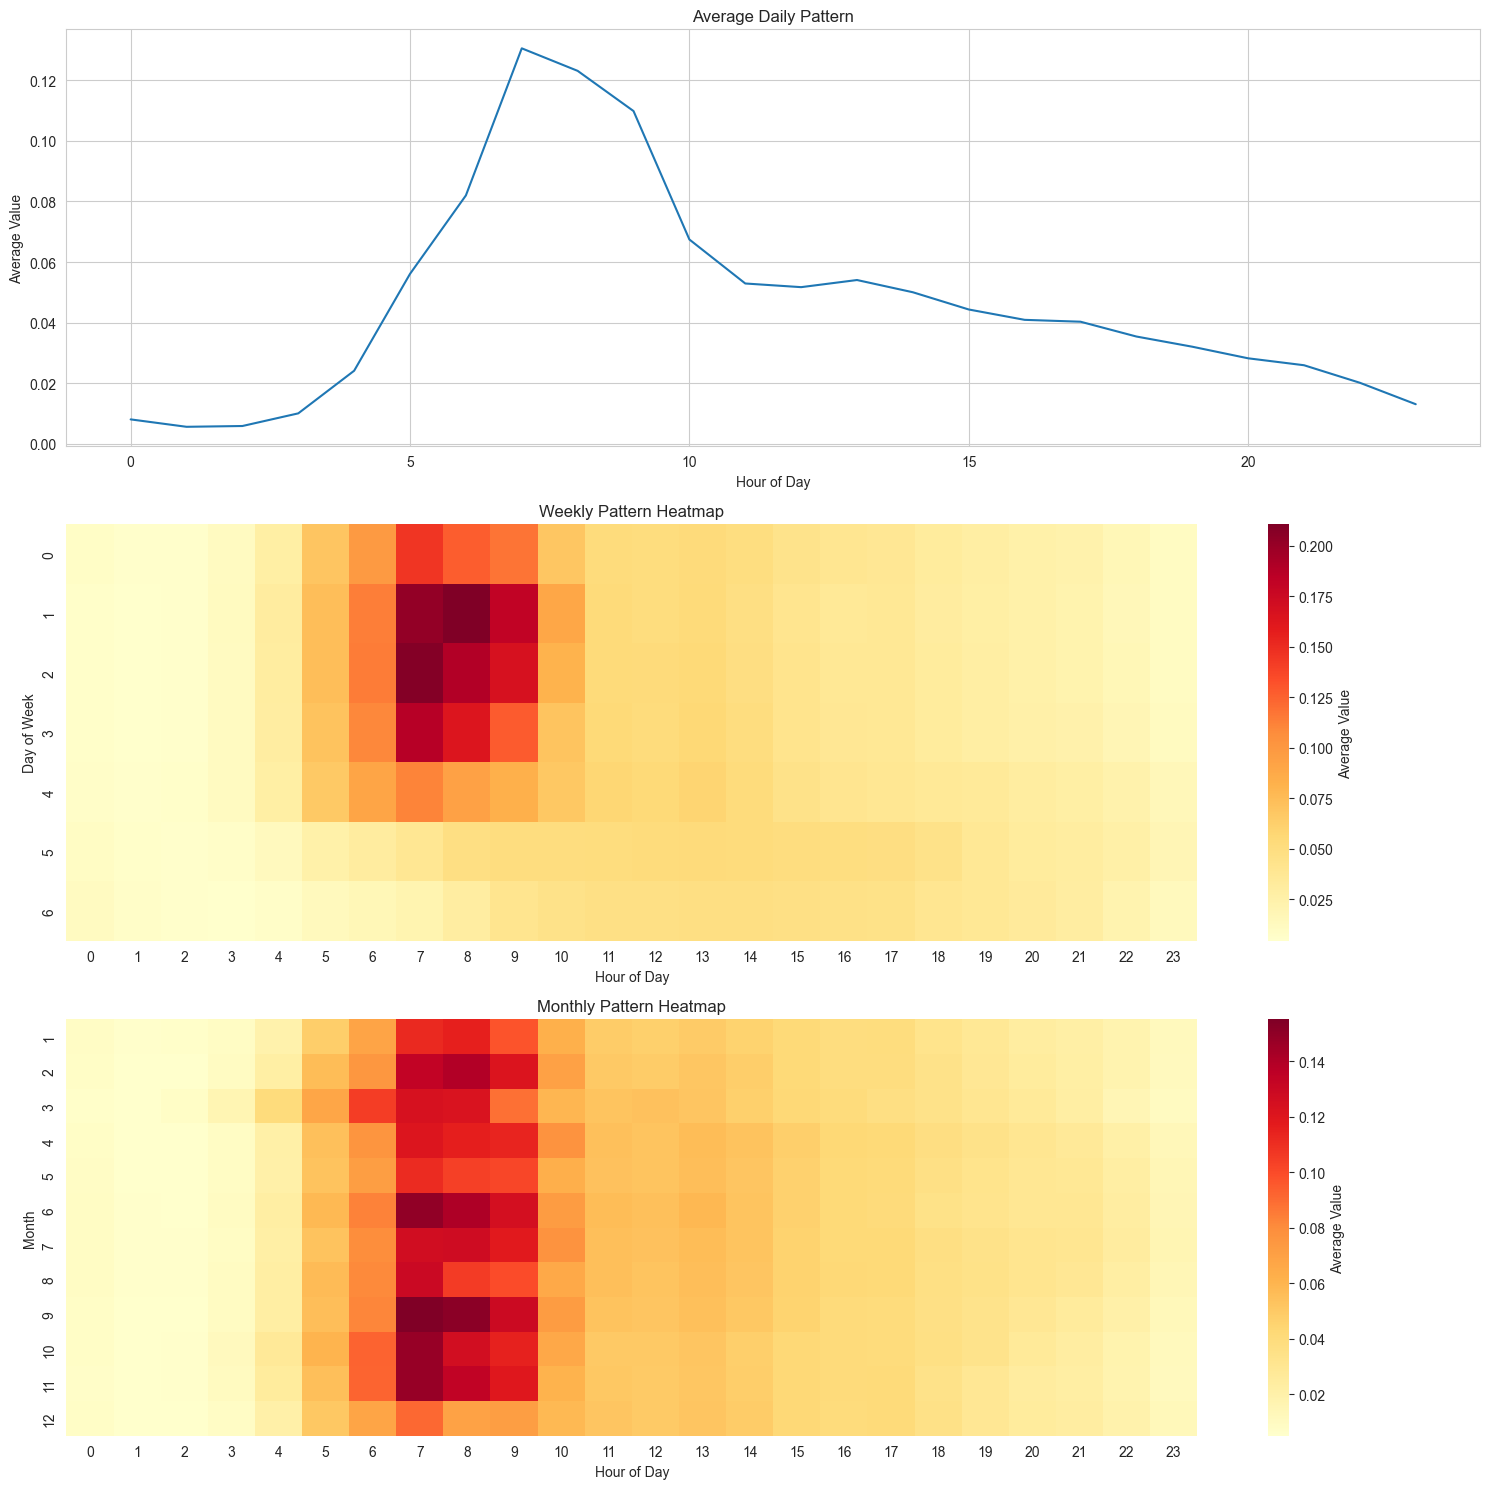

In [9]:
# Cell 7 - Advanced Time Series Analysis
print("=== Advanced Time Series Analysis ===")

def plot_acf_pacf(series, lags=40):
    """
    Plot ACF and PACF for the time series
    """
    plt.figure(figsize=(15, 10))
    
    # Plot ACF
    plt.subplot(211)
    plot_acf(series.dropna(), lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function')
    
    # Plot PACF
    plt.subplot(212)
    plot_pacf(series.dropna(), lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function')
    
    plt.tight_layout()
    plt.show()

def analyze_multiple_seasonality(df):
    """
    Analyze multiple seasonal patterns in the data
    """
    # Daily seasonality
    daily_pattern = df.groupby(df.index.hour)['X'].mean()
    
    # Weekly seasonality
    weekly_pattern = df.groupby([df.index.dayofweek, df.index.hour])['X'].mean()
    weekly_pattern = weekly_pattern.unstack()
    
    # Monthly seasonality
    monthly_pattern = df.groupby([df.index.month, df.index.hour])['X'].mean()
    monthly_pattern = monthly_pattern.unstack()
    
    # Plotting
    fig = plt.figure(figsize=(15, 15))
    
    # Daily pattern
    plt.subplot(311)
    daily_pattern.plot()
    plt.title('Average Daily Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Value')
    
    # Weekly pattern
    plt.subplot(312)
    sns.heatmap(weekly_pattern, cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
    plt.title('Weekly Pattern Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    
    # Monthly pattern
    plt.subplot(313)
    sns.heatmap(monthly_pattern, cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
    plt.title('Monthly Pattern Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Month')
    
    plt.tight_layout()
    plt.show()
    
    return daily_pattern, weekly_pattern, monthly_pattern

# Execute the functions
print("\nAnalyzing multiple seasonality patterns...")
daily_pattern, weekly_pattern, monthly_pattern = analyze_multiple_seasonality(df)



=== ACF and PACF Analysis of Original Series ===


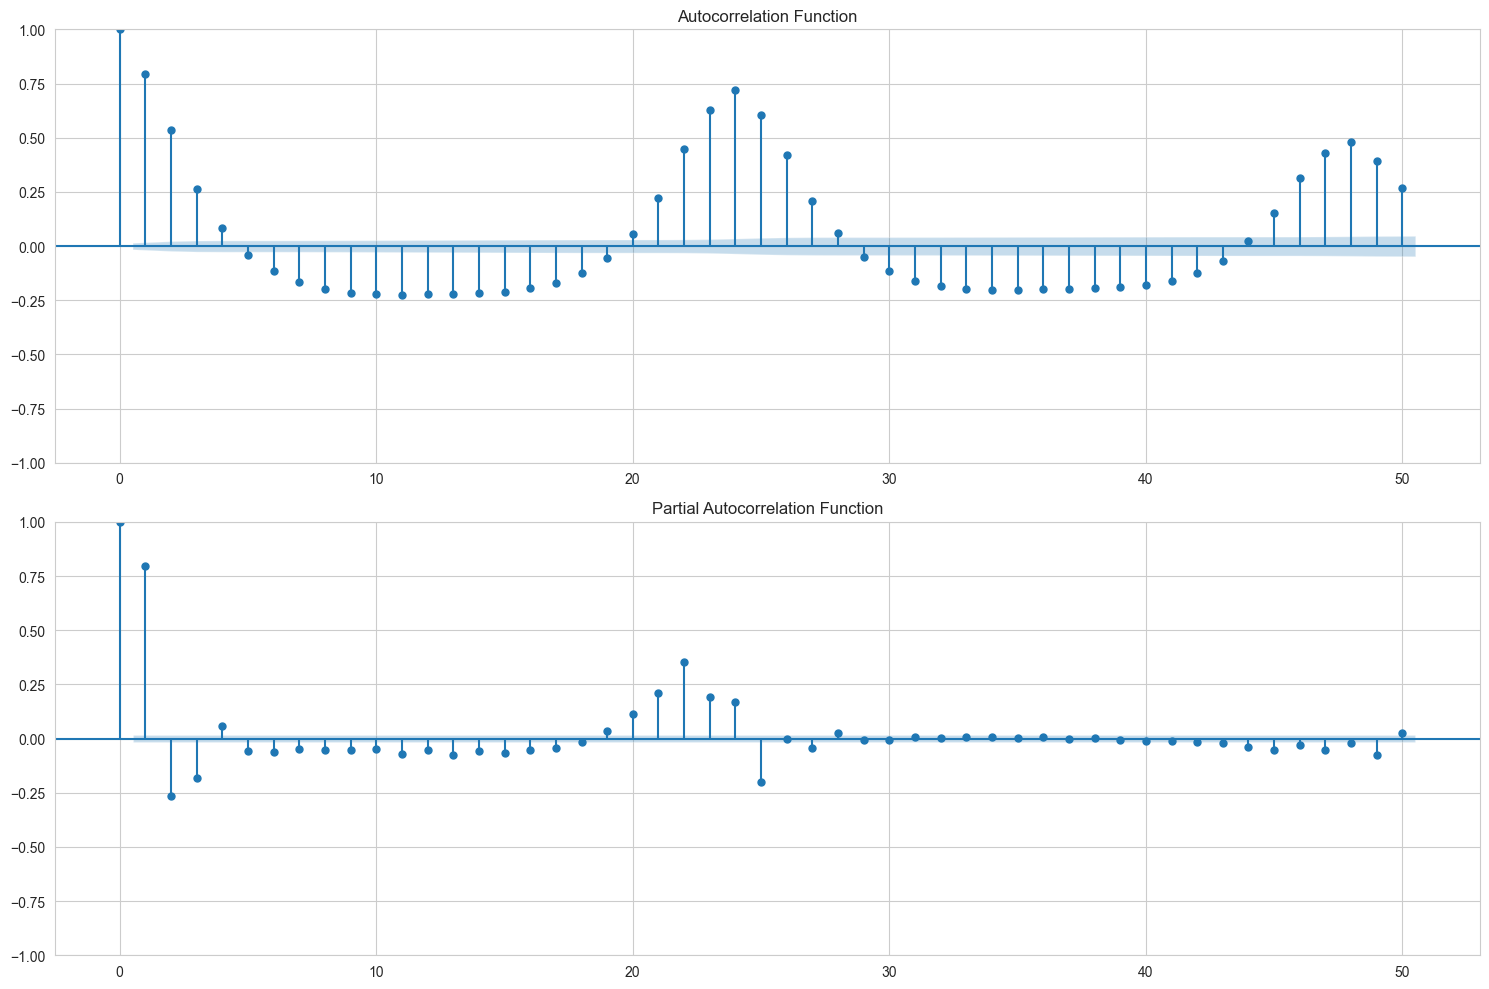


=== ACF and PACF Analysis of First Difference ===


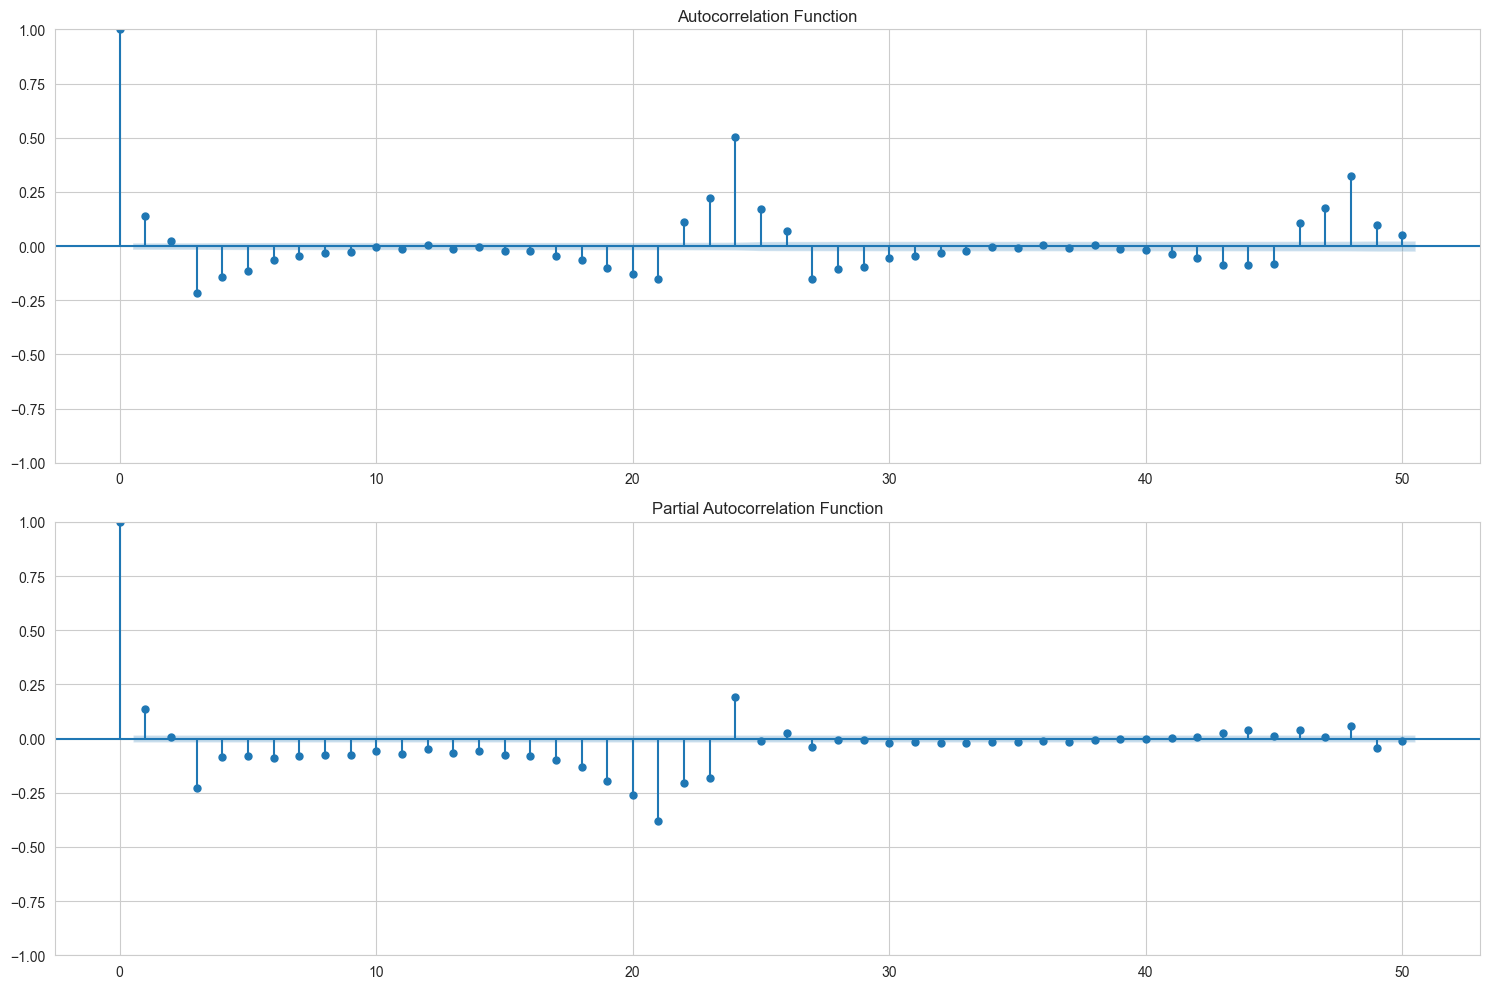


=== ACF and PACF Analysis of Seasonal Difference (24 hours) ===


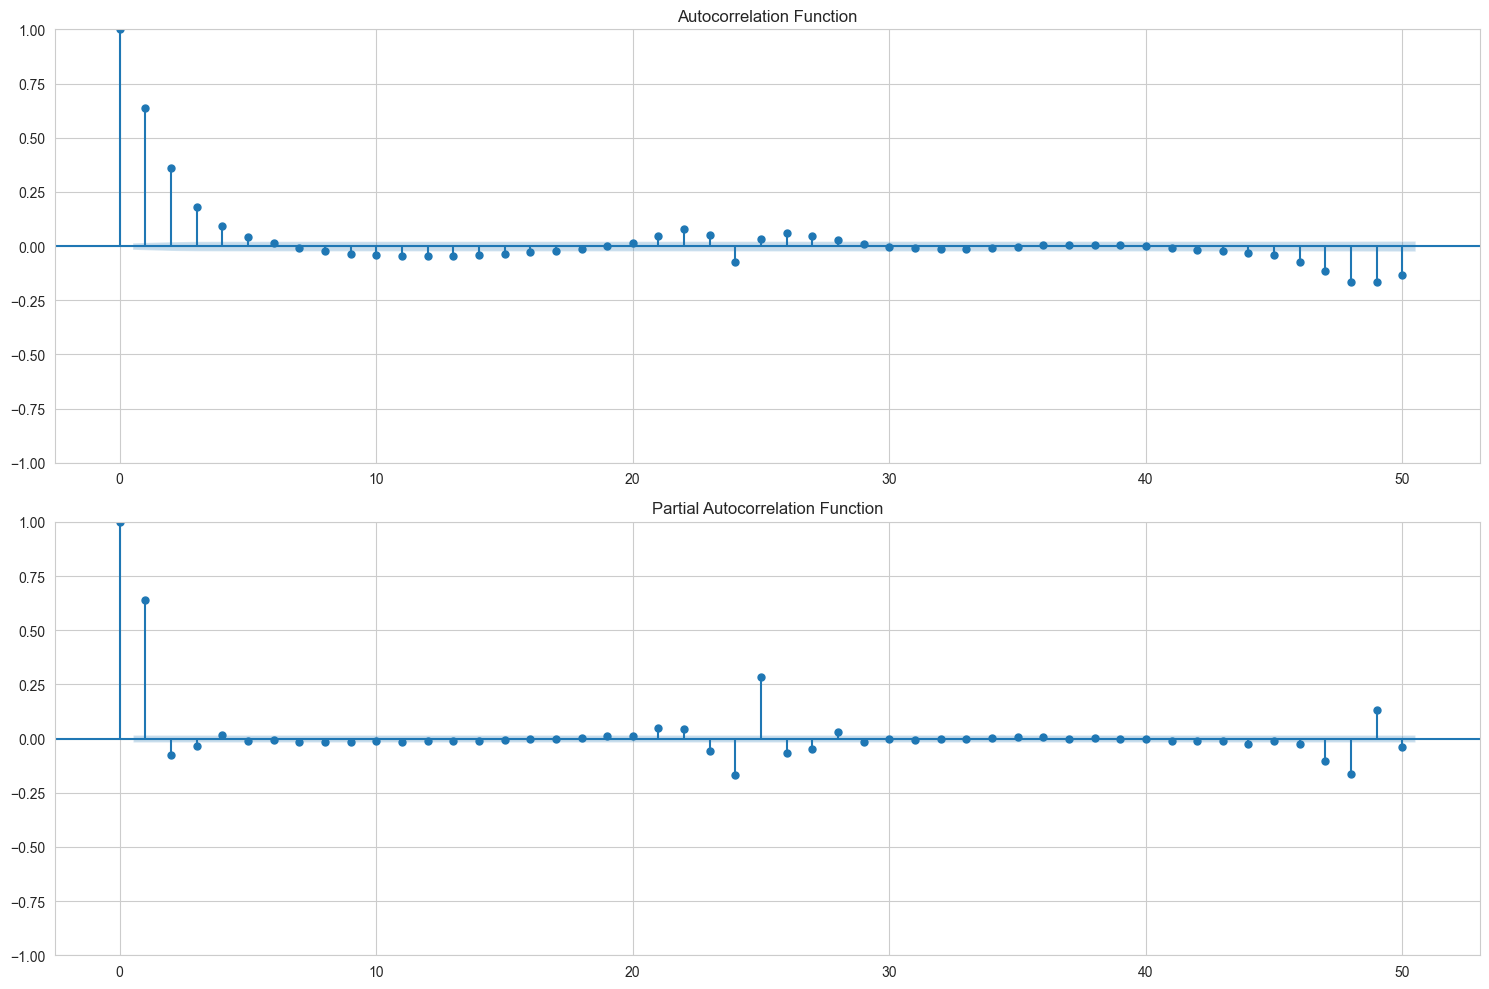


=== ACF and PACF Analysis of First and Seasonal Differences Combined ===


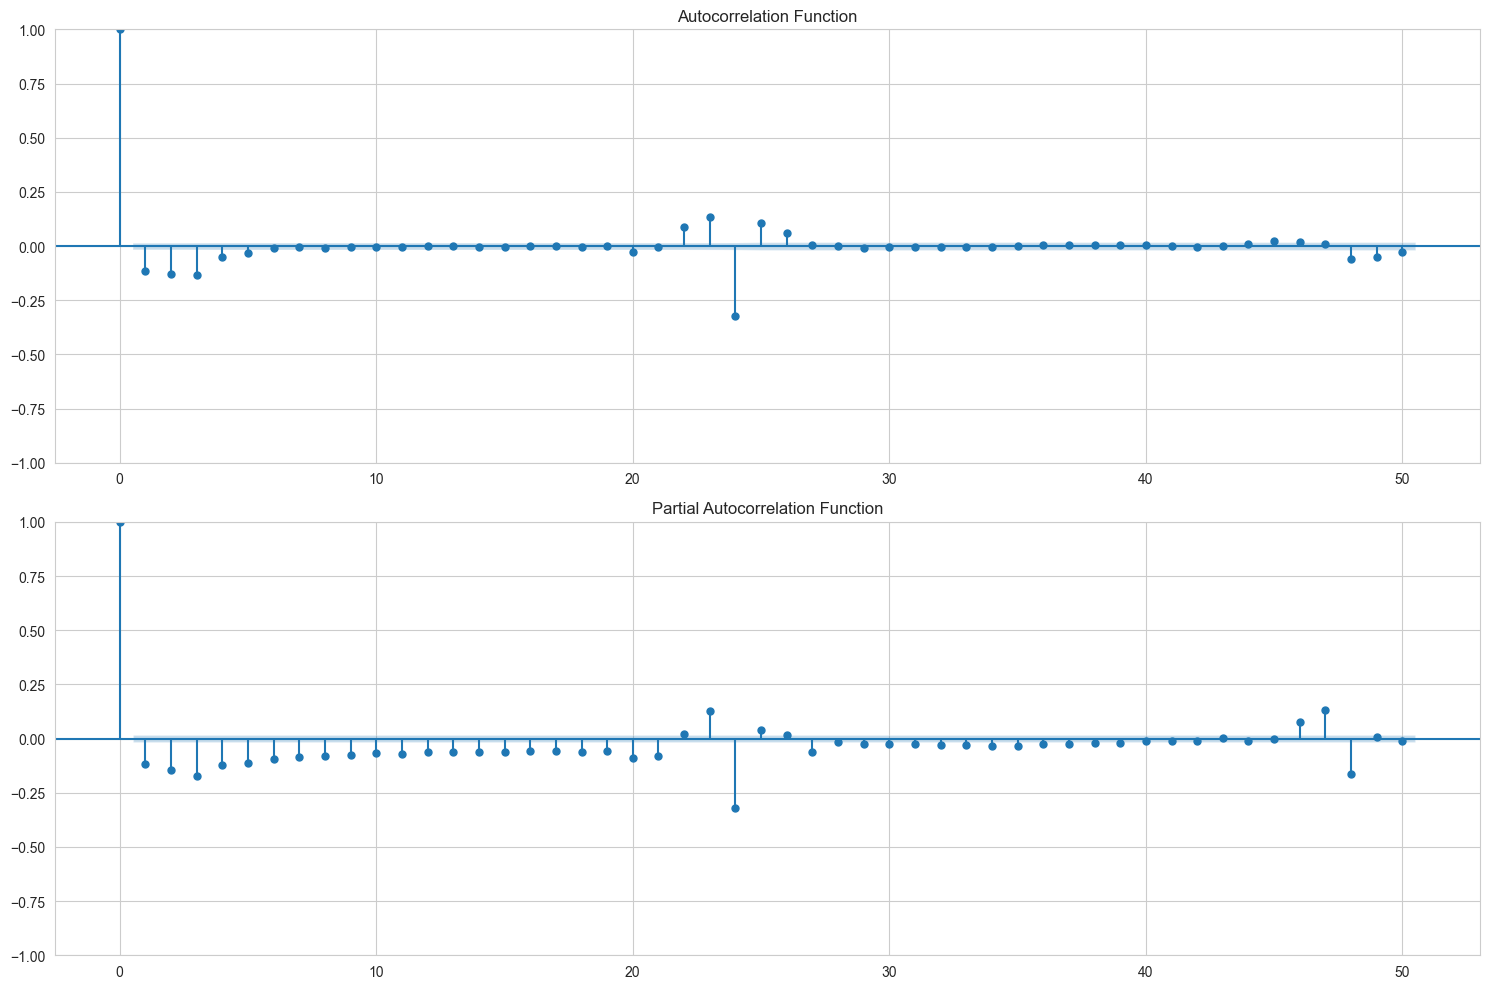


Statistics for Original Series:
Mean: 0.0463
Std: 0.0489
ADF Test p-value: 0.0000

Statistics for First Difference:
Mean: -0.0000
Std: 0.0313
ADF Test p-value: 0.0000

Statistics for Seasonal Difference:
Mean: 0.0000
Std: 0.0367
ADF Test p-value: 0.0000

Statistics for Both Differences:
Mean: 0.0000
Std: 0.0313
ADF Test p-value: 0.0000


In [10]:
# Cell 8 - ACF and PACF Analysis

# First, let's analyze the original series
print("=== ACF and PACF Analysis of Original Series ===")
plot_acf_pacf(df['X'], lags=50)

# Now let's look at first difference
print("\n=== ACF and PACF Analysis of First Difference ===")
diff1 = df['X'].diff().dropna()
plot_acf_pacf(diff1, lags=50)

# Let's also look at seasonal difference (24-hour seasonality)
print("\n=== ACF and PACF Analysis of Seasonal Difference (24 hours) ===")
seasonal_diff = df['X'].diff(24).dropna()
plot_acf_pacf(seasonal_diff, lags=50)

# And finally, both differences combined
print("\n=== ACF and PACF Analysis of First and Seasonal Differences Combined ===")
both_diff = seasonal_diff.diff().dropna()
plot_acf_pacf(both_diff, lags=50)

# Let's also show some statistics about each transformation
def print_series_stats(series, name):
    print(f"\nStatistics for {name}:")
    print(f"Mean: {series.mean():.4f}")
    print(f"Std: {series.std():.4f}")
    print(f"ADF Test p-value: {adfuller(series.dropna())[1]:.4f}")

print_series_stats(df['X'], "Original Series")
print_series_stats(diff1, "First Difference")
print_series_stats(seasonal_diff, "Seasonal Difference")
print_series_stats(both_diff, "Both Differences")

=== ACF and PACF Analysis of Original Series ===

Short-term patterns (2 days):


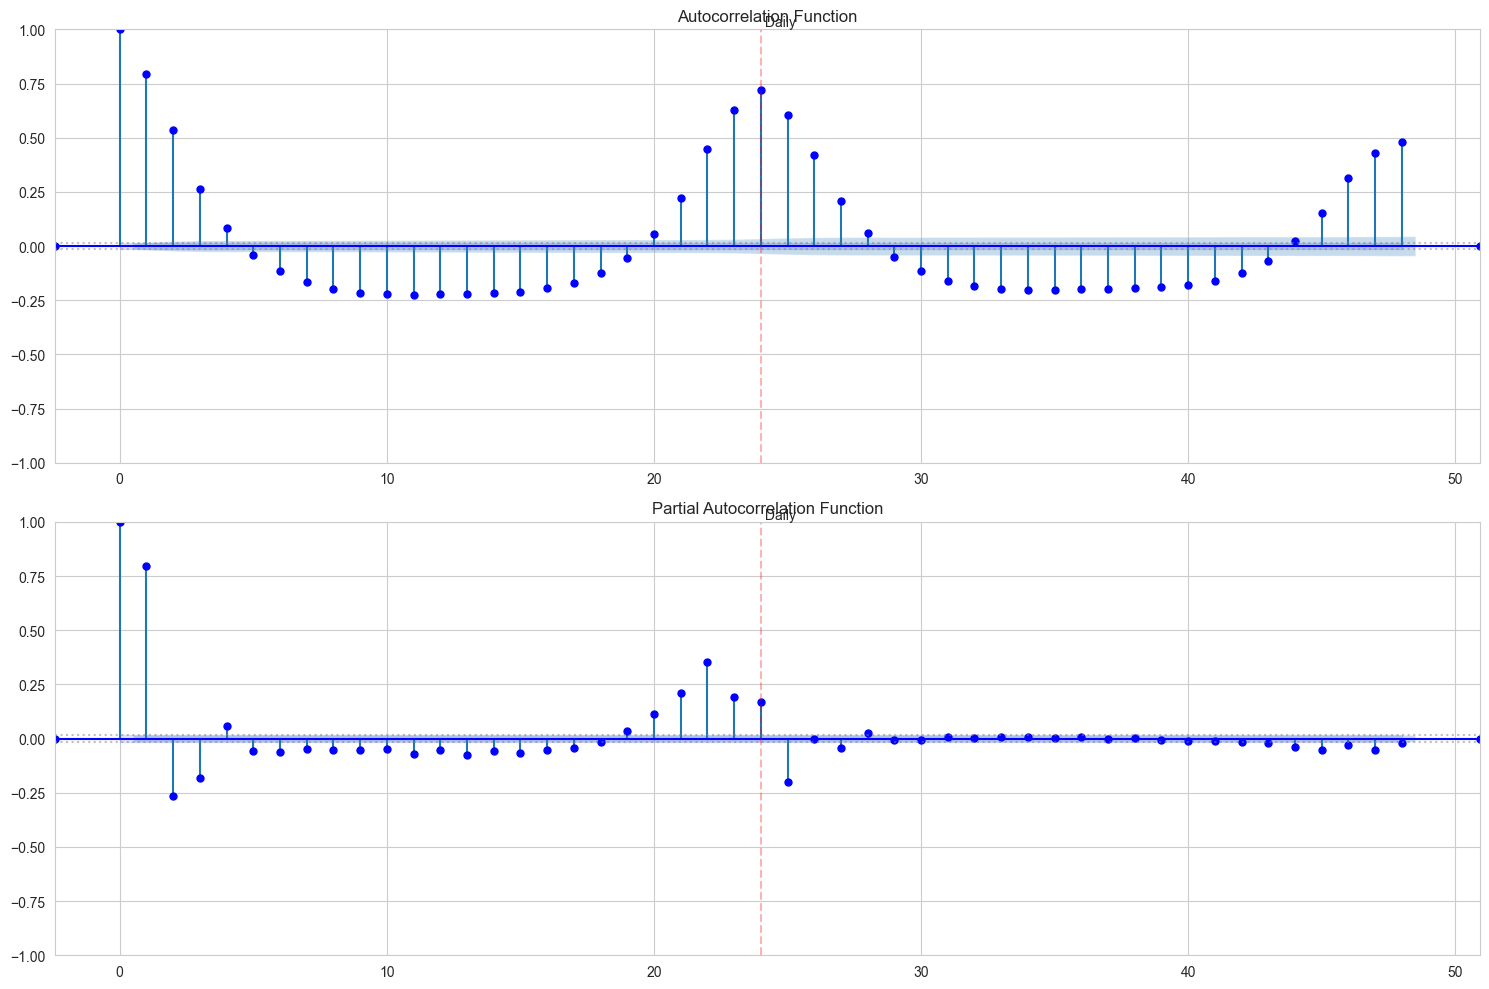


Medium-term patterns (2 weeks):


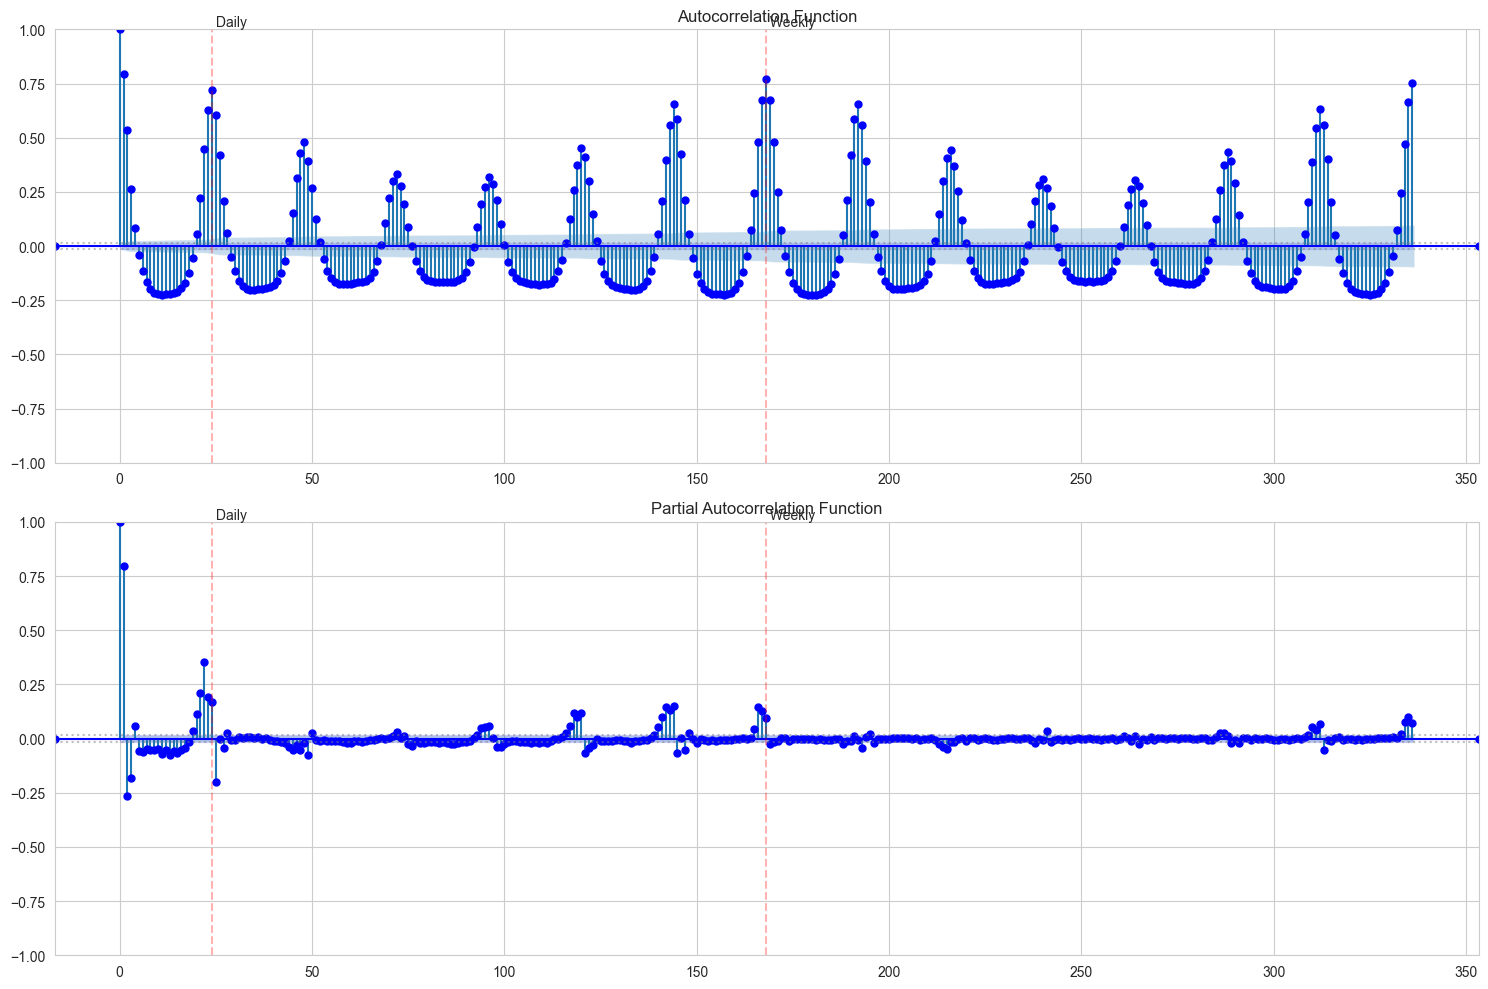


Long-term patterns (1 month):


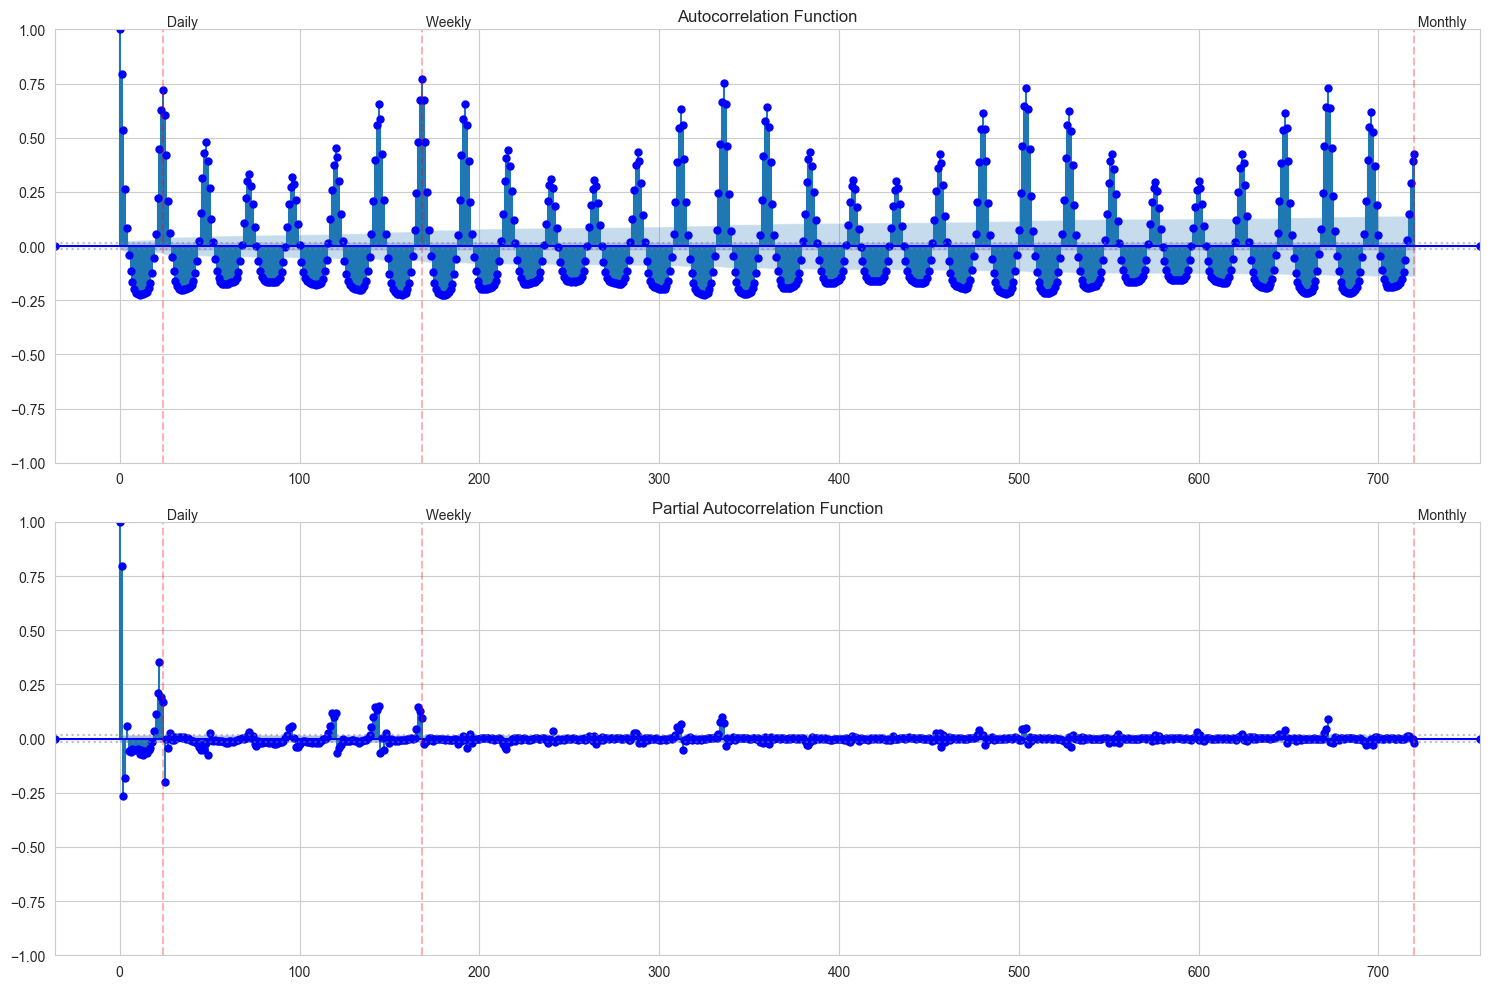


=== ACF and PACF Analysis of Differenced Series ===

First Difference:


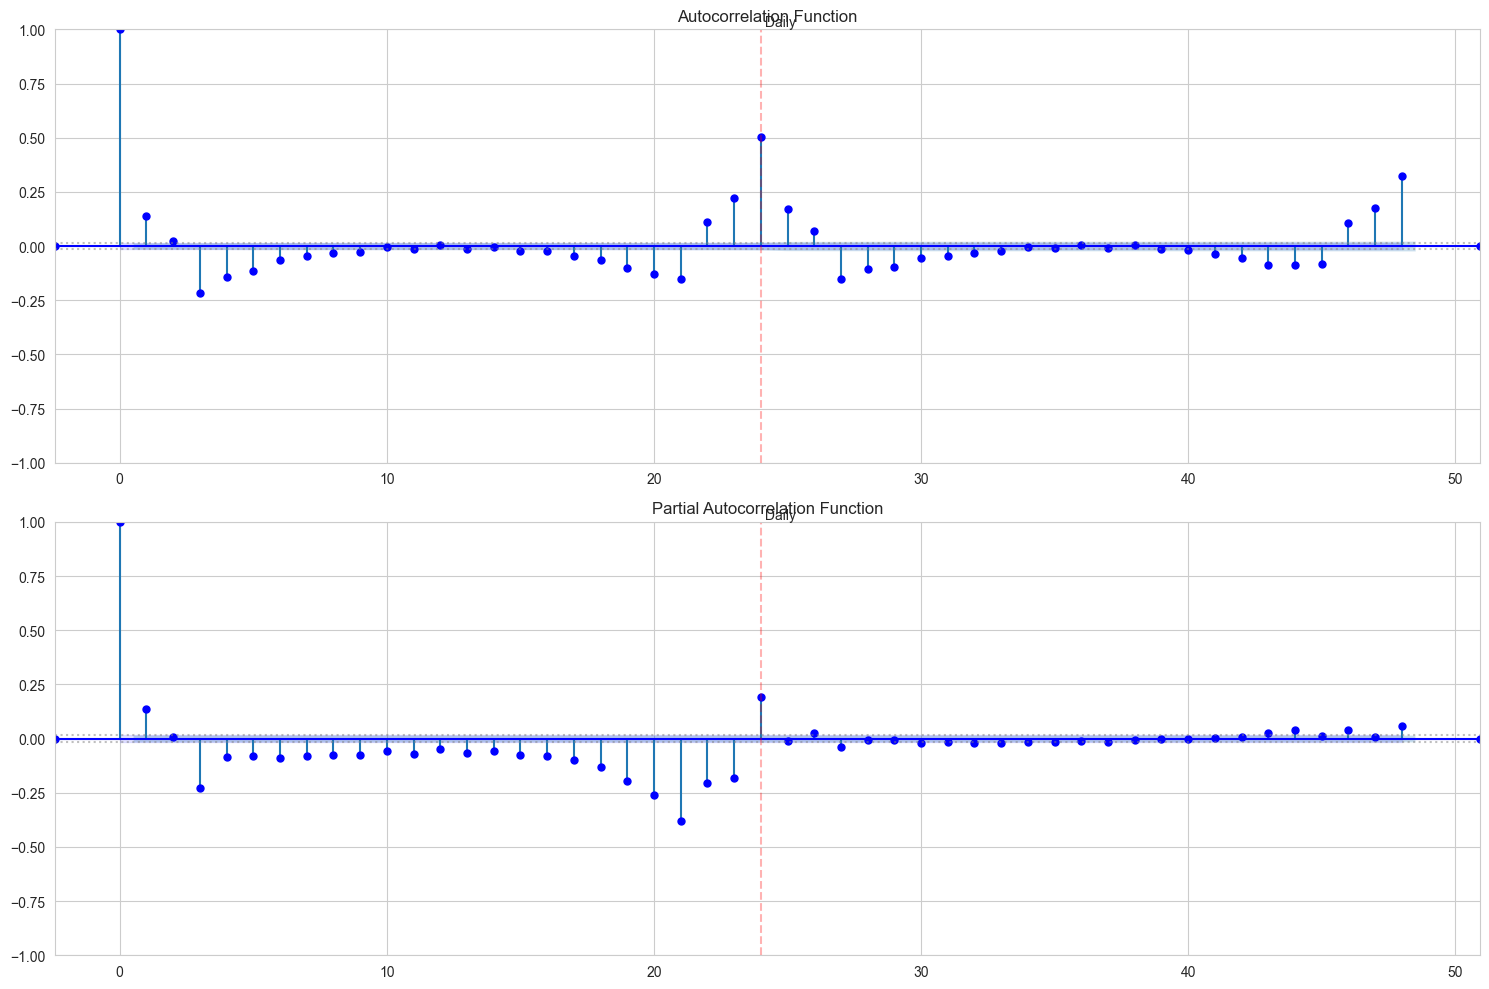


Seasonal Difference (24 hours):


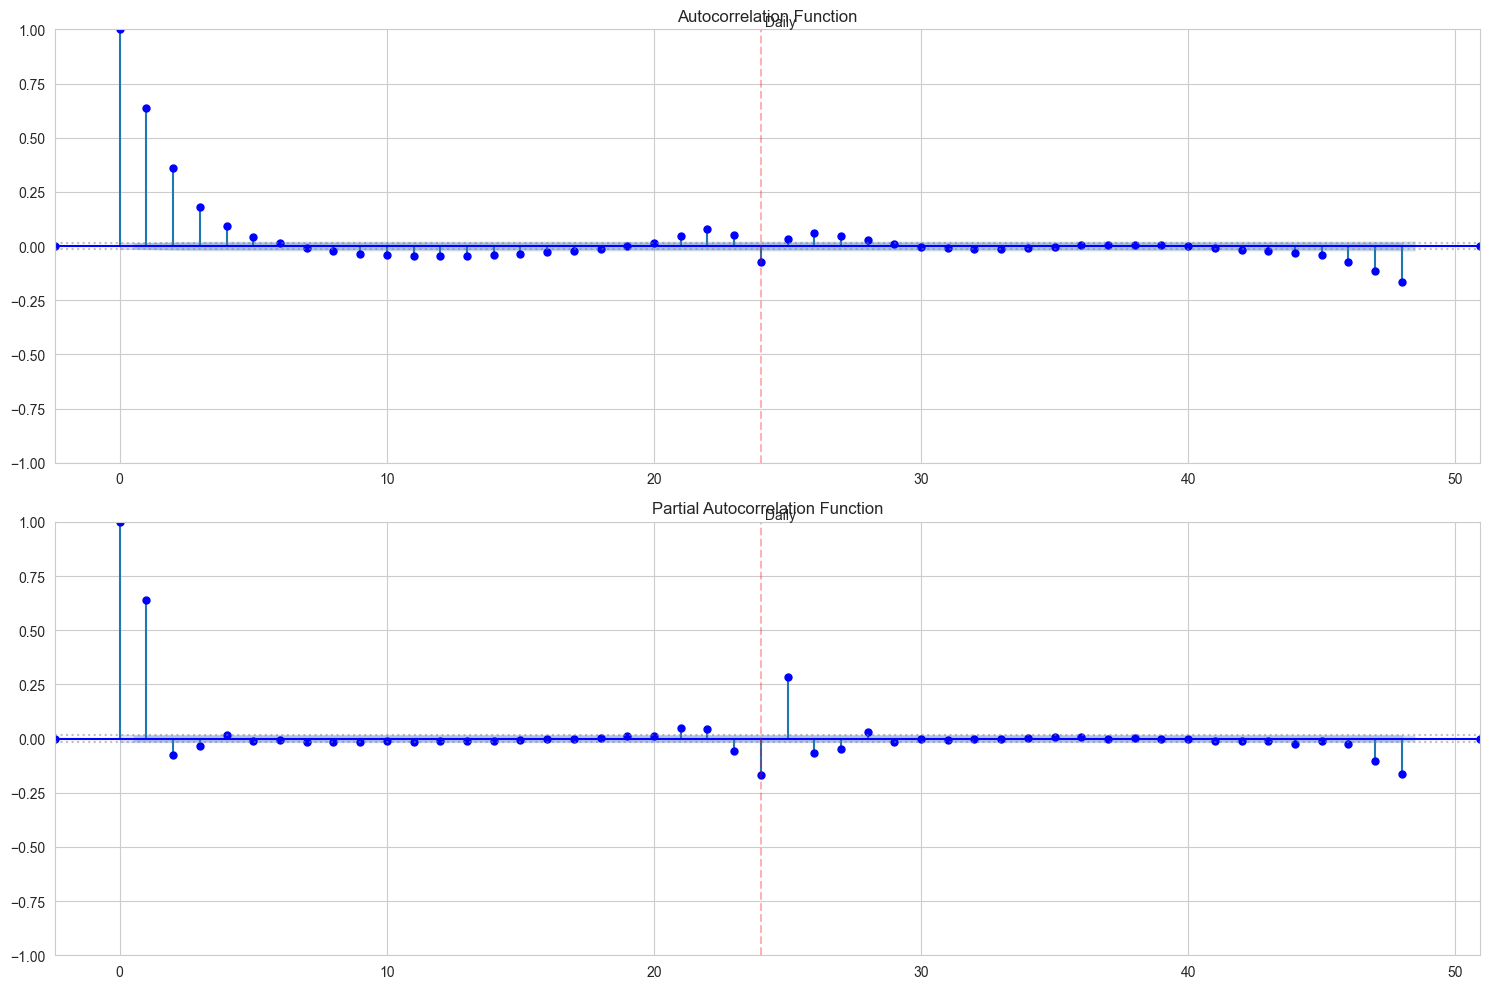


Both Differences Combined:


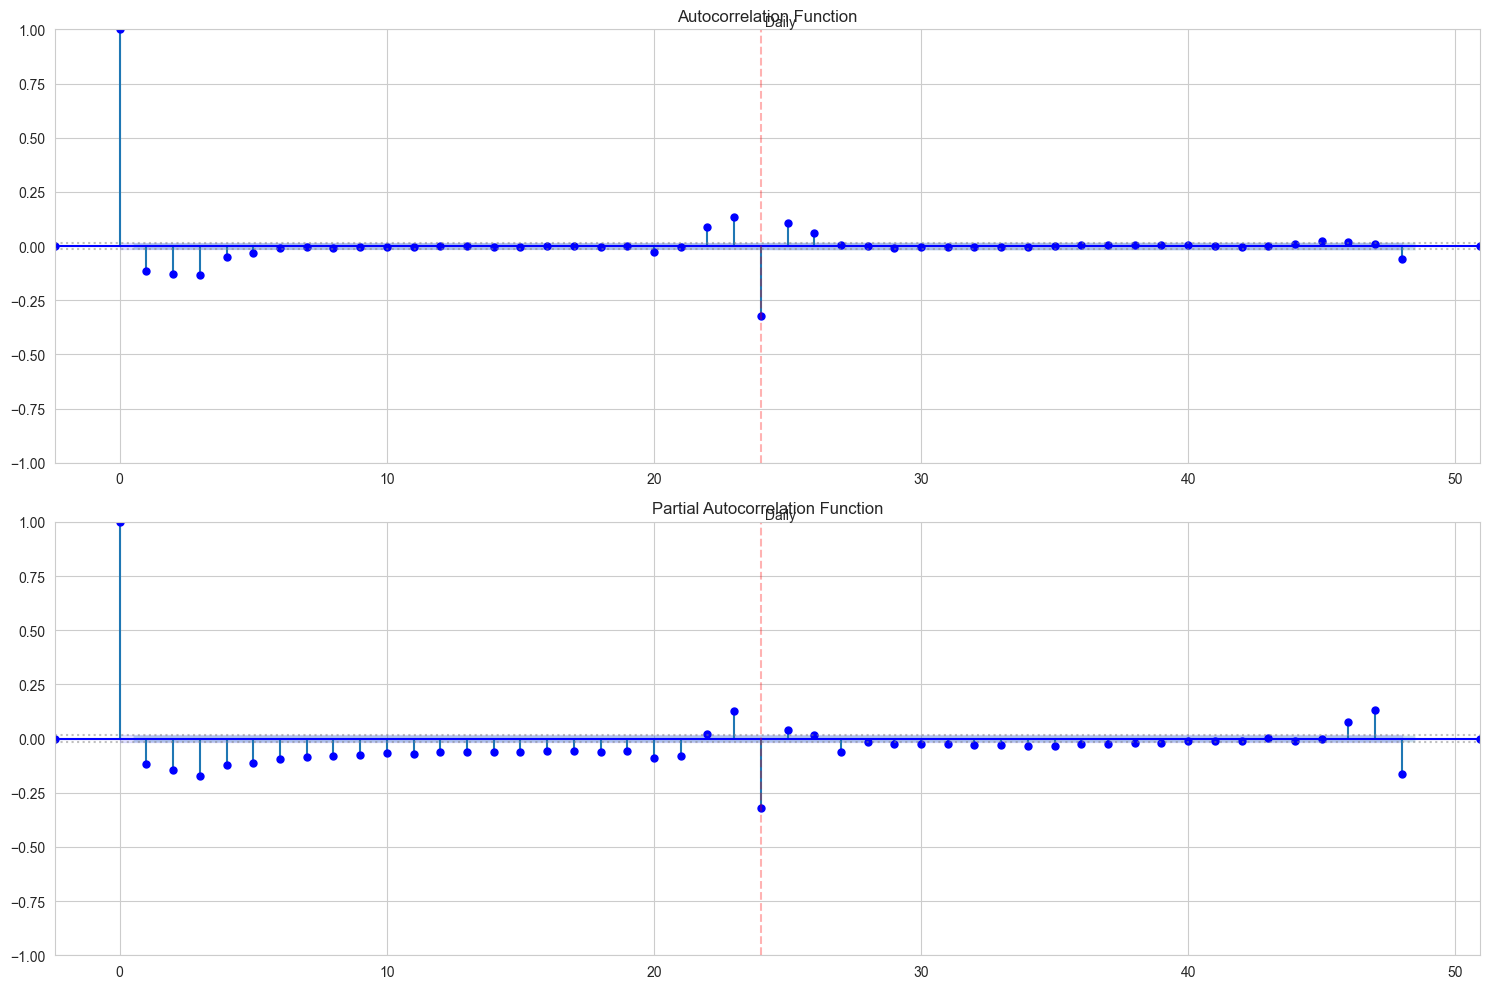

In [11]:
# Cell 9 - Updated ACF and PACF Analysis

def plot_advanced_acf_pacf(series, max_lags=None, periods=None):
    """
    Plot ACF and PACF with multiple lag ranges and highlighted seasonal periods
    
    Parameters:
    - series: time series data
    - max_lags: maximum number of lags to show
    - periods: list of tuples (period, label) to highlight
    """
    if max_lags is None:
        max_lags = 24 * 8  # Show 8 days by default
    
    if periods is None:
        periods = [
            (24, "Daily"),
            (24 * 7, "Weekly"),
            (24 * 30, "Monthly")
        ]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot ACF
    plot_acf(series.dropna(), lags=max_lags, ax=ax1, alpha=0.05, 
            markersize=5, c='blue', marker='o')
    ax1.set_title('Autocorrelation Function')
    
    # Plot PACF
    plot_pacf(series.dropna(), lags=max_lags, ax=ax2, alpha=0.05, 
             markersize=5, c='blue', marker='o')
    ax2.set_title('Partial Autocorrelation Function')
    
    # Add vertical lines for seasonal periods
    for period, label in periods:
        if period <= max_lags:
            for ax in [ax1, ax2]:
                ax.axvline(x=period, color='red', linestyle='--', alpha=0.3)
                ax.text(period, ax.get_ylim()[1], f' {label}', 
                       rotation=0, verticalalignment='bottom')
    
    # Enhance confidence intervals visibility
    for ax in [ax1, ax2]:
        # Get the confidence intervals (approximately at y = ±2/√T)
        ci = 2/np.sqrt(len(series))
        ax.axhline(y=ci, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=-ci, color='gray', linestyle=':', alpha=0.5)
        ax.fill_between(range(max_lags + 1), -ci, ci, color='blue', alpha=0.1)
    
    plt.tight_layout()
    plt.show()

# Plot for different ranges
print("=== ACF and PACF Analysis of Original Series ===")
print("\nShort-term patterns (2 days):")
plot_advanced_acf_pacf(df['X'], max_lags=48)

print("\nMedium-term patterns (2 weeks):")
plot_advanced_acf_pacf(df['X'], max_lags=24*14)

print("\nLong-term patterns (1 month):")
plot_advanced_acf_pacf(df['X'], max_lags=24*30)

# Also show the differenced series
print("\n=== ACF and PACF Analysis of Differenced Series ===")
diff1 = df['X'].diff().dropna()
seasonal_diff = df['X'].diff(24).dropna()
both_diff = seasonal_diff.diff().dropna()

print("\nFirst Difference:")
plot_advanced_acf_pacf(diff1, max_lags=48)

print("\nSeasonal Difference (24 hours):")
plot_advanced_acf_pacf(seasonal_diff, max_lags=48)

print("\nBoth Differences Combined:")
plot_advanced_acf_pacf(both_diff, max_lags=48)

# ARIMA Simple

In [228]:
# Cell 10 - ARIMA Data Preparation
from tqdm import tqdm  
import warnings
warnings.filterwarnings('ignore')

def prepare_arima_data(df):
    """
    Prepare data for ARIMA modeling, ensuring proper time boundaries
    """
    # Explicitly set the training period
    training_end = '2016-11-30 23:00:00'
    
    # Get training data (up to Nov 2016)
    train_data = df[:'2016-11-30 23:00:00'].copy()
    
    print(f"Training data range: {train_data.index.min()} to {train_data.index.max()}")
    print(f"Training data shape: {train_data.shape}")
    
    return train_data

# Prepare the data
train_data = prepare_arima_data(df)

Training data range: 2015-01-01 00:00:00 to 2016-11-30 23:00:00
Training data shape: (16800, 3)


In [229]:
# Cell 11 - ARIMA Model Development
def develop_arima_model(train_data):
    """
    Develop ARIMA model using data through November 2016
    """
    print("=== ARIMA Model Development ===")

    # Convert to pandas Series with frequency
    y = train_data['X'].astype(float)
    y.index = pd.DatetimeIndex(y.index).to_period('H')

    # Define model configurations
    models_to_try = [
        ((2,1,2), (1,1,1,24)),  # Our main model
        ((1,1,1), (0,1,1,24)),  # Simpler alternative
        ((0,1,1), (0,1,1,24))   # Airline model
    ]

    best_aic = float('inf')
    best_model = None
    best_order = None
    best_seasonal_order = None

    print("\nTrying specific model configurations...")
    for order, seasonal_order in tqdm(models_to_try, desc="Testing Models"):
        try:
            print(f"\nFitting ARIMA{order}{seasonal_order}")
            model = ARIMA(y,
                         order=order,
                         seasonal_order=seasonal_order,
                         enforce_stationarity=False,
                         enforce_invertibility=True)
            
            results = model.fit(method='innovations_mle')
            current_aic = results.aic

            print(f"AIC: {current_aic:.2f}")

            if current_aic < best_aic:
                best_aic = current_aic
                best_model = results
                best_order = order
                best_seasonal_order = seasonal_order
                
        except Exception as e:
            print(f"Error fitting ARIMA{order}{seasonal_order}:")
            print(f"Error message: {str(e)}")
            continue

    print("\nBest Model Configuration:")
    print(f"Order: {best_order}")
    print(f"Seasonal Order: {best_seasonal_order}")
    print(f"AIC: {best_aic}")
    
    return best_model

# Train the model
arima_model = develop_arima_model(train_data)
print("\nModel Summary:")
print(arima_model.summary())

=== ARIMA Model Development ===

Trying specific model configurations...


Testing Models:   0%|          | 0/3 [00:00<?, ?it/s]


Fitting ARIMA(2, 1, 2)(1, 1, 1, 24)


Testing Models:  33%|███▎      | 1/3 [00:15<00:30, 15.42s/it]

AIC: -78542.57

Fitting ARIMA(1, 1, 1)(0, 1, 1, 24)


Testing Models:  67%|██████▋   | 2/3 [00:29<00:14, 14.44s/it]

AIC: -76743.87

Fitting ARIMA(0, 1, 1)(0, 1, 1, 24)


Testing Models: 100%|██████████| 3/3 [00:38<00:00, 12.79s/it]

AIC: -74246.87

Best Model Configuration:
Order: (2, 1, 2)
Seasonal Order: (1, 1, 1, 24)
AIC: -78542.56996948938



Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16800
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               39278.285
Date:                            Sat, 11 Jan 2025   AIC                         -78542.570
Time:                                    19:46:18   BIC                         -78488.488
Sample:                                01-01-2015   HQIC                        -78524.723
                                     - 11-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4537      0.049     29.820      0.000       1.358       1.549
ar.L2         -0.56

In [230]:
# Cell 12 - Generate December 2016 Forecasts
def generate_december_forecasts(model):
    """
    Generate forecasts for December 2016
    """
    # Generate forecasts for December 2016 (744 hours)
    forecast = model.forecast(steps=744)
    
    # Create forecast dates
    forecast_dates = pd.date_range(
        start='2016-12-01',
        end='2016-12-31 23:00:00',
        freq='H'
    )
    
    # Create DataFrame with forecasts
    forecast_df = pd.DataFrame({
        'DateTime': forecast_dates,
        'ARIMA': np.maximum(forecast, 0)  # Ensure non-negative values
    })
    
    return forecast_df

# Generate forecasts
december_forecasts = generate_december_forecasts(arima_model)

In [231]:
# Cell 13 - Save and Verify Forecasts
from datetime import datetime
import os

# Save forecasts
submission_date = datetime.now().strftime('%Y%m%d')
submission_filename = f'arima_simple.csv'

if os.path.exists(submission_filename):
    # Load existing file if it exists
    submission_df = pd.read_csv(submission_filename)
    submission_df['ARIMA'] = december_forecasts['ARIMA']
else:
    # Create new file
    submission_df = december_forecasts

submission_df.to_csv(submission_filename, index=False)
print(f"\nARIMA forecasts saved to {submission_filename}")

# Verify saved file
verify_df = pd.read_csv(submission_filename)
print("\nVerification of saved forecasts:")
print("\nFirst few rows:")
print(verify_df.head())
print("\nLast few rows:")
print(verify_df.tail())
print("\nShape:", verify_df.shape)
print("\nColumns:", verify_df.columns.tolist())
print("\nSummary statistics for ARIMA forecasts:")
print(verify_df['ARIMA'].describe())


ARIMA forecasts saved to 902064_20250111.csv

Verification of saved forecasts:

First few rows:
              DateTime     ARIMA
0  2016-12-01 00:00:00  0.005477
1  2016-12-01 01:00:00  0.003475
2  2016-12-01 02:00:00  0.004081
3  2016-12-01 03:00:00  0.009502
4  2016-12-01 04:00:00  0.026046

Last few rows:
                DateTime     ARIMA
739  2016-12-31 19:00:00  0.028061
740  2016-12-31 20:00:00  0.023993
741  2016-12-31 21:00:00  0.021505
742  2016-12-31 22:00:00  0.015833
743  2016-12-31 23:00:00  0.008877

Shape: (744, 2)

Columns: ['DateTime', 'ARIMA']

Summary statistics for ARIMA forecasts:
count    744.000000
mean       0.043051
std        0.034704
min        0.001777
25%        0.020327
50%        0.037080
75%        0.051804
max        0.137606
Name: ARIMA, dtype: float64


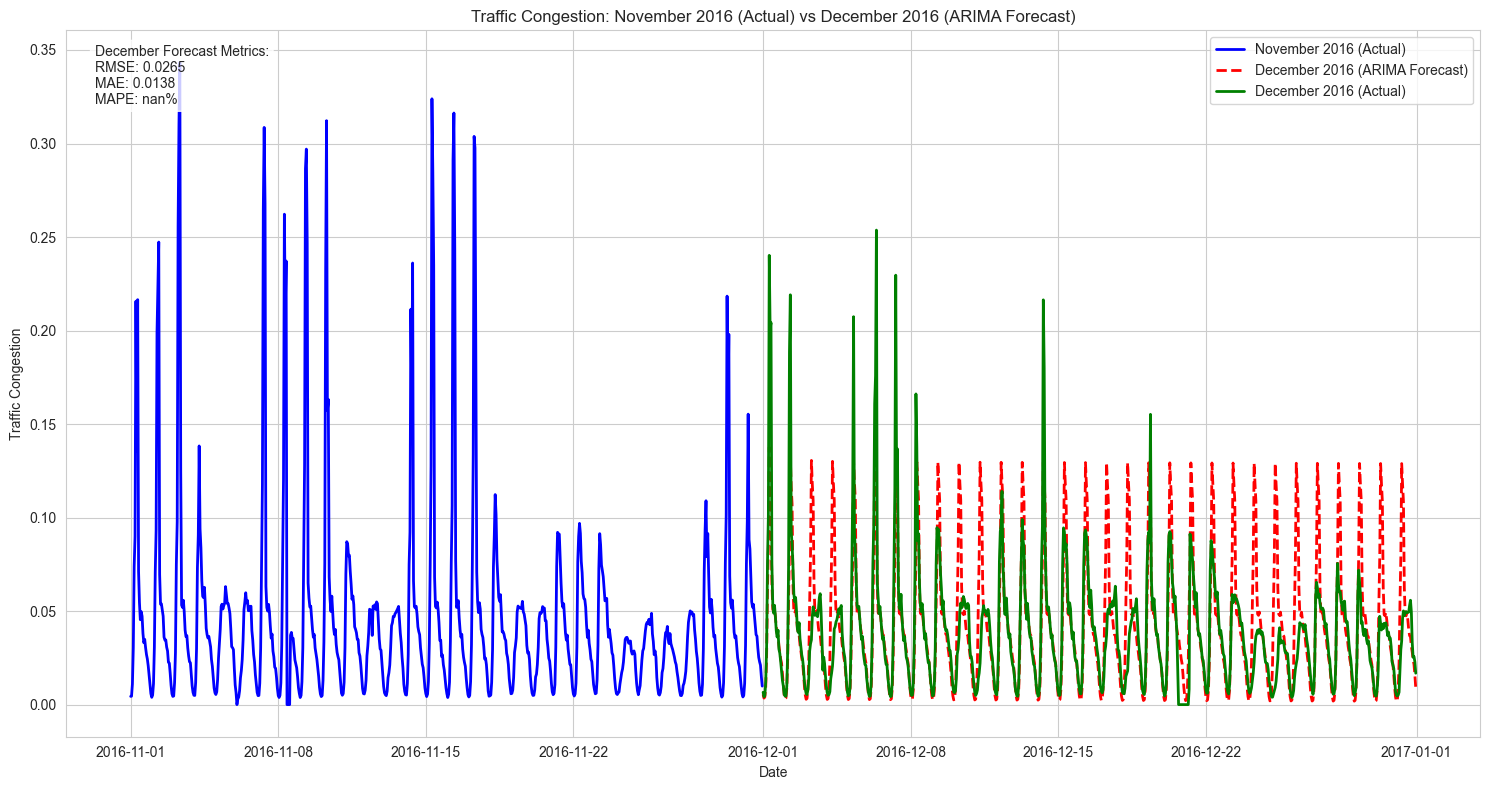

In [232]:
# Cell 14 - Plot December Forecasts with November Actuals
plt.figure(figsize=(15, 8))

# Plot November actual data
november_data = df['2016-11-01':'2016-11-30']
plt.plot(november_data.index, november_data['X'], 
         label='November 2016 (Actual)', 
         color='blue', linewidth=2)

# Plot December forecasts
plt.plot(december_forecasts['DateTime'], december_forecasts['ARIMA'],
         label='December 2016 (ARIMA Forecast)',
         color='red', linestyle='--', linewidth=2)

# If solution data is available, plot it
try:
    solution_path = os.path.join('solution', 't2_solution.csv')
    if os.path.exists(solution_path):
        solution_data = pd.read_csv(solution_path)
        solution_data['datetime'] = pd.to_datetime(solution_data['DateTime'])
        plt.plot(solution_data['datetime'], solution_data['X'],
                label='December 2016 (Actual)',
                color='green', linewidth=2)
        
        # Calculate error metrics
        dec_rmse = np.sqrt(mean_squared_error(solution_data['X'], december_forecasts['ARIMA']))
        dec_mae = mean_absolute_error(solution_data['X'], december_forecasts['ARIMA'])
        dec_mape = np.mean(np.abs((solution_data['X'] - december_forecasts['ARIMA']) / solution_data['X'])) * 100
        
        metrics_text = f'December Forecast Metrics:\nRMSE: {dec_rmse:.4f}\nMAE: {dec_mae:.4f}\nMAPE: {dec_mape:.2f}%'
        plt.text(0.02, 0.98, metrics_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
except Exception as e:
    print(f"Note: Could not load solution data: {str(e)}")

plt.title('Traffic Congestion: November 2016 (Actual) vs December 2016 (ARIMA Forecast)')
plt.xlabel('Date')
plt.ylabel('Traffic Congestion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Cell 12 - ARIMA Model Diagnostics
def perform_arima_diagnostics(model):
    """
    Perform diagnostic tests for ARIMA model
    """
    print("=== ARIMA Model Diagnostics ===")

    residuals = model.resid
    
    # Create diagnostic plots
    fig = plt.figure(figsize=(15, 15))

    # 1. Residuals over time
    ax1 = plt.subplot(411)
    plt.plot(residuals.index, residuals, 'b.', alpha=0.5, markersize=2)
    plt.plot(residuals.index, pd.Series(0, index=residuals.index), 'r--')
    plt.title('Residuals over Time')
    plt.grid(True, alpha=0.2)

    # 2. ACF of residuals
    ax2 = plt.subplot(412)
    plot_acf(residuals, lags=50, ax=ax2, alpha=0.05,
             title="ACF of Residuals",
             markersize=3)
    plt.grid(True, alpha=0.2)

    # 3. PACF of residuals
    ax3 = plt.subplot(413)
    plot_pacf(residuals, lags=50, ax=ax3, alpha=0.05,
              title="PACF of Residuals",
              markersize=3)
    plt.grid(True, alpha=0.2)

    # 4. Q-Q plot
    ax4 = plt.subplot(414)
    stats.probplot(residuals, dist="norm", plot=plt)
    ax4.set_title("Q-Q plot of residuals")
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nResidual Statistics:")
    print(f"Mean: {residuals.mean():.4f}")
    print(f"Std Dev: {residuals.std():.4f}")
    print(f"Skewness: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

In [15]:
# Cell 13 - ARIMA Forecasting (with non-negative constraints)
def generate_arima_forecasts(model, train_data, val_data, forecast_horizon=744):
    """
    Generate and evaluate ARIMA forecasts with non-negative constraints
    """
    print("=== ARIMA Forecasting ===")

    # In-sample predictions
    in_sample_pred = model.get_prediction(start=0)
    in_sample_mean = np.maximum(in_sample_pred.predicted_mean, 0)  # Force non-negative

    # Validation set predictions
    val_pred = model.get_prediction(
        start=len(train_data), 
        end=len(train_data)+len(val_data)-1,
        dynamic=False
    )
    val_mean = np.maximum(val_pred.predicted_mean, 0)  # Force non-negative
    val_conf = val_pred.conf_int()
    val_conf.iloc[:, 0] = np.maximum(val_conf.iloc[:, 0], 0)  # Force non-negative lower bound

    # Future forecasts
    forecast = model.get_forecast(
        steps=forecast_horizon,
        alpha=0.05
    )
    forecast_mean = np.maximum(forecast.predicted_mean, 0)  # Force non-negative
    forecast_conf = forecast.conf_int()
    forecast_conf.iloc[:, 0] = np.maximum(forecast_conf.iloc[:, 0], 0)  # Force non-negative lower bound

    # Plot results
    plt.figure(figsize=(15, 10))

    # Plot training data
    plt.plot(train_data.index, train_data['X'], label='Training Data', alpha=0.7)

    # Plot validation data
    plt.plot(val_data.index, val_data['X'], label='Validation Data', color='green', alpha=0.7)

    # Plot validation predictions
    plt.plot(val_data.index, val_mean, label='Validation Predictions', color='red', linestyle='--')
    plt.fill_between(val_data.index,
                     val_conf.iloc[:, 0],
                     val_conf.iloc[:, 1],
                     color='red', alpha=0.1)

    # Plot forecasts
    forecast_index = pd.date_range(start=val_data.index[-1] + pd.Timedelta(hours=1),
                                 periods=forecast_horizon,
                                 freq='H')
    plt.plot(forecast_index, forecast_mean, label='ARIMA Forecasts', color='blue')
    plt.fill_between(forecast_index,
                     forecast_conf.iloc[:, 0],
                     forecast_conf.iloc[:, 1],
                     color='blue', alpha=0.1)

    plt.title('ARIMA Model Forecasts')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate error metrics (using non-negative predictions)
    val_rmse = np.sqrt(mean_squared_error(val_data['X'], val_mean))
    val_mae = mean_absolute_error(val_data['X'], val_mean)
    val_mape = np.mean(np.abs((val_data['X'] - val_mean) / val_data['X'])) * 100

    print("\nValidation Set Metrics:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"MAE: {val_mae:.4f}")
    print(f"MAPE: {val_mape:.4f}%")

    return forecast_mean, forecast_conf, val_mean, val_conf

Starting ARIMA modeling pipeline...
=== ARIMA Model Development ===

Trying specific model configurations...


Testing Models:   0%|          | 0/4 [00:00<?, ?it/s]


Fitting ARIMA(1, 1, 1)(0, 1, 1, 24)


Testing Models:  25%|██▌       | 1/4 [00:11<00:35, 11.98s/it]

AIC: -73516.91

Fitting ARIMA(1, 1, 1)(1, 1, 0, 24)


Testing Models:  50%|█████     | 2/4 [00:15<00:14,  7.28s/it]

AIC: -69838.60

Fitting ARIMA(2, 1, 2)(1, 1, 1, 24)
AIC: -75161.10


Testing Models:  75%|███████▌  | 3/4 [00:55<00:21, 21.86s/it]


Fitting ARIMA(0, 1, 1)(0, 1, 1, 24)


Testing Models: 100%|██████████| 4/4 [01:00<00:00, 15.08s/it]

AIC: -71106.10

Best Model Configuration:
Order: (2, 1, 2)
Seasonal Order: (1, 1, 1, 24)
AIC: -75161.10112524132

Model Summary:


                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37587.551
Date:                            Sat, 11 Jan 2025   AIC                         -75161.101
Time:                                    11:02:04   BIC                         -75107.337
Sample:                                01-01-2015   HQIC                        -75143.319
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0280      0.055     18.858      0.000       0.921       1.135
ar.L2         -0.2997      0.038   

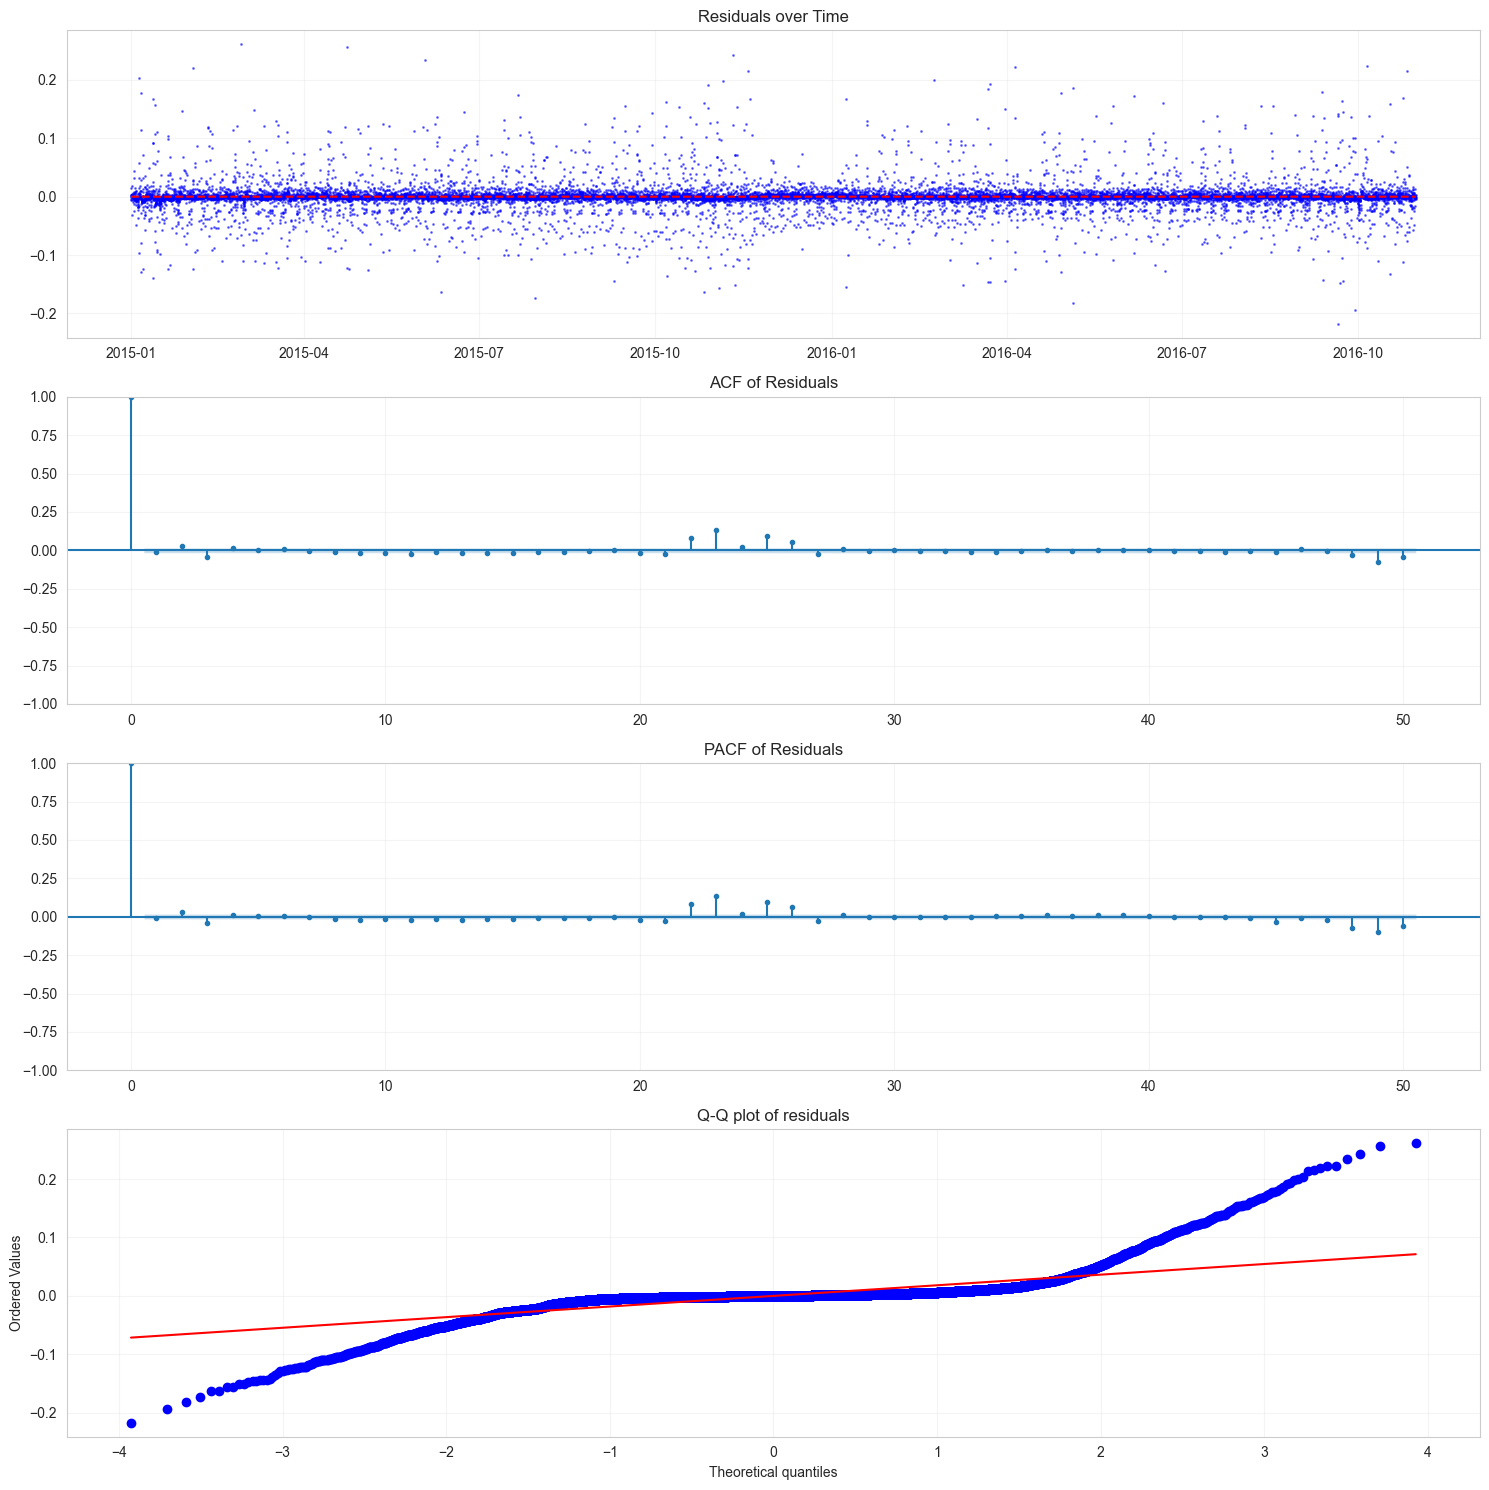


Residual Statistics:
Mean: -0.0001
Std Dev: 0.0231
Skewness: 1.2972
Kurtosis: 22.1946
=== ARIMA Forecasting ===


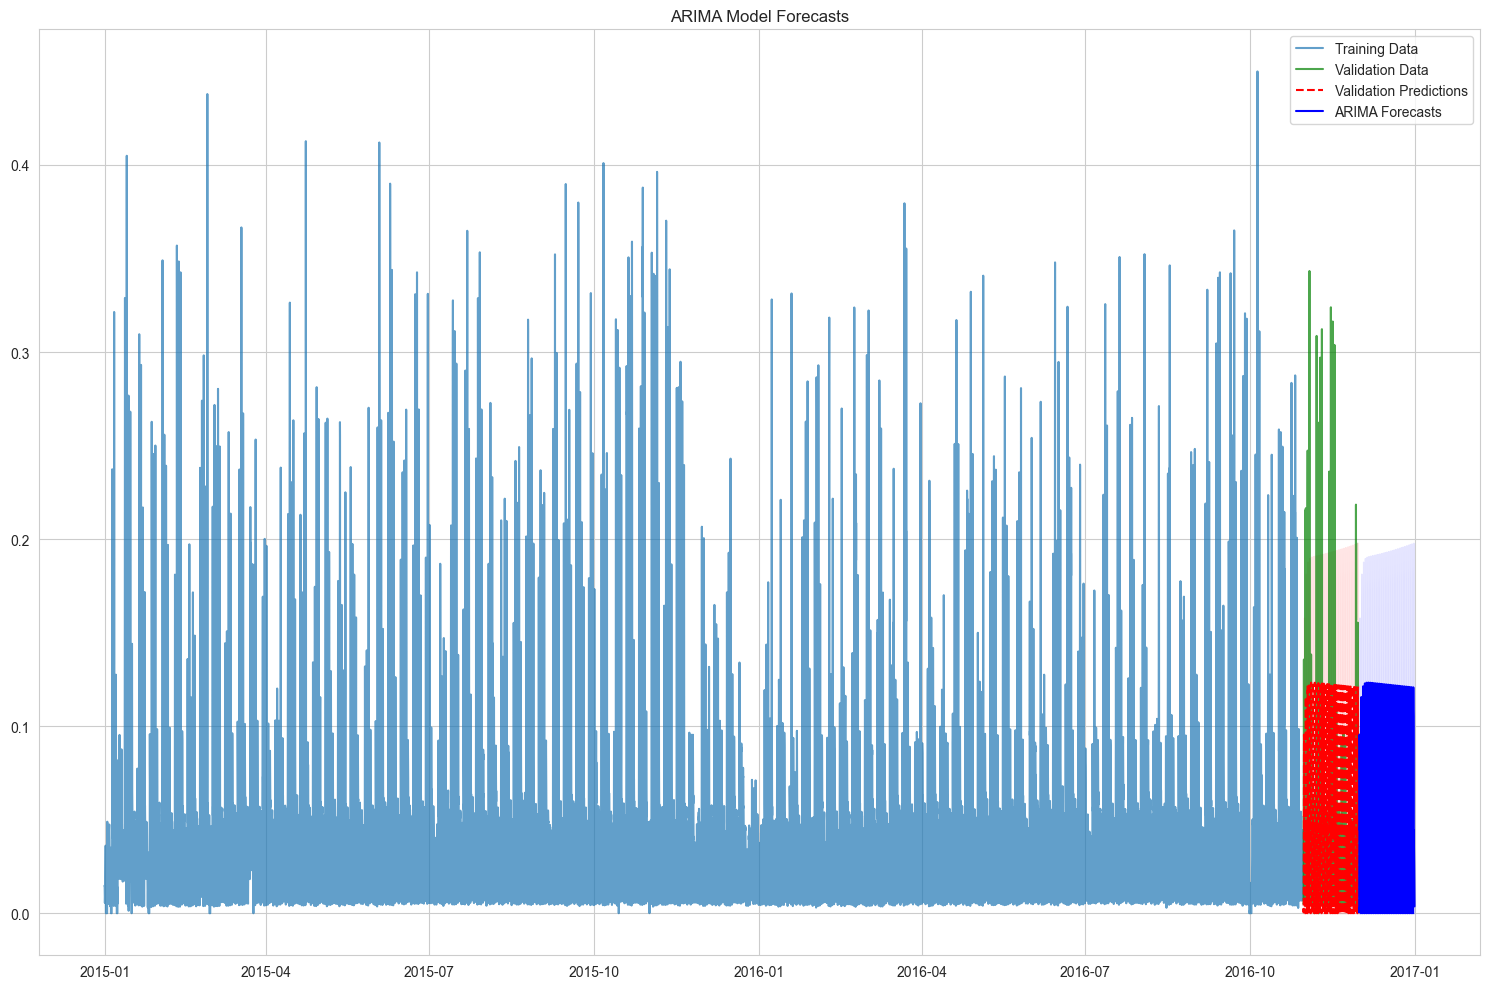


Validation Set Metrics:
RMSE: 0.0394
MAE: 0.0199
MAPE: inf%

ARIMA modeling pipeline completed!

Forecasts have been saved to 'arima_forecasts.csv'


In [16]:
# Cell 14 - Run ARIMA Pipeline
print("Starting ARIMA modeling pipeline...")

try:
    # First develop and train the model
    arima_model, best_order, best_seasonal_order = develop_arima_model(train_set)

    # Perform diagnostics
    perform_arima_diagnostics(arima_model)

    # Generate forecasts
    forecast_mean, forecast_conf, val_mean, val_conf = generate_arima_forecasts(arima_model, train_set, val_set)

    # Save forecasts to CSV
    forecast_df = pd.DataFrame({
        'datetime': pd.date_range(start=val_set.index[-1] + pd.Timedelta(hours=1),
                                periods=744,
                                freq='H'),
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.set_index('datetime', inplace=True)
    forecast_df.to_csv('arima_forecasts.csv')
    
    print("\nARIMA modeling pipeline completed!")
    print("\nForecasts have been saved to 'arima_forecasts.csv'")

except Exception as e:
    print(f"Error in ARIMA pipeline: {str(e)}")
    raise

Found existing forecasts, creating plot...


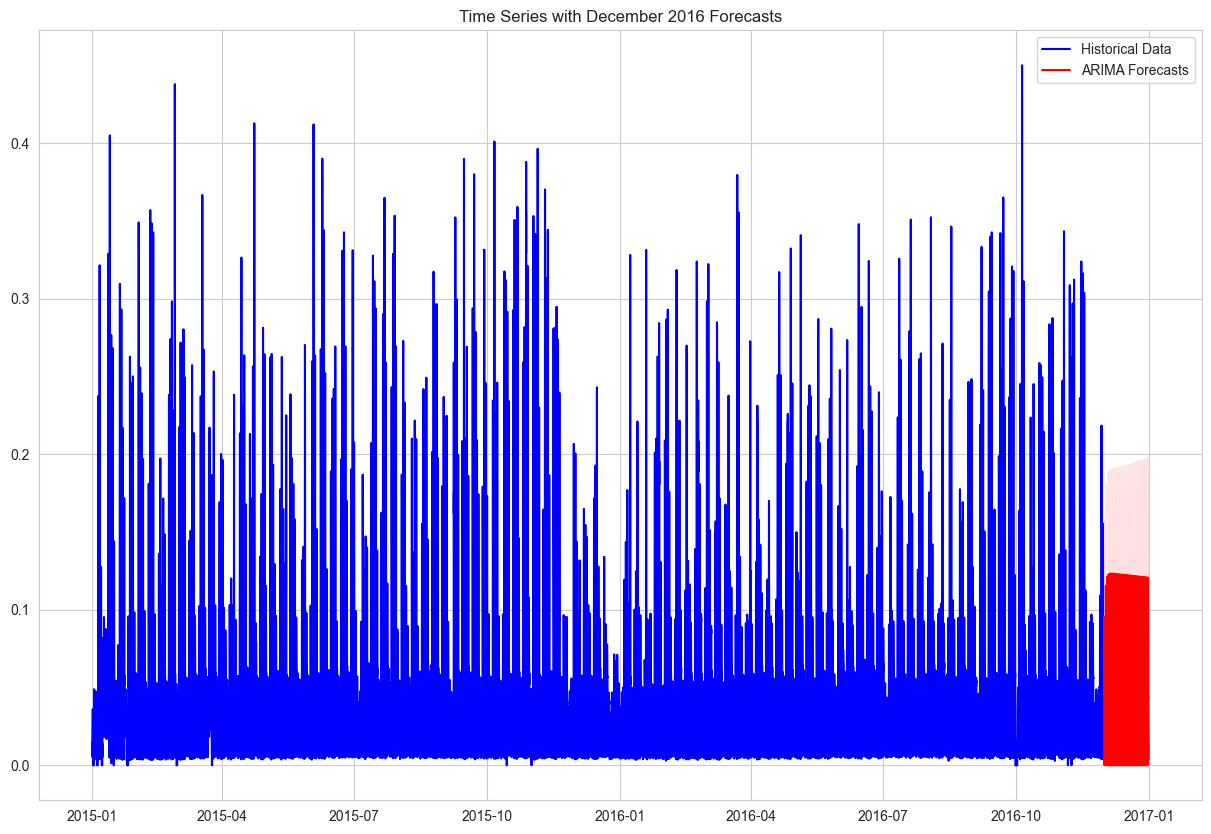

In [17]:
# Cell 15 - Create plot combining original data and forecasts

import os

def plot_with_forecasts(df, forecast_csv):
    """
    Plot original time series with forecasts appended
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Create plot
    plt.figure(figsize=(15, 10))
    
    # Plot original data until November 2016
    plt.plot(df.index, df['X'], label='Historical Data', color='blue')
    
    # Add forecasts as continuation
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'], 
             label='ARIMA Forecasts', color='red')
    
    # Add confidence intervals
    plt.fill_between(forecasts['datetime'],
                     forecasts['ARIMA_lower'],
                     forecasts['ARIMA_upper'],
                     color='red', alpha=0.1)
    
    plt.title('Time Series with December 2016 Forecasts')
    plt.legend()
    plt.grid(True)
    plt.show()

# First check if we have the forecasts CSV
if os.path.exists('arima_forecasts.csv'):
    print("Found existing forecasts, creating plot...")
    plot_with_forecasts(df, 'arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting forecasts...

Forecast Statistics:
Mean: 0.0382
Std Dev: 0.0336
Min: 0.0000
Max: 0.1233


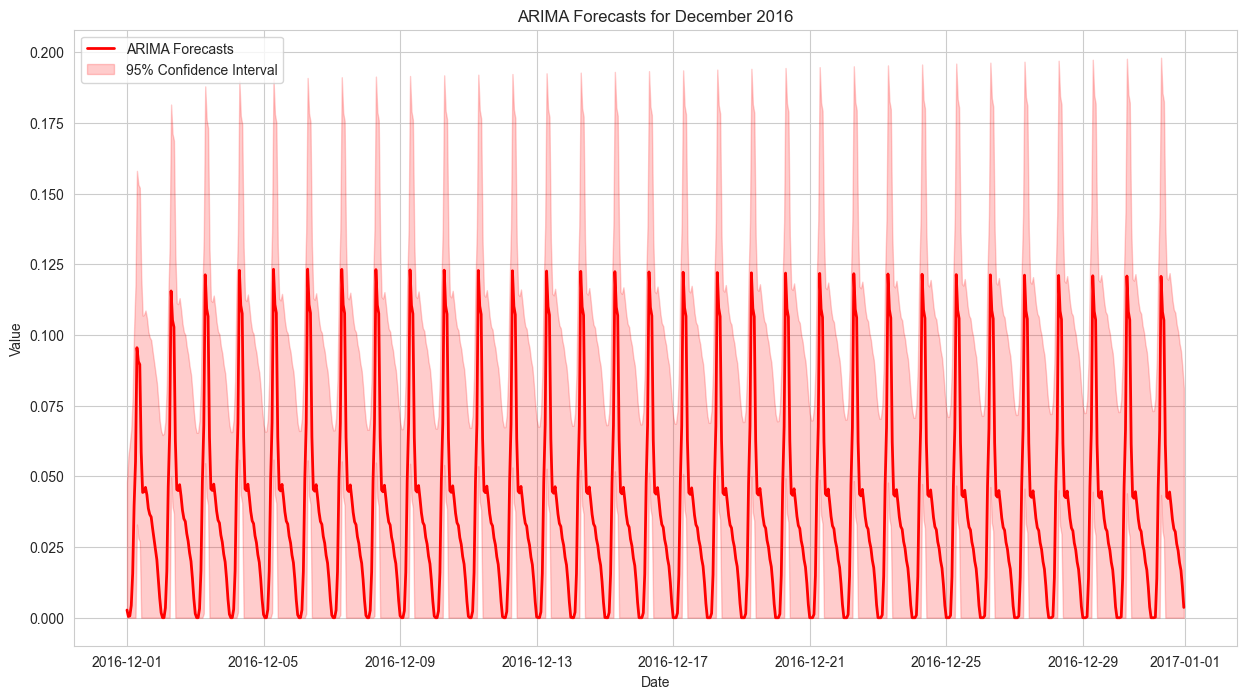

In [18]:
# Cell 16 - Plot just the forecasted values
def plot_forecasts_only(forecast_csv):
    """
    Plot only the forecasted values for December 2016
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot forecasts
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='ARIMA Forecasts', color='red', linewidth=2)
    
    # Add confidence intervals
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='red', alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('ARIMA Forecasts for December 2016')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print some statistics about the forecasts
    print("\nForecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    plt.show()

if os.path.exists('arima_forecasts.csv'):
    print("Plotting forecasts...")
    plot_forecasts_only('arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting November comparison...

November Statistics:
Mean: 0.0463
Std Dev: 0.0537
Min: 0.0000
Max: 0.3433

December Forecast Statistics:
Mean: 0.0382
Std Dev: 0.0336
Min: 0.0000
Max: 0.1233


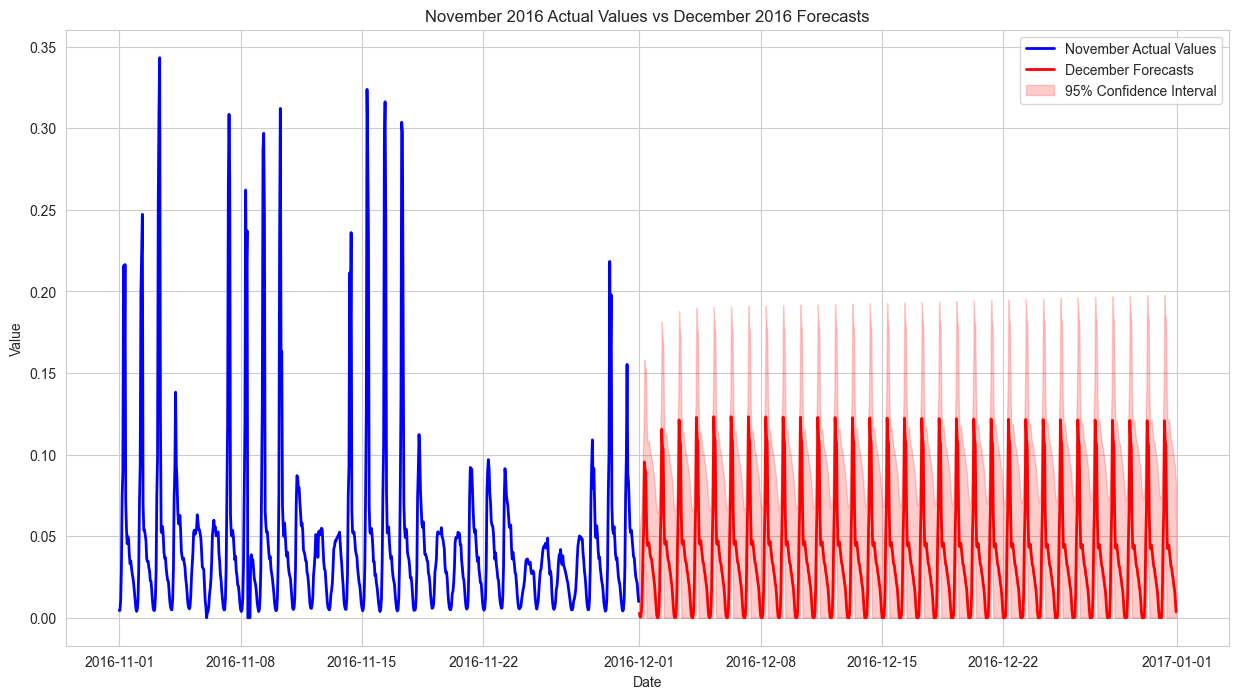

In [19]:
# Cell 17 - Plot November actuals and December forecasts
def plot_nov_dec_comparison(df, forecast_csv):
    """
    Plot November 2016 actual values and December 2016 forecasts
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Get November data (last month before forecasts)
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot November actual values
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values', color='blue', linewidth=2)
    
    # Plot December forecasts
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='December Forecasts', color='red', linewidth=2)
    
    # Add confidence intervals for forecasts
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='red', alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('November 2016 Actual Values vs December 2016 Forecasts')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print statistics for comparison
    print("\nNovember Statistics:")
    print(f"Mean: {november_data['X'].mean():.4f}")
    print(f"Std Dev: {november_data['X'].std():.4f}")
    print(f"Min: {november_data['X'].min():.4f}")
    print(f"Max: {november_data['X'].max():.4f}")
    
    print("\nDecember Forecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    plt.show()

if os.path.exists('arima_forecasts.csv'):
    print("Plotting November comparison...")
    plot_nov_dec_comparison(df, 'arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting complete comparison...

Forecast columns: ['datetime', 'ARIMA_forecast', 'ARIMA_lower', 'ARIMA_upper']

Solution columns: ['DateTime', 'Date', 'Hour', 'X']

November Statistics:
Mean: 0.0463
Std Dev: 0.0537
Min: 0.0000
Max: 0.3433

December Forecast Statistics:
Mean: 0.0382
Std Dev: 0.0336
Min: 0.0000
Max: 0.1233

December Real Values Statistics:
Mean: 0.0392
Std Dev: 0.0331
Min: 0.0000
Max: 0.2537

Forecast Error Metrics:
MAE: 0.0155
RMSE: 0.0263
MAPE: nan%


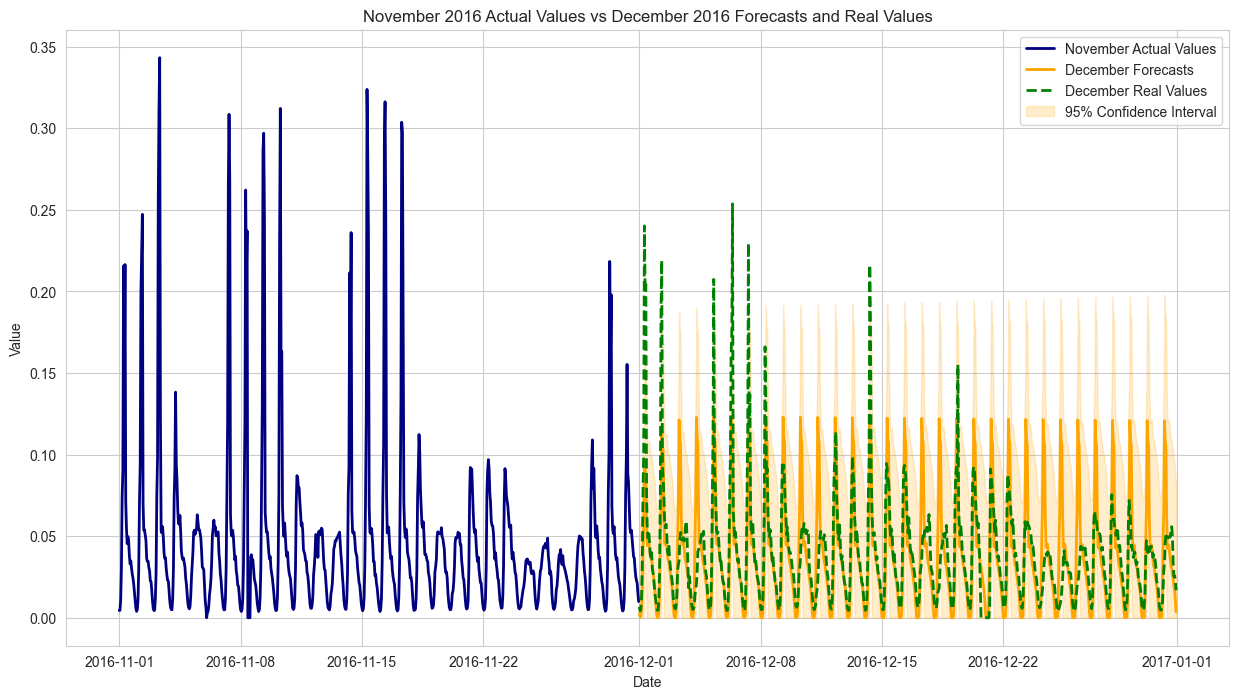

In [20]:
# Cell 18 - Plot November actuals, December forecasts, and December real values
def plot_complete_comparison(df, forecast_csv, solution_path):
    """
    Plot November 2016 actual values, December 2016 forecasts, and December 2016 real values
    Colors chosen for colorblind visibility:
    - November actuals: Dark Blue
    - December forecasts: Orange
    - December real values: Green
    - Confidence intervals: Light Orange shading
    """
    # Read the forecasts and solution with debug prints
    forecasts = pd.read_csv(forecast_csv)
    print("\nForecast columns:", forecasts.columns.tolist())
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Read and inspect solution file
    solution = pd.read_csv(solution_path)
    print("\nSolution columns:", solution.columns.tolist())
    
    # Create datetime index for solution based on December 2016
    solution.index = pd.date_range(start='2016-12-01', 
                                 periods=len(solution), 
                                 freq='H')
    
    # Get November data
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot November actual values (Dark Blue)
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values', 
             color='#000080',  # Dark Blue
             linewidth=2)
    
    # Plot December forecasts (Orange)
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='December Forecasts', 
             color='#FFA500',  # Orange
             linewidth=2)
    
    # Plot December real values (Green) - assuming 'X' is the column name in solution
    plt.plot(solution.index, solution['X'],
             label='December Real Values', 
             color='#008000',  # Green
             linewidth=2,
             linestyle='--')
    
    # Add confidence intervals for forecasts (Light Orange shading)
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',  # Orange
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('November 2016 Actual Values vs December 2016 Forecasts and Real Values')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print statistics for comparison
    print("\nNovember Statistics:")
    print(f"Mean: {november_data['X'].mean():.4f}")
    print(f"Std Dev: {november_data['X'].std():.4f}")
    print(f"Min: {november_data['X'].min():.4f}")
    print(f"Max: {november_data['X'].max():.4f}")
    
    print("\nDecember Forecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    print("\nDecember Real Values Statistics:")
    print(f"Mean: {solution['X'].mean():.4f}")
    print(f"Std Dev: {solution['X'].std():.4f}")
    print(f"Min: {solution['X'].min():.4f}")
    print(f"Max: {solution['X'].max():.4f}")
    
    # Calculate and print error metrics between forecasts and real values
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    mape = np.mean(np.abs((solution['X'] - forecasts['ARIMA_forecast']) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts.csv') and os.path.exists(solution_path):
    print("Plotting complete comparison...")
    plot_complete_comparison(df, 'arima_forecasts.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

## ARIMA Advanced - SARIMAX with Christmas

In [21]:
# # Cell 19 - More Efficient Seasonal Features
# def create_efficient_features(dates):
#     """
#     Create efficient features for both daily and weekly patterns
#     """
#     features = pd.DataFrame(index=dates)
    
#     # Hour of day (0-23) as cyclical features
#     hours = 24
#     features['hour_sin'] = np.sin(2 * np.pi * dates.hour / hours)
#     features['hour_cos'] = np.cos(2 * np.pi * dates.hour / hours)
    
#     # Day of week (0-6) as cyclical features
#     days = 7
#     features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek / days)
#     features['day_cos'] = np.cos(2 * np.pi * dates.dayofweek / days)
    
#     # Christmas evening indicator
#     christmas_evenings = ((dates.day.isin([25, 26])) & 
#                          (dates.hour.isin(range(20, 24))) |
#                          (dates.day.isin([26, 27])) & 
#                          (dates.hour.isin(range(0, 6))))
#     features['christmas_evening'] = christmas_evenings.astype(int)
    
#     return features

In [22]:
# # Cell 20 - Efficient ARIMA Model
# def develop_efficient_seasonal_arima(train_data):
#     """
#     Develop ARIMA model with daily seasonality and external regressors for weekly patterns
#     """
#     print("=== Efficient Seasonal ARIMA Model Development ===")

#     # Prepare the target variable
#     y = train_data['X'].astype(float)
#     y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
#     # Create efficient features
#     exog_train = create_efficient_features(y.index)
#     print(f"\nIncluded features: {exog_train.columns.tolist()}")
    
#     try:
#         # Fit model with daily seasonality and external regressors
#         model = ARIMA(y,
#                      order=(2, 1, 2),        # Regular ARIMA components
#                      seasonal_order=(1, 1, 1, 24),  # Daily seasonality
#                      exog=exog_train,        # Weekly patterns through cyclical features
#                      enforce_stationarity=False,
#                      enforce_invertibility=True)
        
#         results = model.fit()
#         print("\nModel Summary:")
#         print(results.summary())
        
#         return results
        
#     except Exception as e:
#         print(f"Error fitting model:")
#         print(f"Error message: {str(e)}")
#         raise

In [23]:
# # Cell 21 - Efficient Forecast Generation
# def generate_efficient_forecasts(model, train_data, forecast_horizon=744):
#     """
#     Generate forecasts efficiently
#     """
#     # Create forecast dates
#     forecast_start = train_data.index[-1] + pd.Timedelta(hours=1)
#     forecast_dates = pd.date_range(forecast_start, periods=forecast_horizon, freq='H')
    
#     # Create features for forecast period
#     exog_forecast = create_efficient_features(forecast_dates)
    
#     # Generate forecasts
#     forecasts = model.forecast(steps=forecast_horizon, exog=exog_forecast)
#     forecasts = np.maximum(forecasts, 0)  # Ensure non-negative
    
#     # Get confidence intervals
#     conf_int = model.get_forecast(steps=forecast_horizon, exog=exog_forecast).conf_int()
#     conf_int.iloc[:, 0] = np.maximum(conf_int.iloc[:, 0], 0)  # Ensure non-negative lower bound
    
#     return forecasts, conf_int, forecast_dates

In [ ]:
# # Cell 22 - Run Efficient Pipeline
# print("Starting Efficient ARIMA modeling pipeline...")

# try:
#     # Train the model
#     arima_model = develop_efficient_seasonal_arima(train_set)
    
#     # Generate forecasts
#     forecast_mean, forecast_conf, forecast_dates = generate_efficient_forecasts(arima_model, train_set)
    
#     # Create and save forecast DataFrame
#     forecast_df = pd.DataFrame({
#         'datetime': forecast_dates,
#         'ARIMA_forecast': forecast_mean,
#         'ARIMA_lower': forecast_conf.iloc[:, 0],
#         'ARIMA_upper': forecast_conf.iloc[:, 1]
#     })
#     forecast_df.to_csv('arima_forecasts_efficient.csv', index=False)
    
#     print("\nEfficient ARIMA model completed!")
#     print("Forecasts saved to 'arima_forecasts_efficient.csv'")

# except Exception as e:
#     print(f"Error in pipeline: {str(e)}")
#     raise

Starting Efficient ARIMA modeling pipeline...
=== Efficient Seasonal ARIMA Model Development ===

Included features: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'christmas_evening']


c:\Users\alexc\GitHubRepos\Project_TimeSeries\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37345.423
Date:                            Sat, 11 Jan 2025   AIC                         -74666.846
Time:                                    11:05:30   BIC                         -74574.679
Sample:                                01-01-2015   HQIC                        -74636.363
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
hour_sin          -3.362e-09   6.73e-08     -0.050      0.960   -1.35e-07    1.29e-0

Plotting complete comparison...

Forecast Error Metrics:
MAE: 0.0167
RMSE: 0.0281


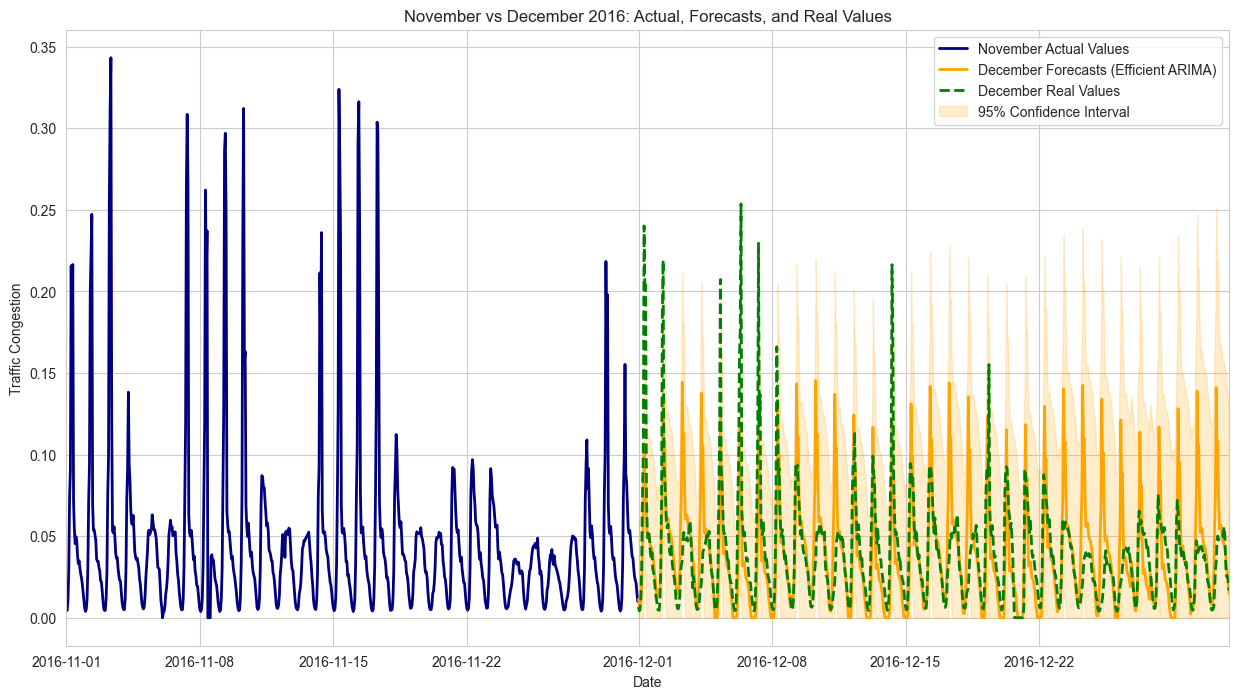

In [ ]:
# # Cell 23 - Plot Efficient Model Results
# def plot_complete_comparison_efficient(df, forecast_csv, solution_path):
#     """
#     Plot November actuals, December efficient forecasts, and December real values
#     Colors chosen for colorblind visibility:
#     - November actuals: Dark Blue
#     - December forecasts: Orange
#     - December real values: Green
#     - Confidence intervals: Light Orange shading
#     """
#     # Read data files
#     forecasts = pd.read_csv(forecast_csv)
#     forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
#     solution = pd.read_csv(solution_path)
#     solution.index = pd.date_range(start='2016-12-01', 
#                                  periods=len(solution), 
#                                  freq='H')
    
#     # Get November data
#     november_start = '2016-11-01'
#     november_end = '2016-11-30 23:00:00'
#     november_data = df.loc[november_start:november_end]
    
#     # Create plot with proper size and dpi for better readability
#     plt.figure(figsize=(15, 8), dpi=100)
    
#     # Plot November actual values (Dark Blue)
#     plt.plot(november_data.index, november_data['X'],
#              label='November Actual Values', 
#              color='#000080',  # Dark Blue
#              linewidth=2)
    
#     # Plot December forecasts (Orange) - making sure it's in December
#     plt.plot(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
#              forecasts['ARIMA_forecast'],
#              label='December Forecasts (Efficient ARIMA)', 
#              color='#FFA500',  # Orange
#              linewidth=2)
    
#     # Plot December real values (Green)
#     plt.plot(solution.index, solution['X'],
#              label='December Real Values', 
#              color='#008000',  # Green
#              linewidth=2,
#              linestyle='--')
    
#     # Add confidence intervals - making sure they're in December
#     plt.fill_between(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
#                     forecasts['ARIMA_lower'],
#                     forecasts['ARIMA_upper'],
#                     color='#FFA500',  # Orange
#                     alpha=0.2,
#                     label='95% Confidence Interval')
    
#     plt.title('November vs December 2016: Actual, Forecasts, and Real Values')
#     plt.ylabel('Traffic Congestion')
#     plt.xlabel('Date')
#     plt.legend()
#     plt.grid(True)
    
#     # Adjust x-axis to show the entire period clearly
#     plt.xlim(november_data.index[0], solution.index[-1])
    
#     # Print comparison statistics
#     print("\nForecast Error Metrics:")
#     mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
#     rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
#     print(f"MAE: {mae:.4f}")
#     print(f"RMSE: {rmse:.4f}")
    
#     plt.show()

# # Execute the plot
# solution_path = os.path.join('solution', 't2_solution.csv')
# if os.path.exists('arima_forecasts_efficient.csv') and os.path.exists(solution_path):
#     print("Plotting complete comparison...")
#     plot_complete_comparison_efficient(df, 'arima_forecasts_efficient.csv', solution_path)
# else:
#     print("Missing required files. Please check both forecast and solution files exist.")

Plotting separate comparisons...

Forecast Error Metrics:
MAE: 0.0167
RMSE: 0.0281


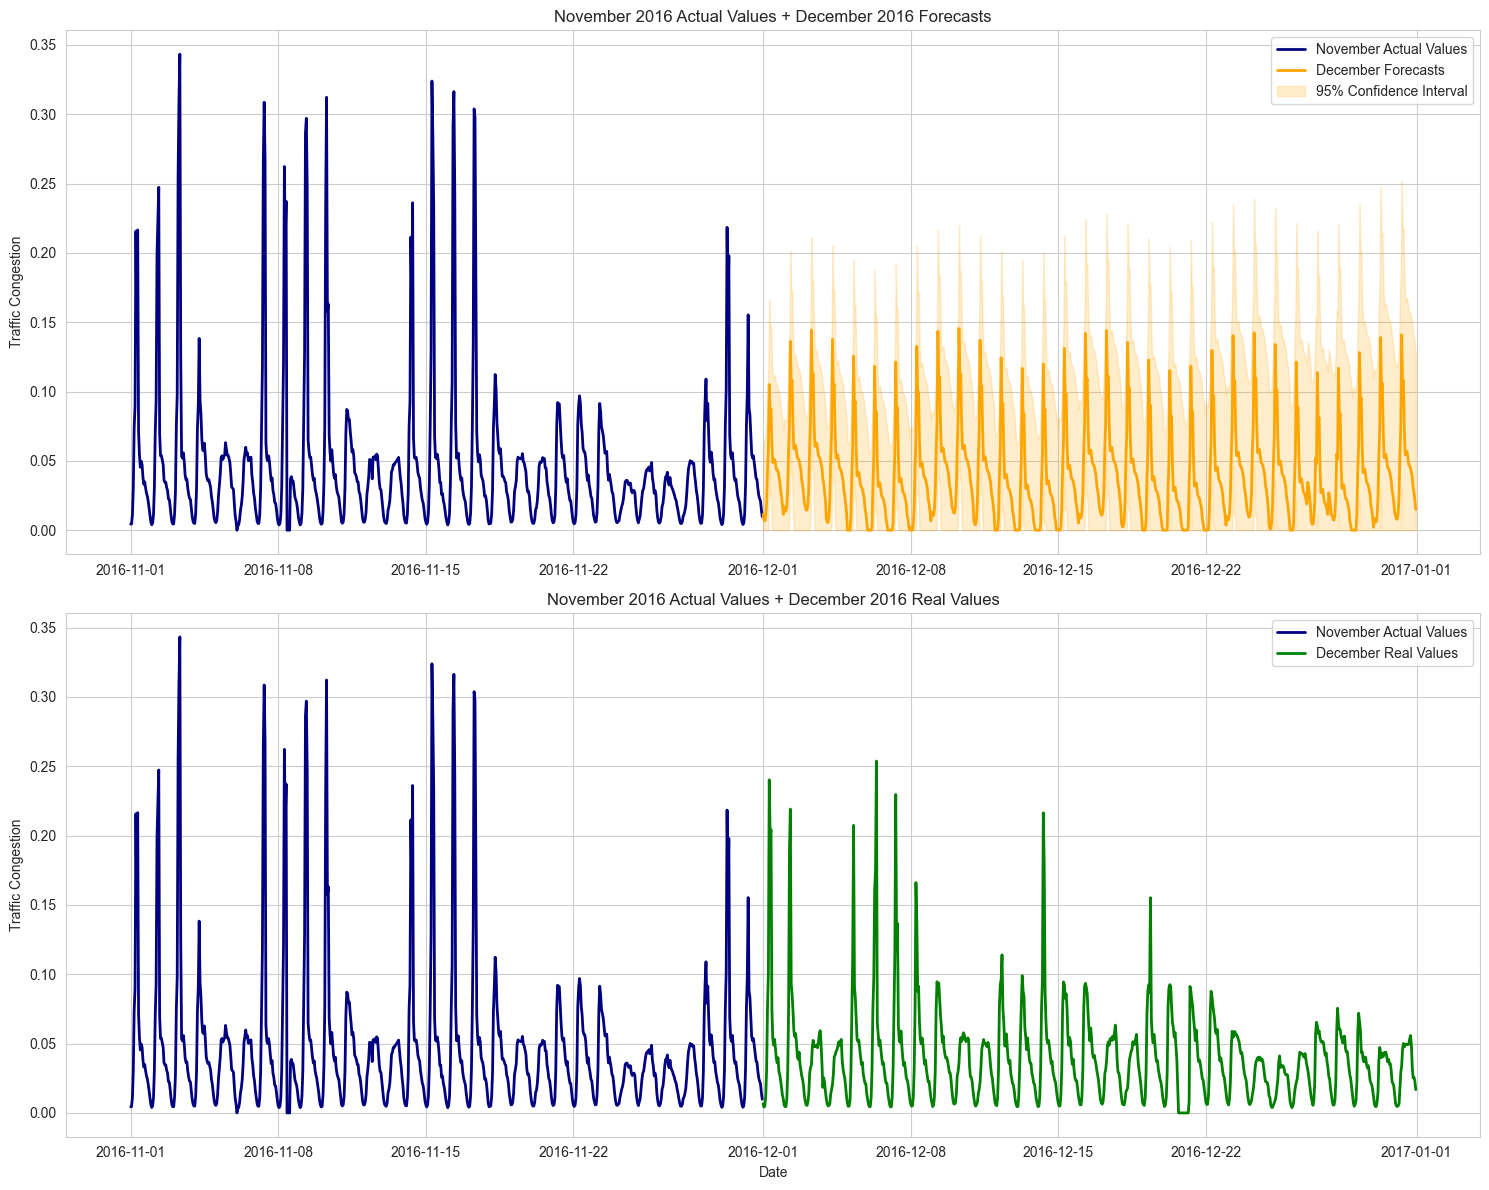

In [ ]:
# # Cell 24 - Create separate plots for forecasts and real values
# def plot_separate_comparisons(df, forecast_csv, solution_path):
#     """
#     Create two separate plots:
#     1. November actuals + December forecasts
#     2. November actuals + December real values
    
#     Colors chosen for colorblind visibility:
#     - November actuals: Dark Blue
#     - December forecasts: Orange
#     - December real values: Green
#     - Confidence intervals: Light Orange shading
#     """
#     # Read data files
#     forecasts = pd.read_csv(forecast_csv)
#     forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
#     solution = pd.read_csv(solution_path)
#     solution.index = pd.date_range(start='2016-12-01', 
#                                  periods=len(solution), 
#                                  freq='H')
    
#     # Get November data
#     november_start = '2016-11-01'
#     november_end = '2016-11-30 23:00:00'
#     november_data = df.loc[november_start:november_end]
    
#     # Create figure with two subplots
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), dpi=100)
    
#     # Plot 1: November + December Forecasts
#     ax1.plot(november_data.index, november_data['X'],
#             label='November Actual Values', 
#             color='#000080',  # Dark Blue
#             linewidth=2)
    
#     december_dates = pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H')
#     ax1.plot(december_dates, forecasts['ARIMA_forecast'],
#             label='December Forecasts', 
#             color='#FFA500',  # Orange
#             linewidth=2)
    
#     ax1.fill_between(december_dates,
#                     forecasts['ARIMA_lower'],
#                     forecasts['ARIMA_upper'],
#                     color='#FFA500',  # Orange
#                     alpha=0.2,
#                     label='95% Confidence Interval')
    
#     ax1.set_title('November 2016 Actual Values + December 2016 Forecasts')
#     ax1.set_ylabel('Traffic Congestion')
#     ax1.grid(True)
#     ax1.legend()
    
#     # Plot 2: November + December Real Values
#     ax2.plot(november_data.index, november_data['X'],
#             label='November Actual Values', 
#             color='#000080',  # Dark Blue
#             linewidth=2)
    
#     ax2.plot(solution.index, solution['X'],
#             label='December Real Values', 
#             color='#008000',  # Green
#             linewidth=2)
    
#     ax2.set_title('November 2016 Actual Values + December 2016 Real Values')
#     ax2.set_ylabel('Traffic Congestion')
#     ax2.set_xlabel('Date')
#     ax2.grid(True)
#     ax2.legend()
    
#     # Adjust layout and display
#     plt.tight_layout()
    
#     # Print comparison statistics
#     print("\nForecast Error Metrics:")
#     mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
#     rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
#     print(f"MAE: {mae:.4f}")
#     print(f"RMSE: {rmse:.4f}")
    
#     plt.show()

# # Execute the plot
# solution_path = os.path.join('solution', 't2_solution.csv')
# if os.path.exists('arima_forecasts_efficient.csv') and os.path.exists(solution_path):
#     print("Plotting separate comparisons...")
#     plot_separate_comparisons(df, 'arima_forecasts_efficient.csv', solution_path)
# else:
#     print("Missing required files. Please check both forecast and solution files exist.")

# Model 3: SARIMAX(2,1,2)(1,1,1)_24 more efficient

In [32]:
# Cell 25 - New Feature Creation Function
def create_refined_features(dates):
    """
    Create features: only day_sin and christmas_evening
    """
    features = pd.DataFrame(index=dates)
    
    # Day of week (0-6) as cosine feature only
    days = 7
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek / days)
    
    # Christmas evening indicator
    christmas_evenings = ((dates.day.isin([25, 26])) &
                         (dates.hour.isin(range(20, 24))) |
                         (dates.day.isin([26, 27])) &
                         (dates.hour.isin(range(0, 6))))
    features['christmas_evening'] = christmas_evenings.astype(int)
    
    return features

In [33]:
# Cell 26 - Refined SARIMAX Model Development
def develop_refined_sarimax(train_data):
    """
    Develop SARIMAX model with day_cos and christmas_evening regressors
    Maintains complete AR(2) structure
    """
    print("=== Refined SARIMAX Model Development ===")
    
    # Prepare the target variable
    y = train_data['X'].astype(float)
    y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
    # Create features
    exog_train = create_refined_features(y.index)
    print(f"\nIncluded features: {exog_train.columns.tolist()}")
    
    try:
        # Fit model with daily seasonality and selected regressors
        model = ARIMA(y,
                     order=(2, 1, 2),          # Keep complete AR(2)
                     seasonal_order=(1, 1, 1, 24),  # Daily seasonality
                     exog=exog_train,
                     enforce_stationarity=False,
                     enforce_invertibility=True)
        
        results = model.fit()
        print("\nModel Summary:")
        print(results.summary())
        
        return results, exog_train
    
    except Exception as e:
        print(f"Error fitting model:")
        print(f"Error message: {str(e)}")
        raise

In [34]:
# Cell 27 - Generate Forecasts for Refined Model
def generate_refined_forecasts(model, train_data, forecast_horizon=744):
    """
    Generate forecasts using the refined model
    """
    # Create forecast dates
    forecast_start = train_data.index[-1] + pd.Timedelta(hours=1)
    forecast_dates = pd.date_range(forecast_start, periods=forecast_horizon, freq='H')
    
    # Create features for forecast period
    exog_forecast = create_refined_features(forecast_dates)
    
    # Generate forecasts
    forecasts = model.forecast(steps=forecast_horizon, exog=exog_forecast)
    forecasts = np.maximum(forecasts, 0)  # Ensure non-negative
    
    # Get confidence intervals
    conf_int = model.get_forecast(steps=forecast_horizon, exog=exog_forecast).conf_int()
    conf_int.iloc[:, 0] = np.maximum(conf_int.iloc[:, 0], 0)  # Ensure non-negative lower bound
    
    return forecasts, conf_int, forecast_dates

In [35]:
# Cell 38 - Run Refined SARIMAX Pipeline
print("Starting Refined SARIMAX modeling pipeline...")

try:
    # Train the model
    refined_model, refined_features = develop_refined_sarimax(train_set)
    
    # Generate forecasts
    forecast_mean, forecast_conf, forecast_dates = generate_refined_forecasts(refined_model, train_set)
    
    # Create and save forecast DataFrame
    forecast_df = pd.DataFrame({
        'datetime': forecast_dates,
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.to_csv('arima_forecasts_refined.csv', index=False)
    
    print("\nRefined SARIMAX model completed!")
    print("Forecasts saved to 'arima_forecasts_refined.csv'")
    
except Exception as e:
    print(f"Error in pipeline: {str(e)}")
    raise

Starting Refined SARIMAX modeling pipeline...
=== Refined SARIMAX Model Development ===

Included features: ['day_sin', 'christmas_evening']


c:\Users\alexc\GitHubRepos\Project_TimeSeries\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37577.568
Date:                            Sat, 11 Jan 2025   AIC                         -75137.136
Time:                                    11:41:58   BIC                         -75068.010
Sample:                                01-01-2015   HQIC                        -75114.273
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
day_sin               0.0113      0.001     10.461      0.000       0.009       0.01

Plotting refined model results...

Forecast Error Metrics:
MAE: 0.0164
RMSE: 0.0284
MAPE: nan%


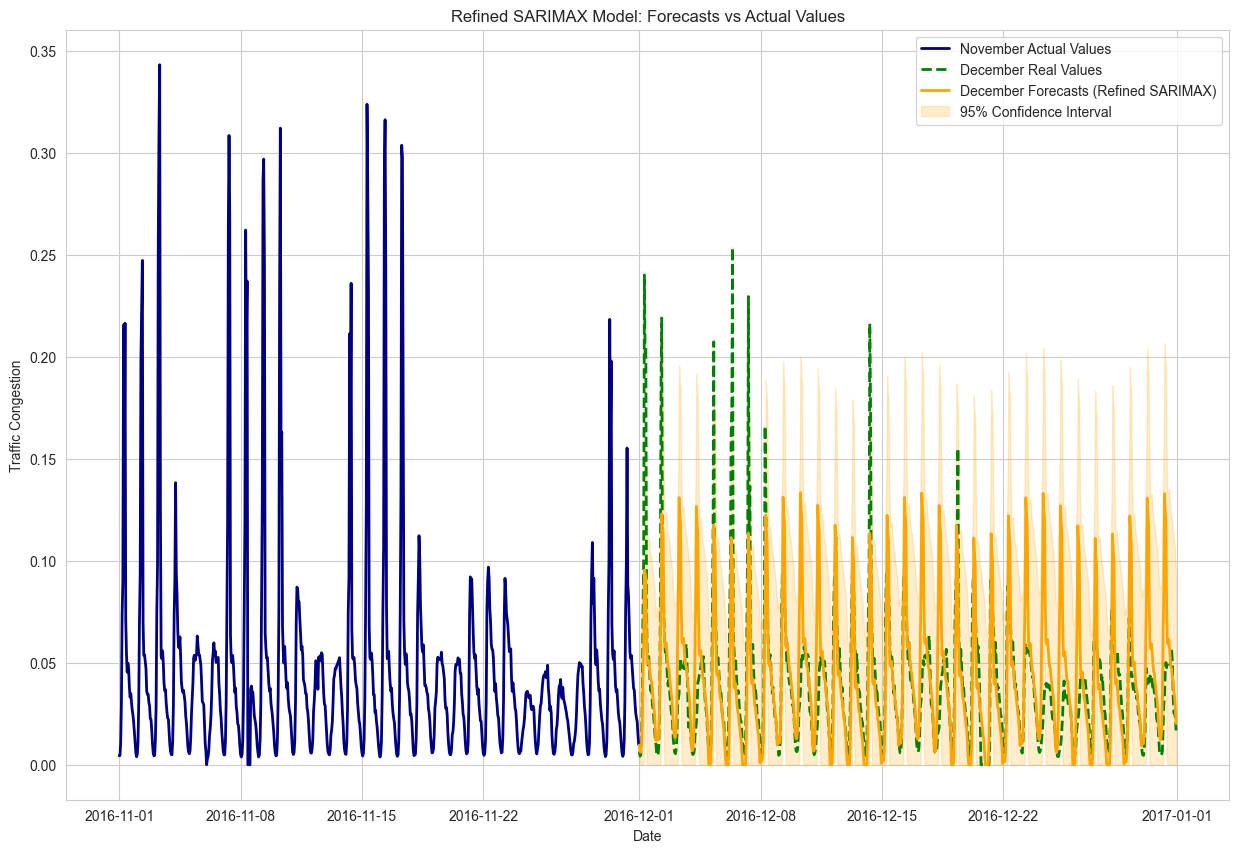

In [36]:
# Cell 29 - Plot Results
def plot_refined_model_results(df, forecast_csv, solution_path):
    """
    Plot results of the refined model
    """
    # Read data files
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01',
                                 periods=len(solution),
                                 freq='H')
    
    # Get November data
    november_data = df.loc['2016-11-01':'2016-11-30 23:00:00']
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot data
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values',
             color='#000080',
             linewidth=2)
    
    plt.plot(solution.index, solution['X'],
             label='December Real Values',
             color='#008000',
             linewidth=2,
             linestyle='--')
    
    plt.plot(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
             forecasts['ARIMA_forecast'],
             label='December Forecasts (Refined SARIMAX)',
             color='#FFA500',
             linewidth=2)
    
    # Add confidence intervals
    plt.fill_between(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('Refined SARIMAX Model: Forecasts vs Actual Values')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print error metrics
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    mape = np.mean(np.abs((solution['X'] - forecasts['ARIMA_forecast']) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts_refined.csv') and os.path.exists(solution_path):
    print("Plotting refined model results...")
    plot_refined_model_results(df, 'arima_forecasts_refined.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

In [37]:
# Cell 30 - Feature Creation Without Christmas
def create_weekly_features(dates):
    """
    Create features: only day_sin
    """
    features = pd.DataFrame(index=dates)
    
    # Day of week (0-6) as sine feature only
    days = 7
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek / days)
    
    return features

In [38]:
# Cell 31 - SARIMAX Model Without Christmas Effect
def develop_weekly_sarimax(train_data):
    """
    Develop SARIMAX model with only day_sin regressor
    """
    print("=== Weekly-Only SARIMAX Model Development ===")
    
    # Prepare the target variable
    y = train_data['X'].astype(float)
    y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
    # Create features
    exog_train = create_weekly_features(y.index)
    print(f"\nIncluded features: {exog_train.columns.tolist()}")
    
    try:
        # Fit model
        model = ARIMA(y,
                     order=(2, 1, 2),
                     seasonal_order=(1, 1, 1, 24),
                     exog=exog_train,
                     enforce_stationarity=False,
                     enforce_invertibility=True)
        
        results = model.fit()
        print("\nModel Summary:")
        print(results.summary())
        
        return results, exog_train
    
    except Exception as e:
        print(f"Error fitting model:")
        print(f"Error message: {str(e)}")
        raise

In [42]:
# Cell 32 - Generate Forecasts for Weekly-Only Model
def generate_weekly_forecasts(model, train_data, forecast_horizon=744):
    """
    Generate forecasts using the weekly-only model
    """
    # Create forecast dates
    forecast_start = train_data.index[-1] + pd.Timedelta(hours=1)
    forecast_dates = pd.date_range(forecast_start, periods=forecast_horizon, freq='H')
    
    # Create features for forecast period
    exog_forecast = create_weekly_features(forecast_dates)
    
    # Generate forecasts
    forecasts = model.forecast(steps=forecast_horizon, exog=exog_forecast)
    forecasts = np.maximum(forecasts, 0)  # Ensure non-negative
    
    # Get confidence intervals
    conf_int = model.get_forecast(steps=forecast_horizon, exog=exog_forecast).conf_int()
    conf_int.iloc[:, 0] = np.maximum(conf_int.iloc[:, 0], 0)  # Ensure non-negative lower bound
    
    return forecasts, conf_int, forecast_dates

In [41]:
# Cell 33 - Run Weekly-Only Pipeline
print("Starting Weekly-Only SARIMAX modeling pipeline...")

try:
    # Train the model
    weekly_model, weekly_features = develop_weekly_sarimax(train_set)
    
    # Generate forecasts using the weekly-only forecast function
    forecast_mean, forecast_conf, forecast_dates = generate_weekly_forecasts(
        weekly_model, 
        train_set,
        forecast_horizon=744
    )
    
    # Save forecasts
    forecast_df = pd.DataFrame({
        'datetime': forecast_dates,
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.to_csv('arima_forecasts_weekly.csv', index=False)
    
    print("\nWeekly-Only SARIMAX model completed!")
    print("Forecasts saved to 'arima_forecasts_weekly.csv'")
    
except Exception as e:
    print(f"Error in pipeline: {str(e)}")
    raise

Starting Weekly-Only SARIMAX modeling pipeline...
=== Weekly-Only SARIMAX Model Development ===

Included features: ['day_sin']

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37577.438
Date:                            Sat, 11 Jan 2025   AIC                         -75138.877
Time:                                    12:05:06   BIC                         -75077.432
Sample:                                01-01-2015   HQIC                        -75118.555
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

Plotting weekly model results...

Forecast Error Metrics:
MAE: 0.0164
RMSE: 0.0284
MAPE: nan%


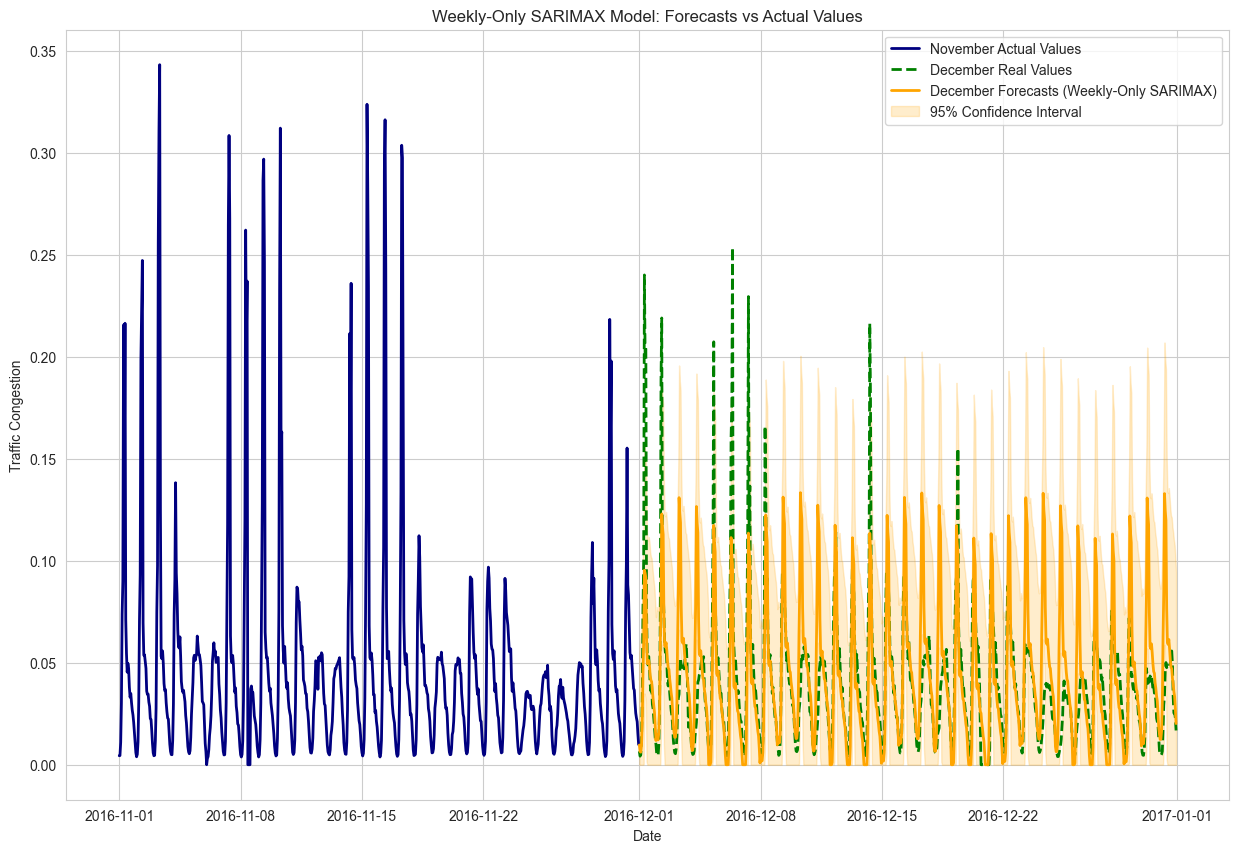

In [43]:
# Cell 34 - Plot Weekly-Only Model Results
def plot_weekly_model_results(df, forecast_csv, solution_path):
    """
    Plot results of the weekly-only model
    """
    # Read data files
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01',
                                 periods=len(solution),
                                 freq='H')
    
    # Get November data
    november_data = df.loc['2016-11-01':'2016-11-30 23:00:00']
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot data
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values',
             color='#000080',
             linewidth=2)
    
    plt.plot(solution.index, solution['X'],
             label='December Real Values',
             color='#008000',
             linewidth=2,
             linestyle='--')
    
    plt.plot(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
             forecasts['ARIMA_forecast'],
             label='December Forecasts (Weekly-Only SARIMAX)',
             color='#FFA500',
             linewidth=2)
    
    # Add confidence intervals
    plt.fill_between(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('Weekly-Only SARIMAX Model: Forecasts vs Actual Values')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print error metrics
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    mape = np.mean(np.abs((solution['X'] - forecasts['ARIMA_forecast']) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts_weekly.csv') and os.path.exists(solution_path):
    print("Plotting weekly model results...")
    plot_weekly_model_results(df, 'arima_forecasts_weekly.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")


Traffic Statistics:

November 2015:
count    720.000000
mean       0.047818
std        0.058973
min        0.000000
25%        0.017075
50%        0.034950
75%        0.051900
max        0.396300
Name: X, dtype: float64

December 2015:
count    744.000000
mean       0.038663
std        0.029176
min        0.003900
25%        0.016775
50%        0.035400
75%        0.052000
max        0.243000
Name: X, dtype: float64

Christmas Period (24-27 Dec 2015):
count    96.000000
mean      0.026021
std       0.014018
min       0.003900
25%       0.013325
50%       0.028050
75%       0.038050
max       0.046900
Name: X, dtype: float64


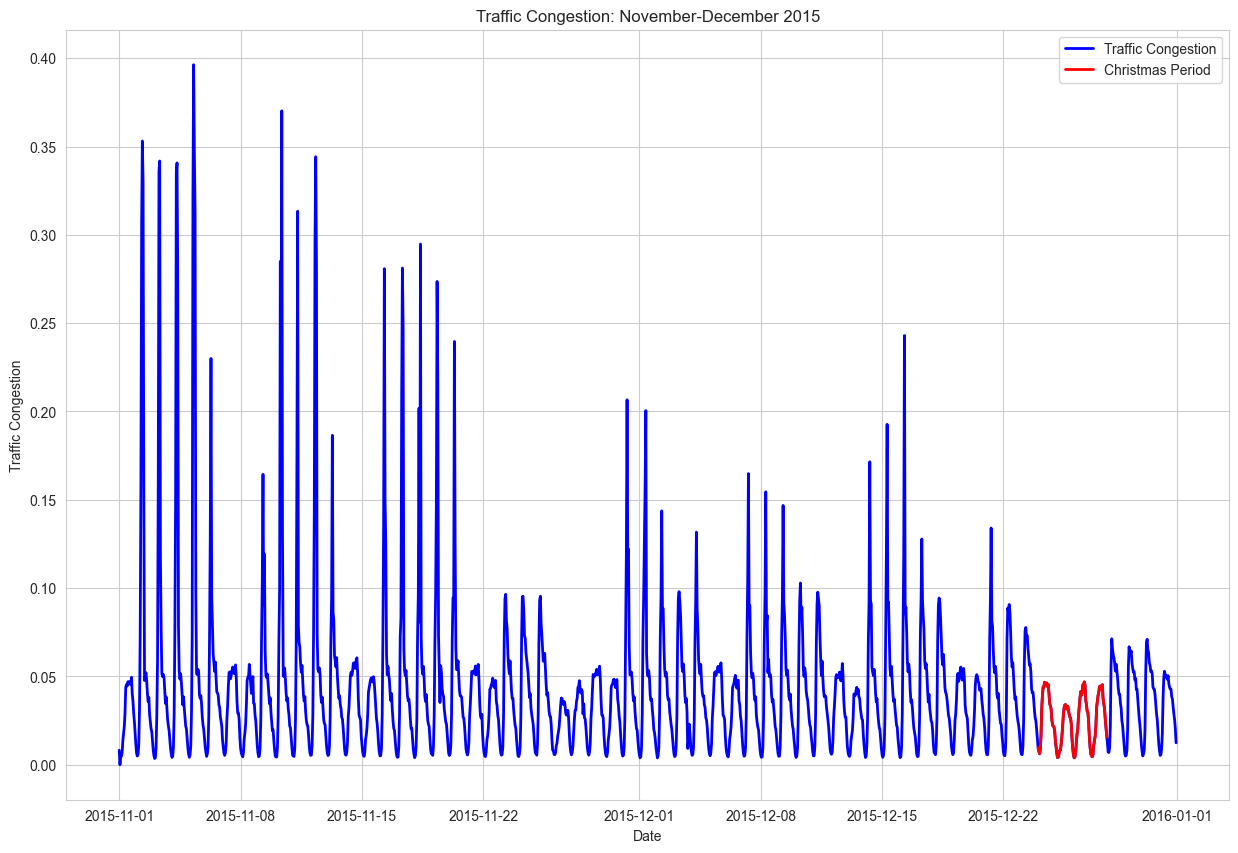

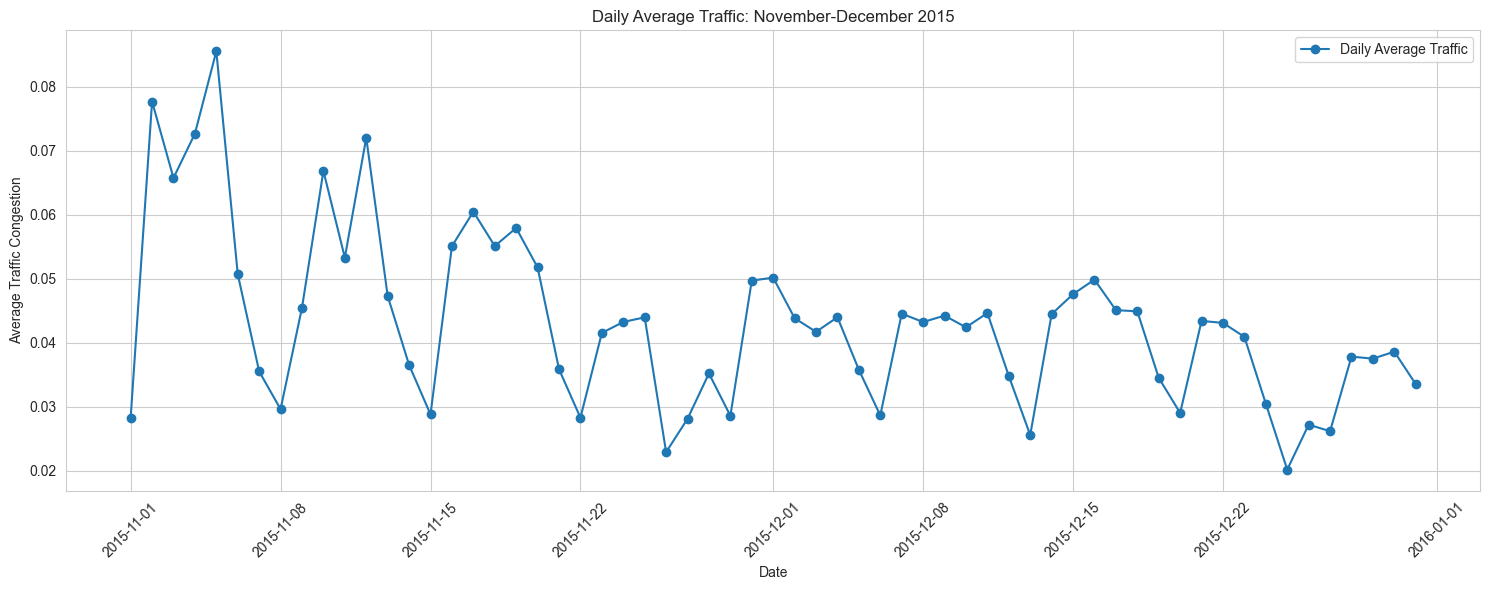

In [45]:
# Cell 35 - Analyze November-December 2015
def analyze_2015_holidays(df):
    """
    Analyze and visualize traffic patterns for Nov-Dec 2015
    """
    # Get the data for Nov-Dec 2015
    nov_dec_2015 = df.loc['2015-11-01':'2015-12-31']
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot entire period
    plt.plot(nov_dec_2015.index, nov_dec_2015['X'],
             label='Traffic Congestion',
             color='blue',
             linewidth=2)
    
    # Highlight Christmas period
    christmas_period = nov_dec_2015.loc['2015-12-24':'2015-12-27']
    plt.plot(christmas_period.index, christmas_period['X'],
             color='red',
             linewidth=2,
             label='Christmas Period')
    
    plt.title('Traffic Congestion: November-December 2015')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print some statistics
    print("\nTraffic Statistics:")
    print("\nNovember 2015:")
    nov_stats = df.loc['2015-11-01':'2015-11-30', 'X'].describe()
    print(nov_stats)
    
    print("\nDecember 2015:")
    dec_stats = df.loc['2015-12-01':'2015-12-31', 'X'].describe()
    print(dec_stats)
    
    print("\nChristmas Period (24-27 Dec 2015):")
    christmas_stats = df.loc['2015-12-24':'2015-12-27', 'X'].describe()
    print(christmas_stats)
    
    plt.show()
    
    # Additional plot for daily patterns
    plt.figure(figsize=(15, 6))
    
    # Calculate daily means
    daily_means = nov_dec_2015.groupby(nov_dec_2015.index.date)['X'].mean()
    
    plt.plot(daily_means.index, daily_means.values,
             marker='o',
             linestyle='-',
             label='Daily Average Traffic')
    
    plt.title('Daily Average Traffic: November-December 2015')
    plt.ylabel('Average Traffic Congestion')
    plt.xlabel('Date')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    
    plt.show()

# Execute the analysis
analyze_2015_holidays(df)

In [60]:
# Cell 36 - Phase-Adjusted Weekly Features
def create_phase_adjusted_features(dates):
    """
    Create features with phase-adjusted day_sin to align with Thursday start
    Thursday = 3 in Python's datetime (Mon=0, Sun=6)
    We need to shift the sine wave so that it peaks on Wednesday (day=2)
    """
    features = pd.DataFrame(index=dates)
    
    # Day of week (0-6) with phase adjustment for Wednesday peak
    days = 7
    # Shift phase by 2 days (peak on Wednesday)
    phase_shift = 2 * np.pi * 2/7  # 2 days shift
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek/days + phase_shift)
    
    return features

In [233]:
# Cell 37 - Phase-Adjusted Weekly Features with Christmas Effect
def create_final_features(dates):
    """
    Create features for SARIMAX model with phase-adjusted day_sin and christmas_evening
    """
    features = pd.DataFrame(index=dates)

    # Day of week (0-6) with phase adjustment for Wednesday peak
    days = 7
    phase_shift = 2 * np.pi * 2/7  # 2 days shift for Wednesday peak
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek/days + phase_shift)

    # Christmas evening indicator
    christmas_evenings = ((dates.day.isin([25, 26])) &
                         (dates.hour.isin(range(20, 24))) |
                         (dates.day.isin([26, 27])) &
                         (dates.hour.isin(range(0, 6))))
    features['christmas_evening'] = christmas_evenings.astype(int)

    return features

In [234]:
# Cell 38 - Final SARIMAX Model Development
def develop_final_sarimax(df):
    """
    Develop SARIMAX model using data through November 2016
    """
    print("=== Final SARIMAX Model Development ===")

    # Get training data (up to Nov 2016)
    train_data = df[:'2016-11-30 23:00:00'].copy()
    print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")

    # Prepare target variable
    y = train_data['X'].astype(float)
    
    # Create features for training period
    exog_train = create_final_features(train_data.index)
    print(f"\nFeatures included: {exog_train.columns.tolist()}")

    try:
        # Fit model
        model = ARIMA(y,
                     order=(2, 1, 2),
                     seasonal_order=(1, 1, 1, 24),
                     exog=exog_train,
                     enforce_stationarity=False,
                     enforce_invertibility=True)

        results = model.fit()
        print("\nModel Summary:")
        print(results.summary())

        return results

    except Exception as e:
        print(f"Error fitting model: {str(e)}")
        raise

In [235]:
# Cell 39 - Generate December 2016 SARIMAX Forecasts
def generate_sarimax_forecasts(model):
    """
    Generate SARIMAX forecasts for December 2016
    """
    # Create forecast dates
    forecast_dates = pd.date_range(start='2016-12-01',
                                 end='2016-12-31 23:00:00',
                                 freq='H')
    
    # Create features for forecast period
    exog_forecast = create_final_features(forecast_dates)
    
    # Generate forecasts
    forecasts = model.forecast(steps=744, exog=exog_forecast)
    forecasts = np.maximum(forecasts, 0)  # Ensure non-negative
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'DateTime': forecast_dates,
        'SARIMAX': forecasts
    })
    
    return forecast_df

# Run SARIMAX pipeline
print("Starting Final SARIMAX pipeline...")

try:
    # Train model
    sarimax_model = develop_final_sarimax(df)
    
    # Generate forecasts
    december_forecasts = generate_sarimax_forecasts(sarimax_model)
    
    # Save forecasts
    december_forecasts.to_csv('sarimax_forecasts.csv', index=False)
    print("\nForecasts saved to 'sarimax_forecasts.csv'")
    
    # Verify saved forecasts
    verify_df = pd.read_csv('sarimax_forecasts.csv')
    print("\nVerification of saved forecasts:")
    print(verify_df.head())
    print("\nShape:", verify_df.shape)
    print("\nDescriptive statistics:")
    print(verify_df['SARIMAX'].describe())
    
except Exception as e:
    print(f"Error in SARIMAX pipeline: {str(e)}")
    raise

Starting Final SARIMAX pipeline...
=== Final SARIMAX Model Development ===
Training period: 2015-01-01 00:00:00 to 2016-11-30 23:00:00

Features included: ['day_sin', 'christmas_evening']

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16800
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               39222.606
Date:                            Sat, 11 Jan 2025   AIC                         -78427.213
Time:                                    19:52:10   BIC                         -78357.679
Sample:                                01-01-2015   HQIC                        -78404.266
                                     - 11-30-2016                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [

Plotting SARIMAX results...


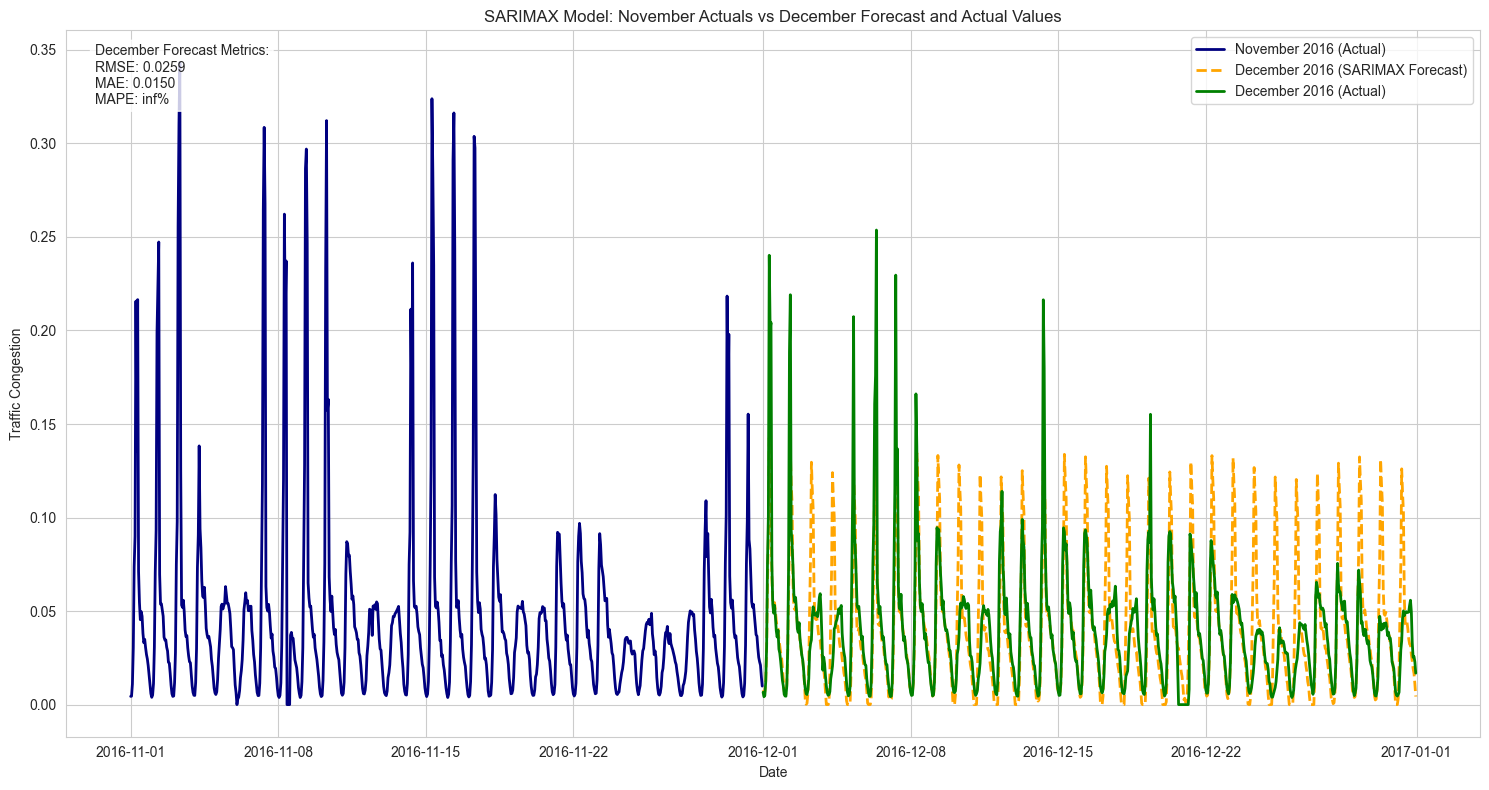

In [236]:
# Cell 40 - Plot SARIMAX Results
def plot_sarimax_results(df, forecast_csv, solution_path):
    """
    Plot November actuals, December SARIMAX forecasts, and December real values
    """
    # Read forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['DateTime'] = pd.to_datetime(forecasts['DateTime'])

    # Read solution
    solution = pd.read_csv(solution_path)
    solution['datetime'] = pd.to_datetime(solution['DateTime'])

    # Get November data
    november_data = df['2016-11-01':'2016-11-30 23:00:00']

    # Create plot
    plt.figure(figsize=(15, 8))

    # Plot November actual values
    plt.plot(november_data.index, november_data['X'],
             label='November 2016 (Actual)',
             color='#000080',  # Dark Blue
             linewidth=2)

    # Plot December forecasts
    plt.plot(forecasts['DateTime'], forecasts['SARIMAX'],
             label='December 2016 (SARIMAX Forecast)',
             color='#FFA500',  # Orange
             linewidth=2,
             linestyle='--')

    # Plot December actual values
    plt.plot(solution['datetime'], solution['X'],
             label='December 2016 (Actual)',
             color='#008000',  # Green
             linewidth=2)

    plt.title('SARIMAX Model: November Actuals vs December Forecast and Actual Values')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)

    # Add error metrics
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['SARIMAX']))
    mae = mean_absolute_error(solution['X'], forecasts['SARIMAX'])
    mape = np.mean(np.abs((solution['X'] - forecasts['SARIMAX']) / solution['X'])) * 100

    metrics_text = f'December Forecast Metrics:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nMAPE: {mape:.2f}%'
    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    return rmse, mae, mape

# Execute the plot if files exist
if os.path.exists('sarimax_forecasts.csv') and os.path.exists(os.path.join('solution', 't2_solution.csv')):
    print("Plotting SARIMAX results...")
    rmse, mae, mape = plot_sarimax_results(df, 'sarimax_forecasts.csv', os.path.join('solution', 't2_solution.csv'))
else:
    print("Missing required files. Please check both forecast and solution files exist.")

# UCM

In [237]:
# Cell 41 - UCM Setup and Features
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

def create_ucm_features(dates):
    """
    Create features for UCM models: weekly pattern and christmas effect
    """
    features = pd.DataFrame(index=dates)

    # Weekly pattern with Wednesday peak
    days = 7
    phase_shift = 2 * np.pi * 2/7
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek/days + phase_shift)

    # Christmas evening indicator
    christmas_evenings = ((dates.day.isin([25, 26])) &
                         (dates.hour.isin(range(20, 24))) |
                         (dates.day.isin([26, 27])) &
                         (dates.hour.isin(range(0, 6))))
    features['christmas_evening'] = christmas_evenings.astype(int)

    return features

In [238]:
# Cell 42 - UCM Model Development
def develop_ucm_model(df):
    """
    Develop UCM model using data through November 2016
    """
    print("=== UCM Model Development ===")
    
    # Get training data up to November 2016
    train_data = df[:'2016-11-30 23:00:00'].copy()
    print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
    
    # Create features for training period
    exog = create_ucm_features(train_data.index)
    
    # Specify and fit UCM
    model = UnobservedComponents(
        train_data['X'],
        exog=exog,
        level='local level',
        seasonal=24,          # Daily seasonality
        stochastic_seasonal=True,
        irregular=True
    )
    
    results = model.fit()
    print("\nModel Summary:")
    print(results.summary())
    
    return results

In [239]:
# Cell 43 - Generate December 2016 UCM Forecasts
def generate_ucm_forecasts(model):
    """
    Generate UCM forecasts for December 2016
    """
    # Create forecast dates
    forecast_dates = pd.date_range(
        start='2016-12-01',
        end='2016-12-31 23:00:00',
        freq='H'
    )
    
    # Create features for forecast period
    exog_forecast = create_ucm_features(forecast_dates)
    
    # Generate forecasts
    forecasts = model.forecast(steps=744, exog=exog_forecast)
    forecasts = np.maximum(forecasts, 0)  # Ensure non-negative
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'DateTime': forecast_dates,
        'UCM': forecasts
    })
    
    return forecast_df

# Run UCM pipeline
print("Starting UCM pipeline...")

try:
    # Train model
    ucm_model = develop_ucm_model(df)
    
    # Generate forecasts
    december_forecasts = generate_ucm_forecasts(ucm_model)
    
    # Save forecasts
    december_forecasts.to_csv('ucm_forecasts.csv', index=False)
    print("\nForecasts saved to 'ucm_forecasts.csv'")
    
    # Verify saved forecasts
    verify_df = pd.read_csv('ucm_forecasts.csv')
    print("\nVerification of saved forecasts:")
    print(verify_df.head())
    print("\nShape:", verify_df.shape)
    print("\nDescriptive statistics:")
    print(verify_df['UCM'].describe())
    
except Exception as e:
    print(f"Error in UCM pipeline: {str(e)}")
    raise

Starting UCM pipeline...
=== UCM Model Development ===
Training period: 2015-01-01 00:00:00 to 2016-11-30 23:00:00

Model Summary:
                            Unobserved Components Results                            
Dep. Variable:                             X   No. Observations:                16800
Model:                           local level   Log Likelihood               37179.159
                   + stochastic seasonal(24)   AIC                         -74348.317
Date:                       Sat, 11 Jan 2025   BIC                         -74309.679
Time:                               19:59:58   HQIC                        -74335.567
Sample:                           01-01-2015                                         
                                - 11-30-2016                                         
Covariance Type:                         opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----

Plotting UCM results...


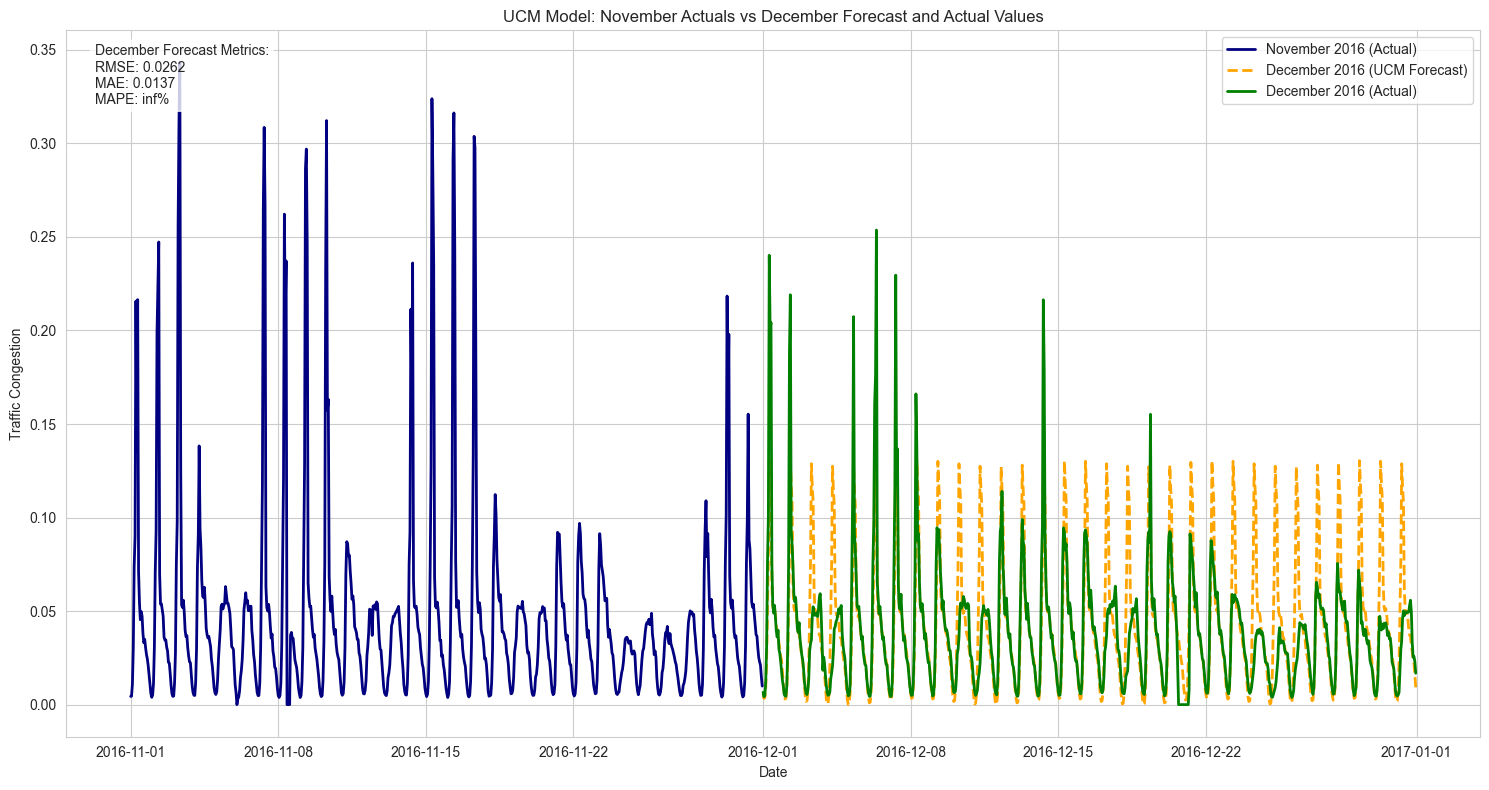

In [240]:
# Cell 44 - Plot UCM Results
def plot_ucm_results(df, forecast_csv, solution_path):
    """
    Plot November actuals, December UCM forecasts, and December real values
    """
    # Read forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['DateTime'] = pd.to_datetime(forecasts['DateTime'])

    # Read solution
    solution = pd.read_csv(solution_path)
    solution['datetime'] = pd.to_datetime(solution['DateTime'])

    # Get November data
    november_data = df['2016-11-01':'2016-11-30 23:00:00']

    # Create plot
    plt.figure(figsize=(15, 8))

    # Plot data
    plt.plot(november_data.index, november_data['X'],
             label='November 2016 (Actual)',
             color='#000080',  # Dark Blue
             linewidth=2)

    plt.plot(forecasts['DateTime'], forecasts['UCM'],
             label='December 2016 (UCM Forecast)',
             color='#FFA500',  # Orange
             linewidth=2,
             linestyle='--')

    plt.plot(solution['datetime'], solution['X'],
             label='December 2016 (Actual)',
             color='#008000',  # Green
             linewidth=2)

    plt.title('UCM Model: November Actuals vs December Forecast and Actual Values')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)

    # Add error metrics
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['UCM']))
    mae = mean_absolute_error(solution['X'], forecasts['UCM'])
    mape = np.mean(np.abs((solution['X'] - forecasts['UCM']) / solution['X'])) * 100

    metrics_text = f'December Forecast Metrics:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nMAPE: {mape:.2f}%'
    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    return rmse, mae, mape

# Execute the plot if files exist
if os.path.exists('ucm_forecasts.csv') and os.path.exists(os.path.join('solution', 't2_solution.csv')):
    print("Plotting UCM results...")
    rmse, mae, mape = plot_ucm_results(df, 'ucm_forecasts.csv', os.path.join('solution', 't2_solution.csv'))
else:
    print("Missing required files. Please check both forecast and solution files exist.")

In [90]:
# Cell 45 - Run UCM Pipeline and Compare Models
print("Starting UCM modeling pipeline...")

try:
    # Create forecast dates
    forecast_dates = pd.date_range(
        start=train_set.index[-1] + pd.Timedelta(hours=1),
        periods=744,
        freq='H'
    )
    
    # Fit models
    base_model = fit_base_ucm(train_set)
    enhanced_model = fit_enhanced_ucm(train_set)
    final_model = fit_final_ucm(train_set)
    
    # Generate forecasts
    base_forecast, base_ci = forecast_ucm(base_model)
    enhanced_forecast, enhanced_ci = forecast_enhanced_ucm(
        enhanced_model, train_set, forecast_dates
    )
    final_forecast, final_ci = forecast_final_ucm(
        final_model, train_set, forecast_dates
    )
    
    # Save forecasts
    for name, forecast, ci in [
        ('base', base_forecast, base_ci),
        ('enhanced', enhanced_forecast, enhanced_ci),
        ('final', final_forecast, final_ci)
    ]:
        forecast_df = pd.DataFrame({
            'datetime': forecast_dates,
            'UCM_forecast': forecast,
            'UCM_lower': ci.iloc[:, 0],
            'UCM_upper': ci.iloc[:, 1]
        })
        forecast_df.to_csv(f'ucm_forecasts_{name}.csv', index=False)
    
    print("\nUCM modeling pipeline completed!")

except Exception as e:
    print(f"Error in UCM pipeline: {str(e)}")
    raise

Starting UCM modeling pipeline...
=== Base UCM Model ===
                            Unobserved Components Results                            
Dep. Variable:                             X   No. Observations:                16056
Model:                           local level   Log Likelihood               35613.420
                   + stochastic seasonal(24)   AIC                         -71220.841
Date:                       Sat, 11 Jan 2025   BIC                         -71197.794
Time:                               13:25:44   HQIC                        -71213.219
Sample:                           01-01-2015                                         
                                - 10-30-2016                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

Plotting individual UCM results...


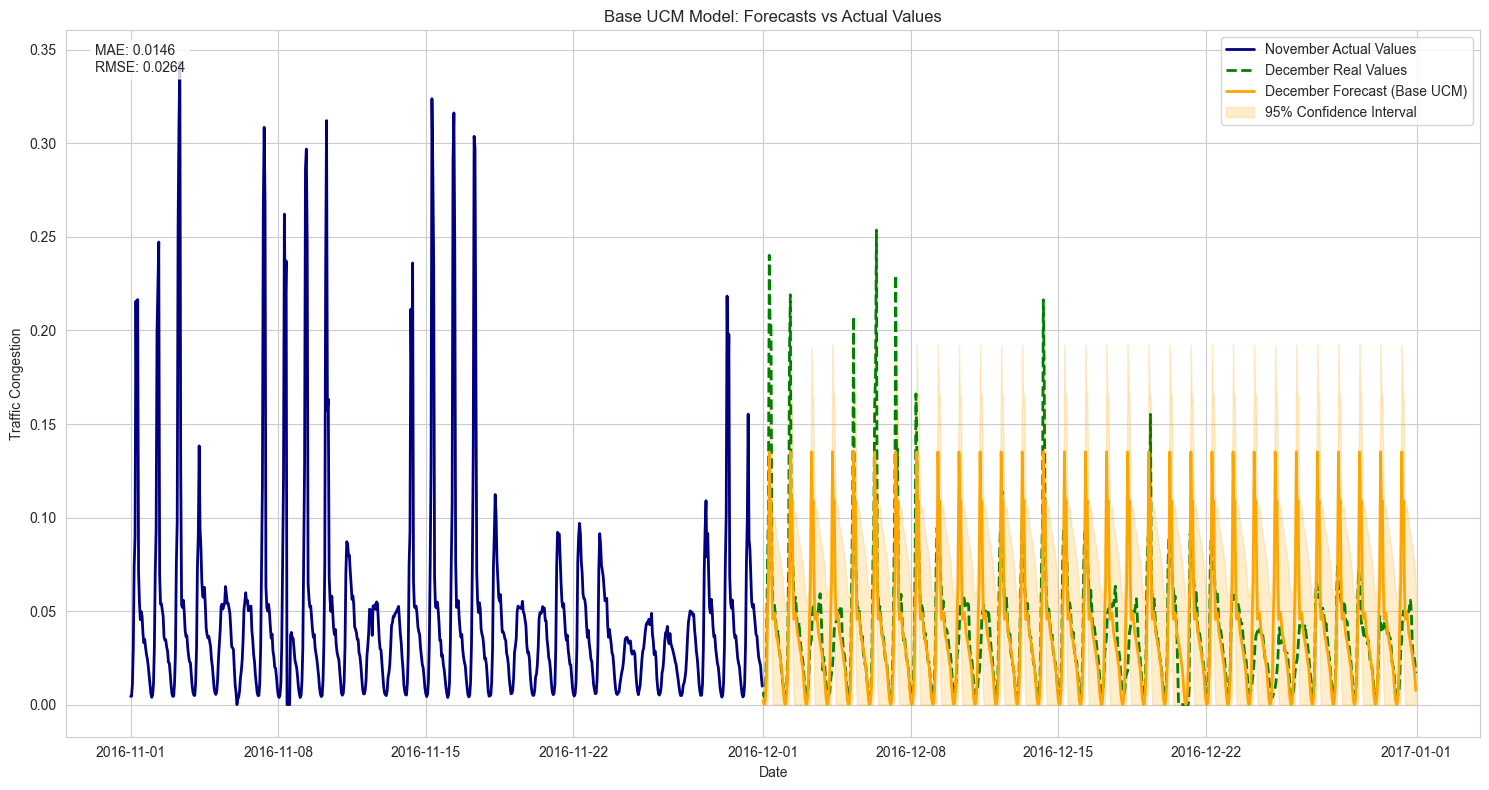


Base UCM Error Metrics:
MAE: 0.0146
RMSE: 0.0264


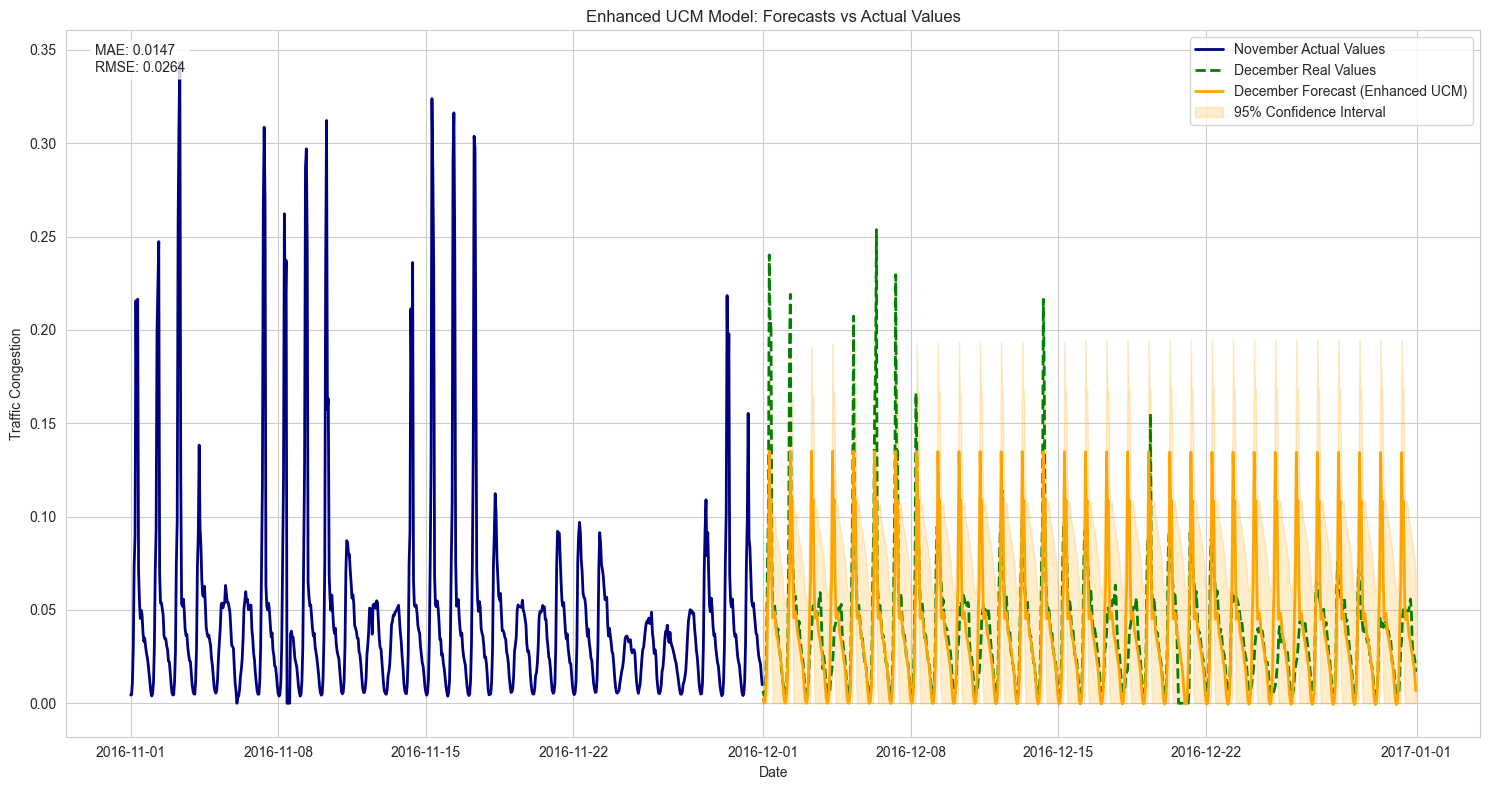


Enhanced UCM Error Metrics:
MAE: 0.0147
RMSE: 0.0264


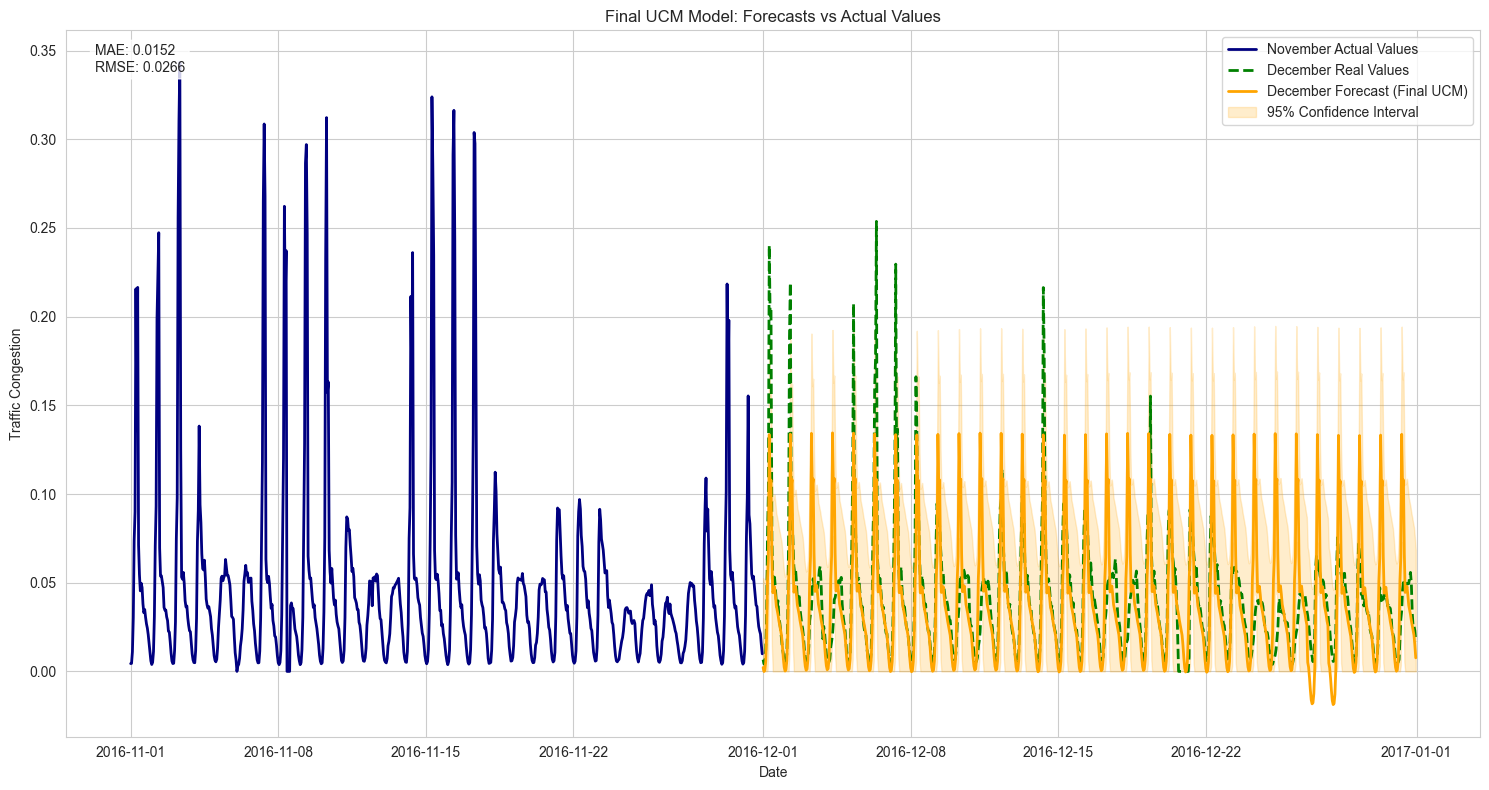


Final UCM Error Metrics:
MAE: 0.0152
RMSE: 0.0266


In [91]:
# Cell 46 - Plot Individual UCM Results
def plot_individual_ucm_results(df, solution_path):
    """
    Create separate plots for each UCM model
    """
    # Read solution
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(
        start='2016-12-01',
        periods=len(solution),
        freq='H'
    )
    
    # Get November data
    november_data = df.loc['2016-11-01':'2016-11-30 23:00:00']
    
    # Colors for consistency
    actual_color = '#000080'  # Dark Blue
    forecast_color = '#FFA500'  # Orange
    solution_color = '#008000'  # Green
    
    # Create plots for each model
    for name in ['base', 'enhanced', 'final']:
        # Read forecast data
        forecast_df = pd.read_csv(f'ucm_forecasts_{name}.csv')
        forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])
        
        # Create figure
        plt.figure(figsize=(15, 8))
        
        # Plot actual November data
        plt.plot(november_data.index, november_data['X'],
                label='November Actual Values',
                color=actual_color,
                linewidth=2)
        
        # Plot December solution
        plt.plot(solution.index, solution['X'],
                label='December Real Values',
                color=solution_color,
                linewidth=2,
                linestyle='--')
        
        # Plot forecast
        plt.plot(pd.date_range(start='2016-12-01', periods=len(forecast_df), freq='H'),
                forecast_df['UCM_forecast'],
                label=f'December Forecast ({name.title()} UCM)',
                color=forecast_color,
                linewidth=2)
        
        # Add confidence intervals
        plt.fill_between(
            pd.date_range(start='2016-12-01', periods=len(forecast_df), freq='H'),
            forecast_df['UCM_lower'],
            forecast_df['UCM_upper'],
            color=forecast_color,
            alpha=0.2,
            label='95% Confidence Interval'
        )
        
        # Customize plot
        plt.title(f'{name.title()} UCM Model: Forecasts vs Actual Values')
        plt.ylabel('Traffic Congestion')
        plt.xlabel('Date')
        plt.legend()
        plt.grid(True)
        
        # Add error metrics as text box
        mae = mean_absolute_error(solution['X'], forecast_df['UCM_forecast'])
        rmse = np.sqrt(mean_squared_error(solution['X'], forecast_df['UCM_forecast']))
        metrics_text = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
        plt.text(0.02, 0.98, metrics_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print(f"\n{name.title()} UCM Error Metrics:")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if all(os.path.exists(f'ucm_forecasts_{name}.csv') 
       for name in ['base', 'enhanced', 'final']) \
   and os.path.exists(solution_path):
    print("Plotting individual UCM results...")
    plot_individual_ucm_results(df, solution_path)
else:
    print("Missing required files. Please run the UCM pipeline first.")

# MACHINE LEARNING

In [185]:
# Cell 47 - Additional ML Imports

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle  # For saving the trained model if needed

print("Additional ML libraries imported!")


Additional ML libraries imported!


In [217]:
# Cell 48 - Create a Function to Build a Supervised Dataset

def create_supervised_dataset(df, target_col='X', lags=[1, 24], lead=1):
    """
    Converts a time-indexed DataFrame into a supervised learning dataset.

    Parameters:
    -----------
    df : pd.DataFrame
        Your time series DataFrame with a DateTime index.
    target_col : str
        The column name for the target variable (traffic congestion).
    lags : list
        The list of 'lag' offsets to include as features. 
        [1, 24] means X(t-1) and X(t-24).
    lead : int
        How far ahead to forecast. lead=1 => next hour.

    Returns:
    --------
    X_data : pd.DataFrame
        Feature matrix
    y_data : pd.Series
        Corresponding target values
    """
    print(f"Data range: {df.index.min()} to {df.index.max()}")
    
    df_supervised = df.copy()

    # Create lag features
    for lag in lags:
        df_supervised[f'lag_{lag}'] = df_supervised[target_col].shift(lag)

    # Create lead target
    df_supervised[f'y_lead_{lead}'] = df_supervised[target_col].shift(-lead)

    # Drop any rows with NaNs introduced by shifting
    df_supervised.dropna(inplace=True)

    # Define X and y
    feature_cols = [col for col in df_supervised.columns if col.startswith('lag_')
                    or col in ['hour', 'day_of_week', 'month', 'is_weekend']]
    X_data = df_supervised[feature_cols]
    y_data = df_supervised[f'y_lead_{lead}']

    return X_data, y_data

In [218]:
# Cell 49 - Prepare the Data and Create Train/Validation Sets

# First, ensure we only use data up to November 2016
training_end = '2016-10-31 23:00:00'
validation_end = '2016-11-30 23:00:00'

# Split the data into training and validation periods
df_train = df_processed[:'2016-10-31 23:00:00'].copy()
df_val = df_processed['2016-11-01':'2016-11-30 23:00:00'].copy()

print(f"Training data range: {df_train.index.min()} to {df_train.index.max()}")
print(f"Validation data range: {df_val.index.min()} to {df_val.index.max()}")

# Create supervised datasets
lead = 1
lag_list = [1, 24]  # You can add more lags if desired

# Create training set
X_train, y_train = create_supervised_dataset(df_train,
                                           target_col='X',
                                           lags=lag_list,
                                           lead=lead)

# Create validation set
X_val, y_val = create_supervised_dataset(df_val,
                                        target_col='X',
                                        lags=lag_list,
                                        lead=lead)

# Convert to NumPy arrays
X_train_values = X_train.values
y_train_values = y_train.values
X_val_values = X_val.values
y_val_values = y_val.values

# Save column names for later use in forecasting
X_train_columns_global = list(X_train.columns)

print("\nTraining set size:", X_train_values.shape)
print("Validation set size:", X_val_values.shape)

Training data range: 2015-01-01 00:00:00 to 2016-10-31 23:00:00
Validation data range: 2016-11-01 00:00:00 to 2016-11-30 23:00:00
Data range: 2015-01-01 00:00:00 to 2016-10-31 23:00:00
Data range: 2016-11-01 00:00:00 to 2016-11-30 23:00:00

Training set size: (16055, 6)
Validation set size: (695, 6)


In [219]:
# Cell 50 - Train and Evaluate XGBoost Model

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train_values, label=y_train_values)
dval = xgb.DMatrix(X_val_values, label=y_val_values)

# Define XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the model
evals = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(params=xgb_params,
                dtrain=dtrain,
                num_boost_round=500,
                early_stopping_rounds=20,
                evals=evals,
                verbose_eval=50)

# Make predictions on the validation set
y_val_pred = bst.predict(dval)

# Store training residuals for later use in confidence intervals
y_train_pred = bst.predict(dtrain)
train_residuals = y_train_values - y_train_pred
resid_std = np.std(train_residuals)

# Evaluate performance
rmse_val = np.sqrt(mean_squared_error(y_val_values, y_val_pred))
mae_val = mean_absolute_error(y_val_values, y_val_pred)
mape_val = np.mean(np.abs((y_val_values - y_val_pred) / y_val_values)) * 100

print("\nValidation Metrics (November 2016):")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAE:  {mae_val:.4f}")
print(f"MAPE: {mape_val:.2f}%")

# Save these for global access in forecasting
X_train_global = X_train_values
y_train_global = y_train_values

[0]	train-rmse:0.04555	eval-rmse:0.05024


[50]	train-rmse:0.01881	eval-rmse:0.02216
[86]	train-rmse:0.01732	eval-rmse:0.02222

Validation Metrics (November 2016):
RMSE: 0.0222
MAE:  0.0091
MAPE: inf%


Validation index length: 695
y_val_values length: 695
y_val_pred length: 695


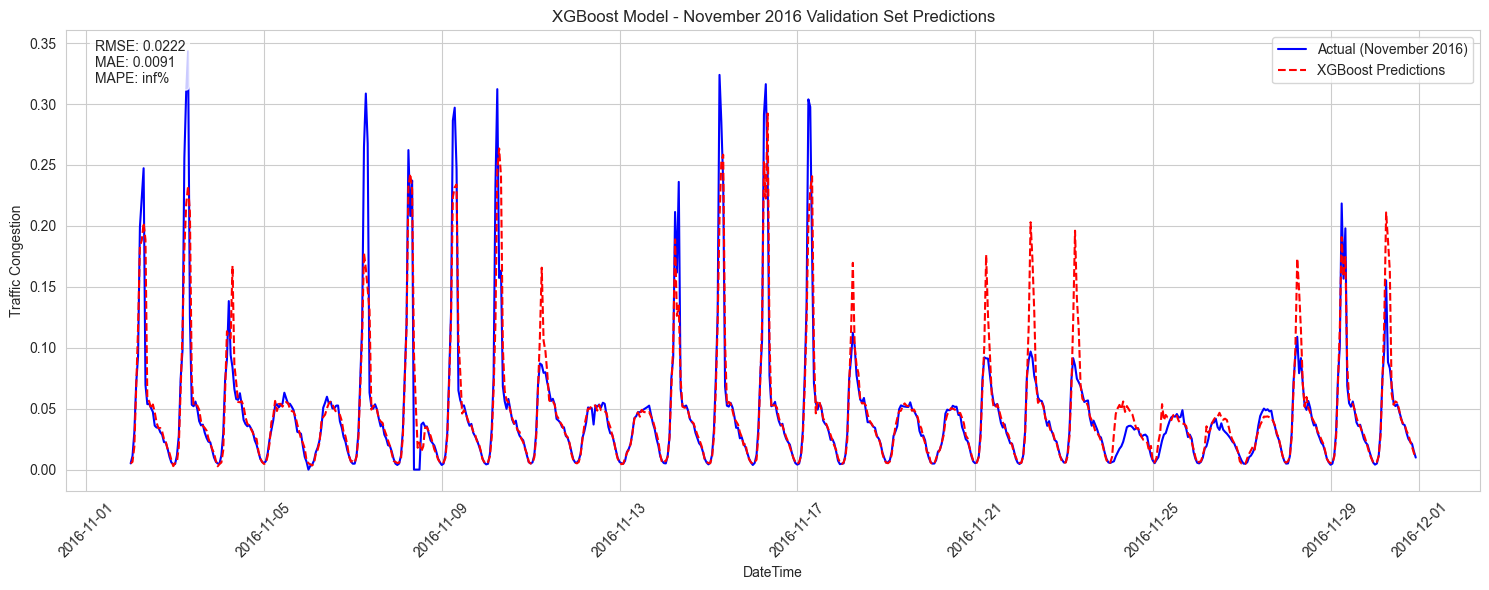

In [222]:
# Cell 51 - Visualize ML Model Predictions vs Actual on Validation Set (November 2016)

plt.figure(figsize=(15, 6))

# Get the exact index from our validation data
val_index = df_val.index[24:len(y_val_values)+24]  # Align with y_val_values length

# Verify dimensions before plotting
print(f"Validation index length: {len(val_index)}")
print(f"y_val_values length: {len(y_val_values)}")
print(f"y_val_pred length: {len(y_val_pred)}")

# Create the plot
plt.plot(val_index, y_val_values, label='Actual (November 2016)', color='blue')
plt.plot(val_index, y_val_pred, label='XGBoost Predictions', color='red', linestyle='--')
plt.title('XGBoost Model - November 2016 Validation Set Predictions')
plt.xlabel('DateTime')
plt.ylabel('Traffic Congestion')
plt.legend()
plt.grid(True)

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Add metrics as text box
metrics_text = f'RMSE: {rmse_val:.4f}\nMAE: {mae_val:.4f}\nMAPE: {mape_val:.2f}%'
plt.text(0.02, 0.98, metrics_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Plotting Feature Importance...


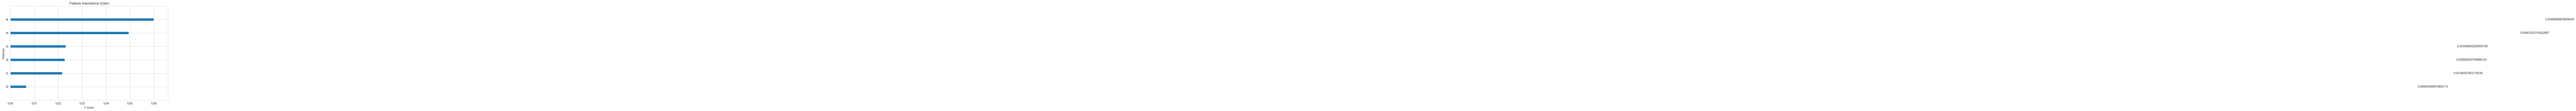


Model saved to xgb_traffic_model.json


In [223]:
# Cell 52 - Feature Importance and Model Save
print("Plotting Feature Importance...")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(bst, max_num_features=10, importance_type='gain', ax=ax)
plt.title('Feature Importance (Gain)')
plt.tight_layout()
plt.show()

# Save the trained model
model_path = 'xgb_traffic_model.json'
bst.save_model(model_path)
print(f"\nModel saved to {model_path}")

In [225]:
# Cell 53 - Recursive Forecasting Function for December 2016
def forecast_december_2016_xgb(model, last_known_data, start_date='2016-12-01', end_date='2016-12-31 23:00:00'):
    """
    Recursively forecast December 2016 using the trained XGBoost model.
    """
    print("Starting December 2016 forecasting...")
    
    # Create forecast dates
    forecast_dates = pd.date_range(start=start_date, end=end_date, freq='H')
    print(f"Forecasting {len(forecast_dates)} hours")
    
    # Initialize forecast array
    forecasts = []
    
    # Get the last known values for initial lags
    last_known = last_known_data.copy()
    
    # Recursive forecasting
    for future_time in forecast_dates:
        # Create feature row
        features = {
            'lag_1': last_known['X'].iloc[-1],
            'lag_24': last_known['X'].iloc[-24],
            'hour': future_time.hour,
            'day_of_week': future_time.dayofweek,
            'month': future_time.month,
            'is_weekend': 1 if future_time.dayofweek in [5, 6] else 0
        }
        
        # Convert to DataFrame with correct column order
        feature_df = pd.DataFrame([features])
        feature_df = feature_df[X_train_columns_global]
        
        # Make prediction
        dpred = xgb.DMatrix(feature_df)
        pred = float(model.predict(dpred)[0])
        pred = max(0, pred)  # Ensure non-negative
        
        # Store forecast
        forecasts.append(pred)
        
        # Update last_known for next iteration
        new_row = pd.DataFrame({'X': [pred]}, index=[future_time])
        last_known = pd.concat([last_known, new_row]).tail(24)
    
    return pd.Series(forecasts, index=forecast_dates)

Generating and plotting final forecasts...
Starting December 2016 forecasting...
Forecasting 744 hours


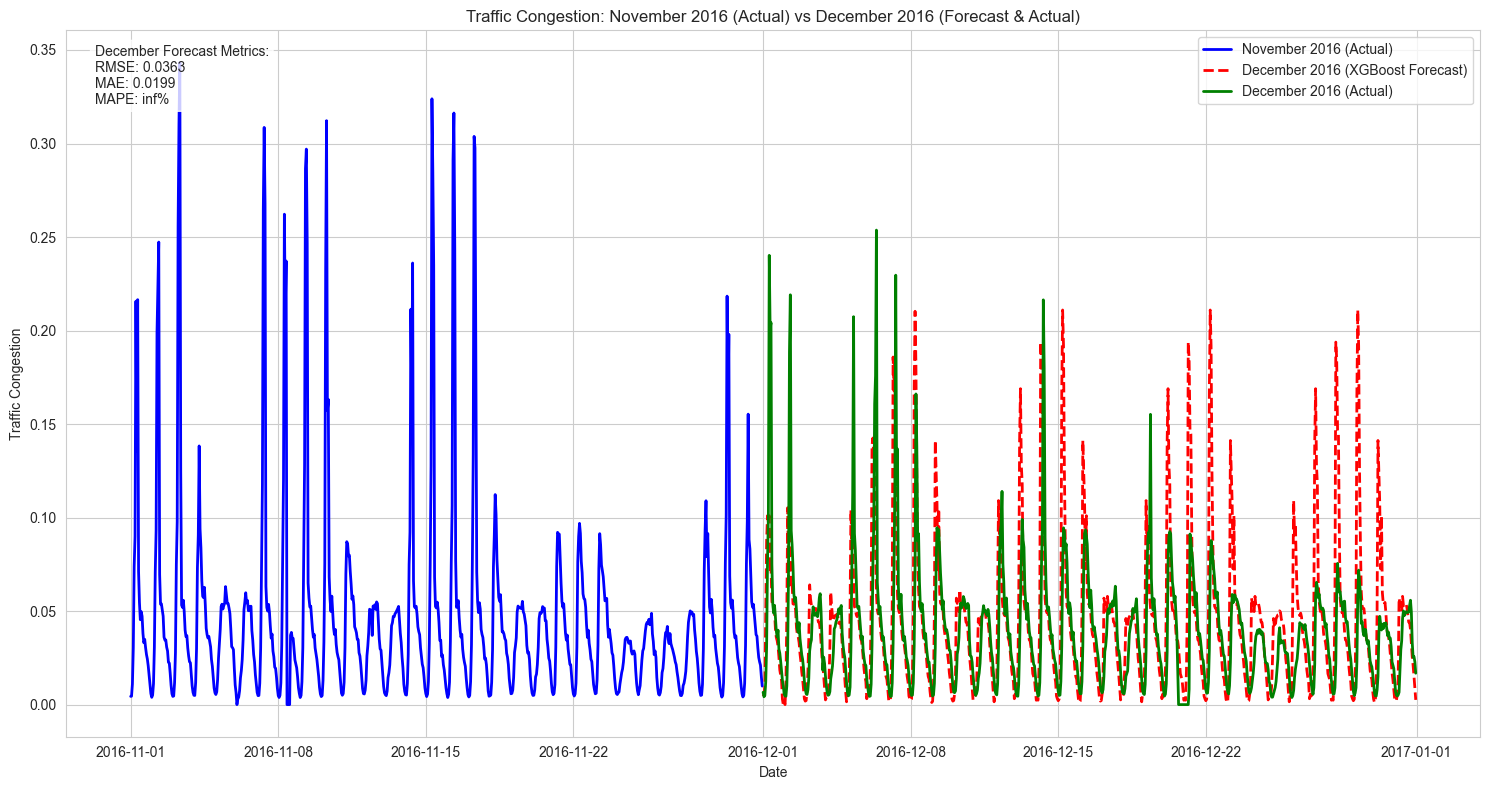


Forecasts saved to 'xgboost_december_forecasts.csv'

December 2016 Forecast Error Metrics:
RMSE: 0.0363
MAE:  0.0199
MAPE: inf%


In [227]:
# Cell 54 - Generate and Plot Final Forecasts
print("Generating and plotting final forecasts...")

# Get last month of known data (November 2016)
last_known_data = df[:'2016-11-30 23:00:00'].tail(24)

# Generate December forecasts
december_forecasts = forecast_december_2016_xgb(bst, last_known_data)

# Load solution data
solution_path = os.path.join('solution', 't2_solution.csv')
solution_data = pd.read_csv(solution_path)
solution_data['datetime'] = pd.to_datetime(solution_data['DateTime'])
solution_data.set_index('datetime', inplace=True)

# Create visualization
plt.figure(figsize=(15, 8))

# Plot November actual data
november_data = df['2016-11-01':'2016-11-30']
plt.plot(november_data.index, november_data['X'], 
         label='November 2016 (Actual)', 
         color='blue', linewidth=2)

# Plot December forecasts
plt.plot(december_forecasts.index, december_forecasts.values,
         label='December 2016 (XGBoost Forecast)',
         color='red', linestyle='--', linewidth=2)

# Plot December actual (solution)
plt.plot(solution_data.index, solution_data['X'],
         label='December 2016 (Actual)',
         color='green', linewidth=2)

plt.title('Traffic Congestion: November 2016 (Actual) vs December 2016 (Forecast & Actual)')
plt.xlabel('Date')
plt.ylabel('Traffic Congestion')
plt.legend()
plt.grid(True)

# Add error metrics
dec_rmse = np.sqrt(mean_squared_error(solution_data['X'], december_forecasts))
dec_mae = mean_absolute_error(solution_data['X'], december_forecasts)
dec_mape = np.mean(np.abs((solution_data['X'] - december_forecasts) / solution_data['X'])) * 100

metrics_text = f'December Forecast Metrics:\nRMSE: {dec_rmse:.4f}\nMAE: {dec_mae:.4f}\nMAPE: {dec_mape:.2f}%'
plt.text(0.02, 0.98, metrics_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Save forecasts to CSV
forecast_df = pd.DataFrame({
    'datetime': december_forecasts.index,
    'XGB_forecast': december_forecasts.values
})
forecast_df.to_csv('xgboost_december_forecasts.csv', index=False)
print("\nForecasts saved to 'xgboost_december_forecasts.csv'")

print("\nDecember 2016 Forecast Error Metrics:")
print(f"RMSE: {dec_rmse:.4f}")
print(f"MAE:  {dec_mae:.4f}")
print(f"MAPE: {dec_mape:.2f}%")

## LSTM

In [211]:
# Cell 55 - LSTM Data Preparation

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler  # or StandardScaler

# 1) Create a windowed dataset (sequence to next-step) from Jan 2015 - Nov 2016
#    We assume df_processed has a datetime index from 2015-01 to 2016-12 (with 2016-12 missing or separate).
#    We only want data up to 2016-11-30 23:00:00 for training/validation.

train_end = '2016-11-30 23:00:00'
df_lstm = df_processed.loc[:train_end].copy()

# We'll just use 'X' for demonstration. If you want more features, you can create them and include them below.
feature_cols = ['X']
df_lstm = df_lstm[feature_cols].dropna()

# 2) Scale the data
scaler = MinMaxScaler()  # or StandardScaler()
scaled_values = scaler.fit_transform(df_lstm.values)  # shape: (num_samples, num_features)
scaled_df = np.array(scaled_values).reshape(-1)  # flatten if we have only one feature

# 3) Create a PyTorch Dataset for LSTM
#    We'll define a class that returns sequences of length seq_length and the next value as the target.

class LSTMDataset(Dataset):
    def __init__(self, data, seq_length=24):
        """
        data: 1D (or 2D) scaled array of shape (num_samples, )
        seq_length: how many time steps in the input sequence
        """
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        # If we want to predict the next step after seq_length, 
        # the last index we can start a sequence is len(data)-seq_length-1
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x_seq = self.data[idx : idx + self.seq_length]  # input sequence
        y_val = self.data[idx + self.seq_length]         # next step
        # If your data has multiple features, x_seq will be shape (seq_length, num_features).
        # If single feature, x_seq is (seq_length, ), so we might need to expand dims for PyTorch LSTM.
        x_seq = torch.tensor(x_seq, dtype=torch.float).unsqueeze(-1)  # shape: (seq_length, 1)
        y_val = torch.tensor(y_val, dtype=torch.float)
        return x_seq, y_val

# 4) Instantiate the dataset and create DataLoaders
seq_length = 24  # how many hours to look back
dataset = LSTMDataset(scaled_df, seq_length=seq_length)

# We can do a train/val split of the dataset. For example, last ~744 points (about 31 days) as validation.
val_size = 744  # same idea as for ARIMA
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print(f"Full dataset length: {len(dataset)}")
print(f"Training samples:    {len(train_dataset)}")
print(f"Validation samples:  {len(val_dataset)}")


Full dataset length: 16776
Training samples:    16032
Validation samples:  744


In [212]:
# Cell 56 - Define LSTM Model

class TrafficLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(TrafficLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)  # final layer to predict 1 value

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_length, hidden_size)
        # We only need the last time step's output for next-step prediction
        out = out[:, -1, :]             # shape: (batch_size, hidden_size)
        out = self.fc(out)             # shape: (batch_size, 1)
        return out

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrafficLSTM(input_size=1, hidden_size=64, num_layers=2, dropout=0.2).to(device)

print(model)


TrafficLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [213]:
# Cell 57 - Training the LSTM Model

import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)  # shape: (batch_size, seq_length, 1)
        y_batch = y_batch.to(device)  # shape: (batch_size,)
        
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze()  # shape: (batch_size,)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * x_batch.size(0)
    
    epoch_train_loss = running_train_loss / len(train_dataset)

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            val_out = model(x_val).squeeze()
            val_loss = criterion(val_out, y_val)
            running_val_loss += val_loss.item() * x_val.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset)
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_train_loss:.6f} | "
          f"Val Loss: {epoch_val_loss:.6f}")


Epoch [1/20] - Train Loss: 0.006123 | Val Loss: 0.003376
Epoch [2/20] - Train Loss: 0.002713 | Val Loss: 0.003132
Epoch [3/20] - Train Loss: 0.002534 | Val Loss: 0.003023
Epoch [4/20] - Train Loss: 0.002434 | Val Loss: 0.003120
Epoch [5/20] - Train Loss: 0.002414 | Val Loss: 0.002880
Epoch [6/20] - Train Loss: 0.002334 | Val Loss: 0.002924
Epoch [7/20] - Train Loss: 0.002232 | Val Loss: 0.002845
Epoch [8/20] - Train Loss: 0.002275 | Val Loss: 0.002893
Epoch [9/20] - Train Loss: 0.002159 | Val Loss: 0.002852
Epoch [10/20] - Train Loss: 0.002126 | Val Loss: 0.002823
Epoch [11/20] - Train Loss: 0.002113 | Val Loss: 0.002846
Epoch [12/20] - Train Loss: 0.002115 | Val Loss: 0.002978
Epoch [13/20] - Train Loss: 0.002101 | Val Loss: 0.002991
Epoch [14/20] - Train Loss: 0.002092 | Val Loss: 0.002711
Epoch [15/20] - Train Loss: 0.002060 | Val Loss: 0.002854
Epoch [16/20] - Train Loss: 0.002042 | Val Loss: 0.003006
Epoch [17/20] - Train Loss: 0.002062 | Val Loss: 0.002941
Epoch [18/20] - Train L

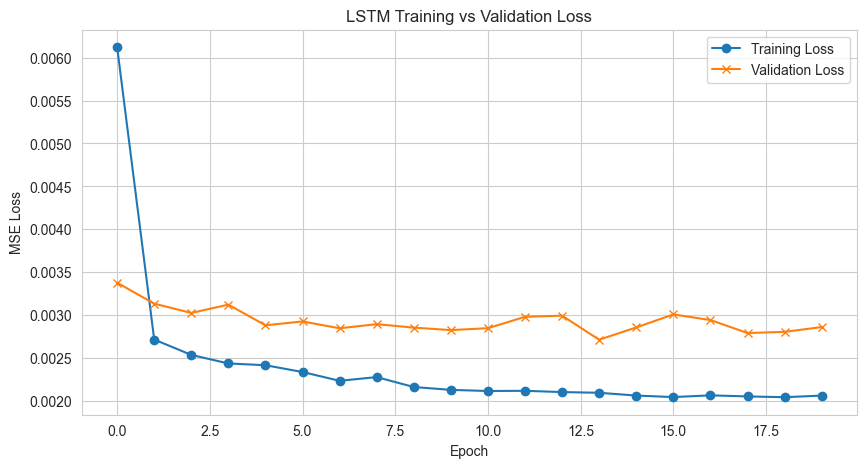

In [216]:
# Cell 58 - Plot Training History

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


December 2016 LSTM Forecast Error Metrics:
  RMSE: 0.0381
  MAE:  0.0276
  MAPE: inf%


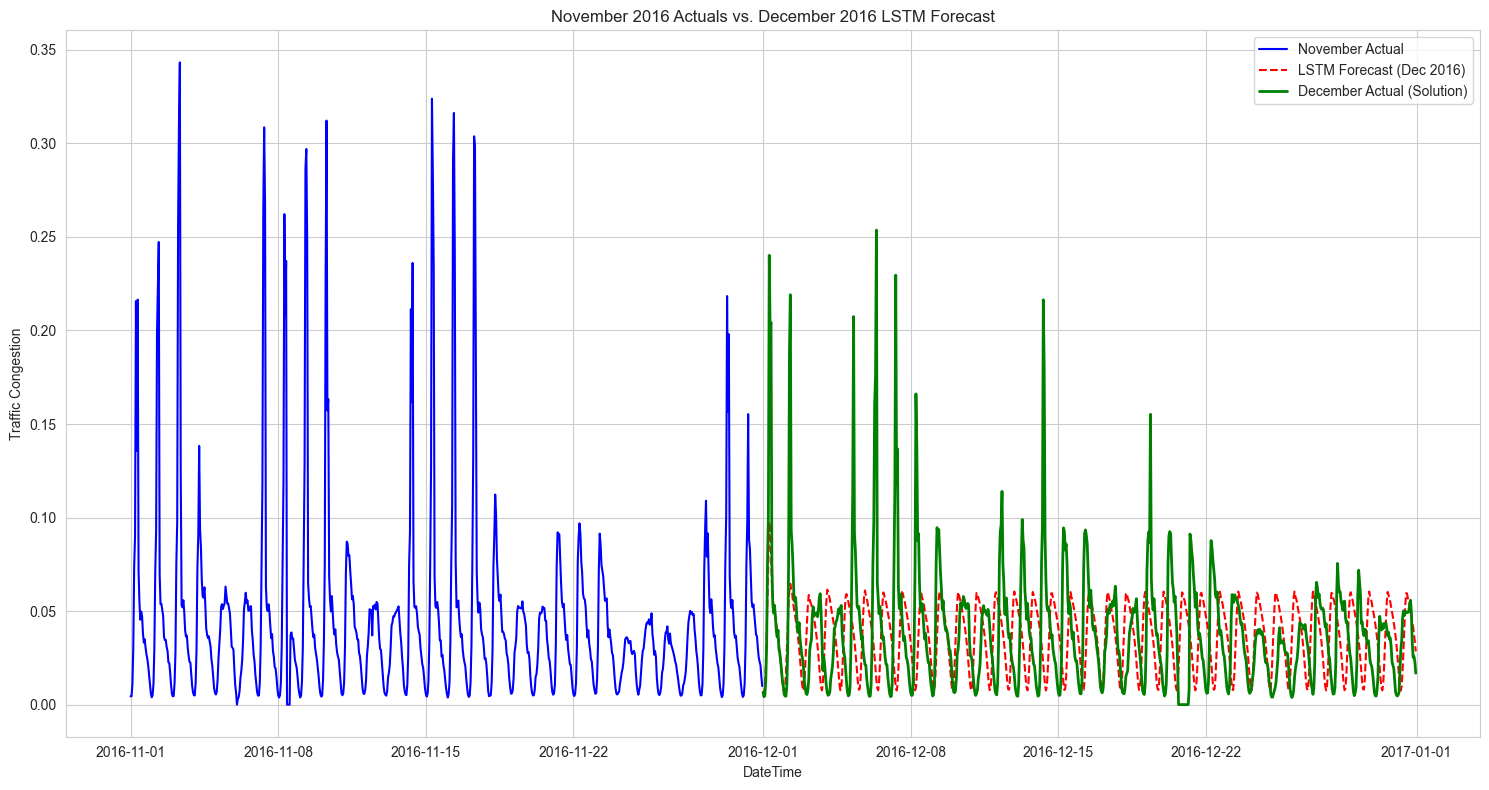

In [215]:
# Cell 60 - Forecasting December 2016

# 1) We'll generate a date range for December 2016
dec_dates = pd.date_range('2016-12-01 00:00:00', '2016-12-31 23:00:00', freq='H')

# 2) We need the last seq_length values from the training dataset to start
#    e.g., from 2016-11-30 23:00:00 going backward 24 hours
last_seq = df_processed.loc[:'2016-11-30 23:00:00'].tail(seq_length)['X'].values
#    If your data is missing hours, ensure you handle that carefully.

# 3) Scale that last sequence
last_seq_scaled = scaler.transform(last_seq.reshape(-1, 1)).ravel()  # shape: (seq_length,)

# 4) Recursive forecasting
model.eval()
dec_forecasts = []

current_seq = list(last_seq_scaled)  # start as a Python list of length seq_length

for d in dec_dates:
    seq_input = torch.tensor(current_seq[-seq_length:], dtype=torch.float).unsqueeze(0).unsqueeze(-1).to(device)
    # shape: (1, seq_length, 1)
    with torch.no_grad():
        pred_scaled = model(seq_input).cpu().numpy().flatten()[0]  # single float
    # unscale
    pred_unscaled = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()[0]
    
    dec_forecasts.append(pred_unscaled)
    
    # append the scaled prediction to current_seq
    current_seq.append(pred_scaled)

# 5) Build a DataFrame of forecasts
forecast_df_lstm = pd.DataFrame({
    'datetime': dec_dates,
    'LSTM_forecast': dec_forecasts
})
forecast_df_lstm.set_index('datetime', inplace=True)

# 6) If we have the real December data (solution), compare
solution_path = 'solution/t2_solution.csv'
try:
    dec_solution = pd.read_csv(solution_path)
    dec_solution['DateTime'] = pd.to_datetime(dec_solution['DateTime'], format='mixed', errors='coerce')
    dec_solution.set_index('DateTime', inplace=True)
    dec_solution.sort_index(inplace=True)

    # Extract December 2016 real X
    dec_real = dec_solution.loc['2016-12-01 00:00:00':'2016-12-31 23:00:00', 'X']

    # Calculate error metrics
    common_index = forecast_df_lstm.index.intersection(dec_real.index)
    y_pred_dec = forecast_df_lstm.loc[common_index, 'LSTM_forecast']
    y_true_dec = dec_real.loc[common_index]

    rmse_dec = np.sqrt(mean_squared_error(y_true_dec, y_pred_dec))
    mae_dec = mean_absolute_error(y_true_dec, y_pred_dec)
    mape_dec = np.mean(np.abs((y_true_dec - y_pred_dec) / y_true_dec)) * 100

    print("\nDecember 2016 LSTM Forecast Error Metrics:")
    print(f"  RMSE: {rmse_dec:.4f}")
    print(f"  MAE:  {mae_dec:.4f}")
    print(f"  MAPE: {mape_dec:.2f}%")
except Exception as e:
    print("Could not load real December 2016 data for comparison. Skipping metrics.")

# 7) Plot the results vs November data and real December if available
import matplotlib.pyplot as plt

november_actuals = df.loc['2016-11-01':'2016-11-30 23:00:00', 'X']

plt.figure(figsize=(15, 8))
# Plot November actuals
plt.plot(november_actuals.index, november_actuals.values, label='November Actual', color='blue')

# Plot LSTM forecast for December
plt.plot(forecast_df_lstm.index, forecast_df_lstm['LSTM_forecast'], label='LSTM Forecast (Dec 2016)', color='red', linestyle='--')

# If real December values exist, plot them
if 'dec_real' in locals():
    plt.plot(dec_real.index, dec_real.values, label='December Actual (Solution)', color='green', linewidth=2)

plt.title('November 2016 Actuals vs. December 2016 LSTM Forecast')
plt.xlabel('DateTime')
plt.ylabel('Traffic Congestion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# FINAL SAVING

In [241]:
# Cell - Final Submission File Creation
from datetime import datetime
import pandas as pd
import os

def create_final_submission():
    """
    Create final submission file combining SARIMAX, UCM, and ML forecasts.
    """
    print("Creating final submission file...")
    
    # Create submission filename with current date
    submission_date = datetime.now().strftime('%Y%m%d')
    submission_filename = f'902064_{submission_date}.csv'
    
    # Create DateTime index
    dates = pd.date_range(
        start='2016-12-01 00:00:00',
        end='2016-12-31 23:00:00',
        freq='H'
    )
    
    # Initialize submission DataFrame
    submission_df = pd.DataFrame({'DateTime': dates})
    
    try:
        # Load SARIMAX forecasts
        if os.path.exists('sarimax_forecasts.csv'):
            sarimax = pd.read_csv('sarimax_forecasts.csv')
            submission_df['ARIMA'] = sarimax['SARIMAX']
            print("SARIMAX forecasts loaded successfully")
        else:
            print("Warning: sarimax_forecasts.csv not found")
            submission_df['ARIMA'] = None
            
        # Load UCM forecasts
        if os.path.exists('ucm_forecasts.csv'):
            ucm = pd.read_csv('ucm_forecasts.csv')
            submission_df['UCM'] = ucm['UCM']
            print("UCM forecasts loaded successfully")
        else:
            print("Warning: ucm_forecasts.csv not found")
            submission_df['UCM'] = None
            
        # Load ML forecasts
        if os.path.exists('xgboost_december_forecasts.csv'):
            ml = pd.read_csv('xgboost_december_forecasts.csv')
            submission_df['ML'] = ml['XGB_forecast']
            print("ML forecasts loaded successfully")
        else:
            print("Warning: xgboost_december_forecasts.csv not found")
            submission_df['ML'] = None
        
        # Save final submission file
        submission_df.to_csv(submission_filename, index=False)
        print(f"\nSubmission file saved as {submission_filename}")
        
        # Verify the saved file
        verify_df = pd.read_csv(submission_filename)
        print("\nVerification of submission file:")
        print("\nFirst few rows:")
        print(verify_df.head())
        print("\nLast few rows:")
        print(verify_df.tail())
        print("\nShape:", verify_df.shape)
        print("\nColumns:", verify_df.columns.tolist())
        print("\nSummary statistics:")
        for col in ['ARIMA', 'UCM', 'ML']:
            if col in verify_df.columns:
                print(f"\n{col}:")
                print(verify_df[col].describe())
        
        # Check for any missing values
        missing = verify_df.isnull().sum()
        if missing.any():
            print("\nWarning: Missing values detected:")
            print(missing[missing > 0])
            
    except Exception as e:
        print(f"Error creating submission file: {str(e)}")
        raise

# Execute the function
create_final_submission()

Creating final submission file...
SARIMAX forecasts loaded successfully
UCM forecasts loaded successfully
ML forecasts loaded successfully

Submission file saved as 902064_20250111.csv

Verification of submission file:

First few rows:
              DateTime     ARIMA       UCM        ML
0  2016-12-01 00:00:00  0.007671  0.005834  0.004518
1  2016-12-01 01:00:00  0.006014  0.003296  0.005424
2  2016-12-01 02:00:00  0.006943  0.003671  0.009802
3  2016-12-01 03:00:00  0.012707  0.008962  0.050102
4  2016-12-01 04:00:00  0.029641  0.023488  0.087755

Last few rows:
                DateTime     ARIMA       UCM        ML
739  2016-12-31 19:00:00  0.023311  0.028323  0.025629
740  2016-12-31 20:00:00  0.019214  0.024430  0.020911
741  2016-12-31 21:00:00  0.016694  0.022029  0.015171
742  2016-12-31 22:00:00  0.011111  0.016195  0.008650
743  2016-12-31 23:00:00  0.004327  0.009135  0.002527

Shape: (744, 4)

Columns: ['DateTime', 'ARIMA', 'UCM', 'ML']

Summary statistics:

ARIMA:
count    

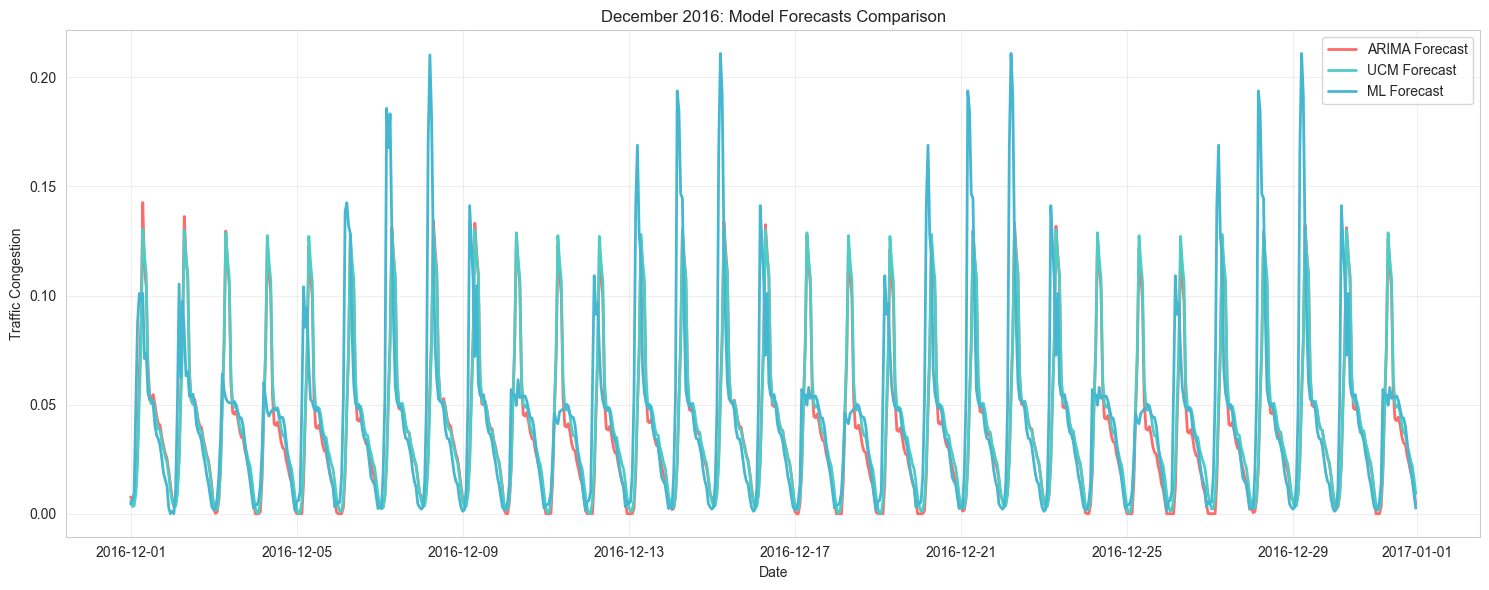

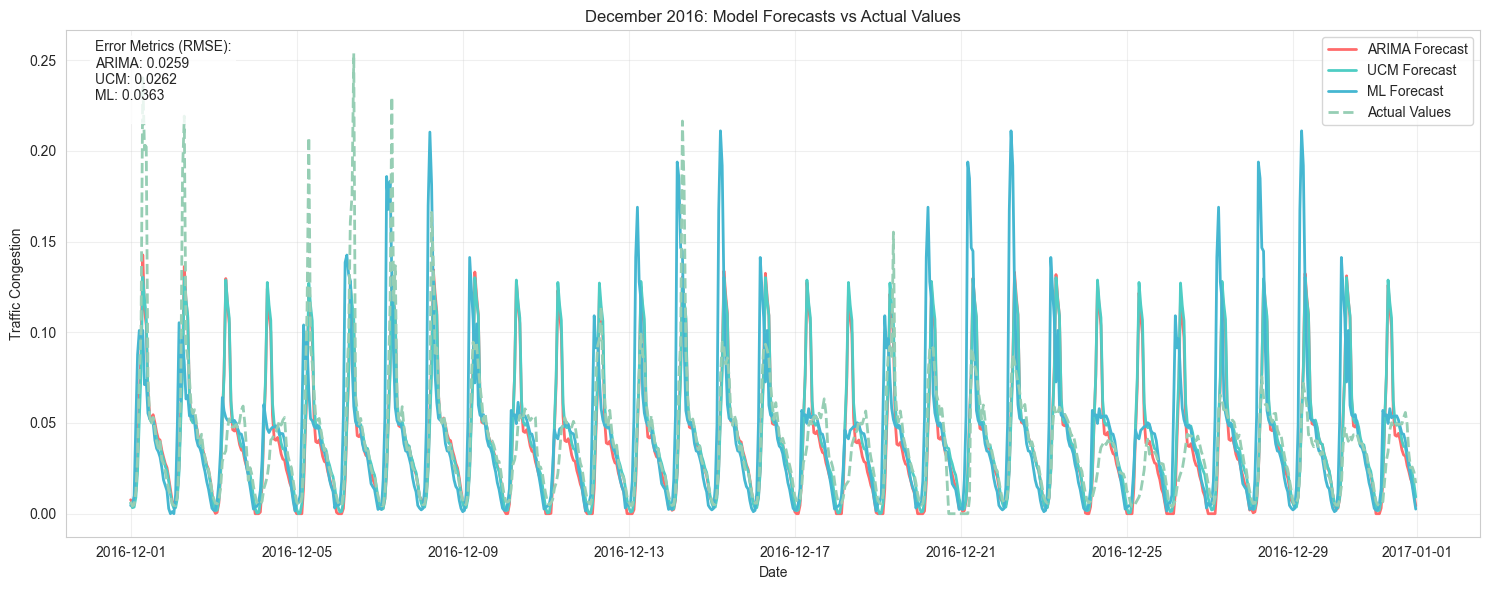


Model Performance Metrics:

Root Mean Square Error (RMSE):
ARIMA: 0.0259
UCM: 0.0262
ML: 0.0363

Mean Absolute Error (MAE):
ARIMA: 0.0150
UCM: 0.0137
ML: 0.0199

Mean Absolute Percentage Error (MAPE):
ARIMA: inf%
UCM: inf%
ML: inf%


In [242]:
# Cell - Final Comparison Plots
def create_final_comparison_plots():
    """
    Create two comparison plots:
    1. Three model forecasts for December 2016
    2. Three model forecasts with actual December 2016 values
    """
    # Read the submission file
    submission_date = datetime.now().strftime('%Y%m%d')
    submission_filename = f'902064_{submission_date}.csv'
    forecasts = pd.read_csv(submission_filename)
    forecasts['DateTime'] = pd.to_datetime(forecasts['DateTime'])
    
    # Read the solution
    solution = pd.read_csv('solution/t2_solution.csv')
    solution['DateTime'] = pd.to_datetime(solution['DateTime'])
    
    # Create color scheme
    colors = {
        'ARIMA': '#FF6B6B',  # Coral red
        'UCM': '#4ECDC4',    # Turquoise
        'ML': '#45B7D1',     # Sky blue
        'Actual': '#96CEB4'  # Sage green
    }
    
    # Plot 1: Three forecasts
    plt.figure(figsize=(15, 6))
    for model in ['ARIMA', 'UCM', 'ML']:
        plt.plot(forecasts['DateTime'], forecasts[model],
                label=f'{model} Forecast',
                color=colors[model],
                linewidth=2)
    
    plt.title('December 2016: Model Forecasts Comparison')
    plt.xlabel('Date')
    plt.ylabel('Traffic Congestion')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Forecasts with actual values
    plt.figure(figsize=(15, 6))
    
    # Plot forecasts
    for model in ['ARIMA', 'UCM', 'ML']:
        plt.plot(forecasts['DateTime'], forecasts[model],
                label=f'{model} Forecast',
                color=colors[model],
                linewidth=2)
    
    # Plot actual values
    plt.plot(solution['DateTime'], solution['X'],
            label='Actual Values',
            color=colors['Actual'],
            linewidth=2,
            linestyle='--')
    
    plt.title('December 2016: Model Forecasts vs Actual Values')
    plt.xlabel('Date')
    plt.ylabel('Traffic Congestion')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add error metrics as text box
    metrics_text = "Error Metrics (RMSE):\n"
    for model in ['ARIMA', 'UCM', 'ML']:
        rmse = np.sqrt(mean_squared_error(solution['X'], forecasts[model]))
        metrics_text += f"{model}: {rmse:.4f}\n"
    
    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison statistics
    print("\nModel Performance Metrics:")
    print("\nRoot Mean Square Error (RMSE):")
    for model in ['ARIMA', 'UCM', 'ML']:
        rmse = np.sqrt(mean_squared_error(solution['X'], forecasts[model]))
        print(f"{model}: {rmse:.4f}")
        
    print("\nMean Absolute Error (MAE):")
    for model in ['ARIMA', 'UCM', 'ML']:
        mae = mean_absolute_error(solution['X'], forecasts[model])
        print(f"{model}: {mae:.4f}")
        
    print("\nMean Absolute Percentage Error (MAPE):")
    for model in ['ARIMA', 'UCM', 'ML']:
        mape = np.mean(np.abs((solution['X'] - forecasts[model]) / solution['X'])) * 100
        print(f"{model}: {mape:.2f}%")

# Execute the function
create_final_comparison_plots()